In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import allel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, cohen_kappa_score, f1_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline


import umap.umap_ as umap

In [5]:
R_SEED = 22
home = os.path.expanduser('~')
directory = os.path.join('Imp_Research','Dataset')

# populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
#               'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
#               'GW','KE','UGgam']

# Using only 12 populations out of 16
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam',
              'GAgam','GHcol','GM','GNgam','GW','KE','UGgam']

# Creating a dictionary of Population names with labels
populations_encoding = {}
for i in range(len(populations)):
    populations_encoding[i] = populations[i]

### Functions to Load and Pre-Process the Datasets

In [80]:
'''
Requirements : NumPy and Scikit-Allel
'''

class FilterSNP():
    def __init__(self,haplotype, POS):
        self.haplotype = haplotype
        self.POS = POS
        self.H = haplotype
        self.P = POS
        self._removed_maf = None
        self._retained_maf = None
        self._retained_ld = None
        self._removed_ld = None
        self._unlinked_POS = None
        
    def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):
        print("1.) Selecting Mega Base Pairs")
        self.H,self.P = self.get_haplo_MBP(self.H,self.P,start = MBP_start, end = MBP_end)
        print("MBP selected. Retained Matrix = ", self.H.shape)
        print("2.) Filtering Rare Allels")
        self.H,self.P = self.filter_MAF(self.H,self.P,threshold = MAF_threshold)
        print("3.) Performing LD Pruning")
        self.H,self.P = self.LD_pruning(self.H, self.P, LD_window_size, LD_overlap_step, threshold = LD_threshold, n_iter = LD_iter)
        print("Retained Haplotype Matrix = ", self.H.shape)
        print("Retained Positions Matrix = ",self.P.shape)
        
        return self.H, self.P
        
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def filter_MAF(self,haplo,POS,threshold = 5):
        if threshold >= 50 : 
            print("MAF threshold cannot be more than 49%")
            return
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = self.get_MAF(haplo)
        #indexes = np.where(maf >= threshold*0.01)[0]
        minor = samples*threshold/100
        major = samples*(100-threshold)/100
        # Selects indexes where allels are >threshold or all 0 and all 1.
        indexes = np.where((sums>=minor)& (sums<=major))[0]
        print("Number of SNPs removed = ",len(haplo)-len(indexes))
        print("Retaining = ",len(indexes))
        self._removed_maf = len(haplo)-len(indexes)
        self._retained_maf = len(indexes)
        return np.take(haplo,indexes,0), np.take(POS,indexes,0)

    # Returns : Array of MAF
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MAF(self,haplo):
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = []
        for s in sums:
            if s != samples or s != 0:
                frequency = s/samples
                if frequency > 0.5:
                    maf.append(1-frequency)
                else: 
                    maf.append(frequency)
        return np.array(maf)

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MBP(self,POS,start = 1,end = 37):
        return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_haplo_MBP(self,haplotype,POS,start = 1,end = 37):
        index = self.get_MBP(POS,start,end)
        return np.take(haplotype,index,0),np.take(POS,index,0)
    
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def LD_pruning(self, gn, pos, size, step, threshold = .1, n_iter=1):
        removed = 0
        for i in range(n_iter):
            
            # Returns a boolean array. True(1) - SNPs are within threshold (Unliked), False(0) = Linked
            loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
            
            # Counts non-zero elements = No. of unlinked loci or SNPs to retain
            n = np.count_nonzero(loc_unlinked)
            
            # Calculate the number of SNPs to be removed
            n_remove = gn.shape[0] - n
            removed += n_remove
            print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
            
            # Select only the unlinked SNPs, i.e., indexes where value is True(1).
            gn = gn.compress(loc_unlinked, axis=0)
            
            # retaining the indexes preserved
            pos = pos.compress(loc_unlinked)
        self._retained_ld = gn.shape[0]
        self._removed_ld = removed
        self._unlinked_POS = pos
        return gn,pos

In [7]:
'''
Disclaimer : The class is for personal use. It is not aimed for portability or reusability.

Class to load and filter the data from disk.
Object Parameters : 
data_path  -> Path to the data directory

load_pop() : Function to load the data
params : 
Populations -> list or array of population names/filenames
filtered -> boolean, whethere to filter the data or not
combine -> Boolean, to combine the populations (Implement it !!!)

returns : A dictionary of haplotype matrix and Position array
'''

class LoadFilteredPops():
    def __init__(self,data_path = None):
        self.data_path = data_path
        
    def load_pop(self,populations,naming='custom',chromo_arms = ['3R'],filtered = True):
        if self.data_path is None:
            home = os.path.expanduser('~')
            directory = os.path.join('Imp_Research','Dataset')
        Haplo_pop = {}
        POS_pop = {}
        for population in populations:
            for arm in chromo_arms:
                pop_name = population+'.'+arm
                if naming == 'custom':
                    filename = f'Haplotype.POS.{pop_name}.hd5'
                else:
                    filename = population
                if self.data_path is None:
                    data_path = os.path.join(home, directory,"HDF_Dataset", filename)
                else:
                    try:
                        data_path = os.path.join(self.data_path,filename)
                    except:
                        print("Cannot resolve Directory path")
                        exit()
                print(f'------{pop_name}------\n')
                H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
                P = pd.read_hdf(data_path,key='POS').to_numpy()
                
                if filtered:
                    # Uses FilterSNP class for filtering steps
                    datafilter = FilterSNP(H,P)
                    Haplo_pop[pop_name],POS_pop[pop_name] = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
                else: 
                    Haplo_pop[pop_name],POS_pop[pop_name] = H,P
                del H,P     
        print("Populations loaded !!!")
        return Haplo_pop,POS_pop

    
'''
Function to combine the populations
Input Params
Haplo_all : Dictionary containing Haplotype matrix for populations. Key-> pop name; Value -> matrix.
            Matrix dimensions must be POS x haplotypes.
POS_all : Position array of SNPs
filtered : Boolean, to filter after combining or not.
get_labels : Boolean, to generate labels

returns
Haplo_all : ndarray of n x m dimensions. n = length of POS array; m = sum of haplotypes from all populations.
POS : SNP Position array
labels : list of labels if Labels = []
'''

# def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, 
#                 MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):

def combine_pops(H_all,P_all,filtered = True,get_labels = True,LD_window_size = 500, LD_overlap_step = 100,
                 MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=3):
    keys = list(H_all.keys())
    
    # Unpacking the Haplotype matrices of all pops from dictionary
    H = np.array(H_all[keys[0]])
    if len(H_all) > 1:
        for i in range(1,len(H_all)):
            H = np.append(H,H_all[keys[i]],axis=1)
    print('Combined Shape => ',H.shape)
    # Generating Labels if True
    if get_labels:
        label = []
        for each in keys:
            label.extend([each]*len(H_all[each][0]))
                          
    # Returning the combined Haplotype data matrix if Filtered = False
    if filtered == False:
        if get_labels:
            return H,P_all,label
        else:
            return H,p_all
    else:
        # Uses FilterSNP class for filtering steps
        datafilter = FilterSNP(H,P_all)
        H_filtered,POS_filtered = datafilter.all_filters(LD_window_size,LD_overlap_step,MBP_start,MBP_end,
                                                            MAF_threshold,LD_threshold,LD_iter)
        print('Final Filtered Shape = ',H_filtered.shape)
        if get_labels:
            return H_filtered,POS_filtered,label
        else:
            return H_filtered,POS_filtered
        

### Loading Dataset

In [8]:
# Loading dataset into the memory using the custom loader classes above
# Stored into dictionaries

loader = LoadFilteredPops()
Haplo_all, POS_all = loader.load_pop(populations,filtered = False)

------BFcol.3R------

------BFgam.3R------

------AOcol.3R------

------CIcol.3R------

------CMgam.3R------

------GAgam.3R------

------GHcol.3R------

------GM.3R------

------GNgam.3R------

------GW.3R------

------KE.3R------

------UGgam.3R------

Populations loaded !!!


#### Downsampling CMgam

In [77]:
H = Haplo_all.copy()

# Find the indexes  of CMgam
cmgam = H['CMgam.3R']
# Retaining only first 100 samples (200 Haplotypes)
H['CMgam.3R'] = cmgam[:,:200]
print('Shape of CMgam: ',H['CMgam.3R'].shape)

Shape of CMgam:  (4836295, 200)


#### Converting Haplotypes into Genotypes

In [58]:
for key in H.keys():
    X = H[key].T
    X_g = []
    for i in range(0,len(X),2):
        X_g.append(X[i]+X[i+1])
    X_g = np.array(X_g)
    H[key] = X_g
    print(f'{key} transformed shape: \t{X_g.shape}')

BFcol.3R transformed shape: 	(75, 4836295)
BFgam.3R transformed shape: 	(92, 4836295)
AOcol.3R transformed shape: 	(78, 4836295)
CIcol.3R transformed shape: 	(71, 4836295)
CMgam.3R transformed shape: 	(100, 4836295)
GAgam.3R transformed shape: 	(69, 4836295)
GHcol.3R transformed shape: 	(55, 4836295)
GM.3R transformed shape: 	(65, 4836295)
GNgam.3R transformed shape: 	(40, 4836295)
GW.3R transformed shape: 	(91, 4836295)
KE.3R transformed shape: 	(48, 4836295)
UGgam.3R transformed shape: 	(112, 4836295)


### Analysis Script

In [73]:
def to_genotype(X):
    Xg = []
    for i in range(0,len(X),2):
        Xg.append(X[i]+X[i+1])
    return np.array(Xg)

def evaluate_classifier(y_true,y_pred):
    test_accuracy = accuracy_score(y_true,y_pred)
    f1w = f1_score(y_true,y_pred,average= 'weighted')
    kappa = cohen_kappa_score(y_true,y_pred)
    return test_accuracy, f1w, kappa

BFcol_BFgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 117074 removing 85854 variants
iteration 2 retaining 116516 removing 558 variants
iteration 3 retaining 116490 removing 26 variants
Retained Haplotype Matrix =  (116490, 334)
Retained Positions Matrix =  (116490,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


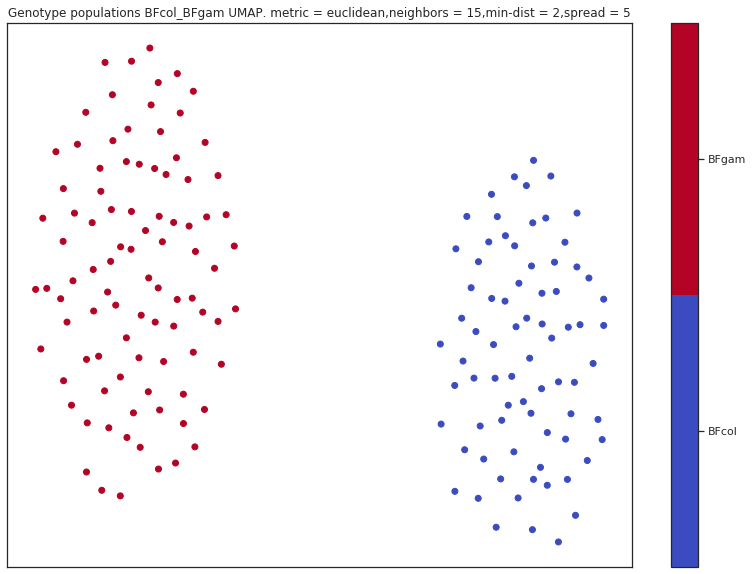

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 306)
2.) Filtering Rare Allels
Number of SNPs removed =  3455502
Retaining =  196218
3.) Performing LD Pruning
iteration 1 retaining 62654 removing 133564 variants
iteration 2 retaining 58472 removing 4182 variants
iteration 3 retaining 58116 removing 356 variants
Retained Haplotype Matrix =  (58116, 306)
Retained Positions Matrix =  (58116,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

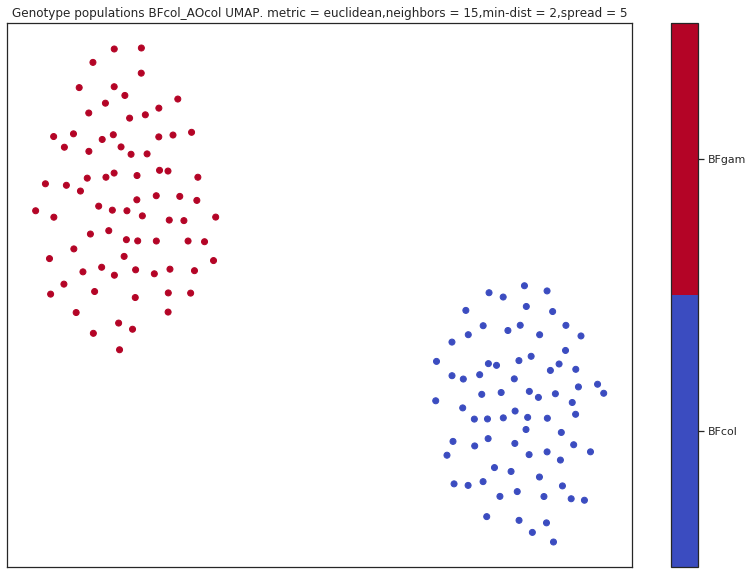

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 292)
2.) Filtering Rare Allels
Number of SNPs removed =  3444868
Retaining =  206852
3.) Performing LD Pruning
iteration 1 retaining 92221 removing 114631 variants
iteration 2 retaining 91767 removing 454 variants
iteration 3 retaining 91746 removing 21 variants
Retained Haplotype Matrix =  (91746, 292)
Retained Positions Matrix =  (91746,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

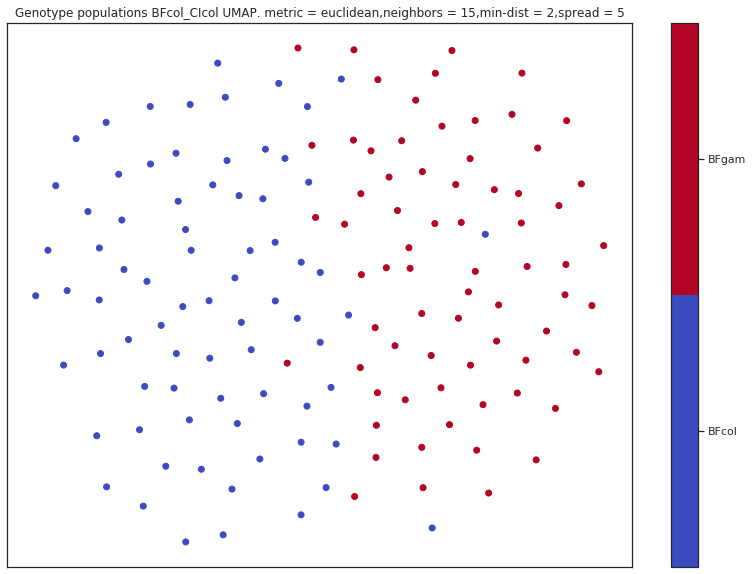

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 350)
2.) Filtering Rare Allels
Number of SNPs removed =  3450888
Retaining =  200832
3.) Performing LD Pruning
iteration 1 retaining 118043 removing 82789 variants
iteration 2 retaining 117511 removing 532 variants
iteration 3 retaining 117486 removing 25 variants
Retained Haplotype Matrix =  (117486, 350)
Retained Positions Matrix =  (117486,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

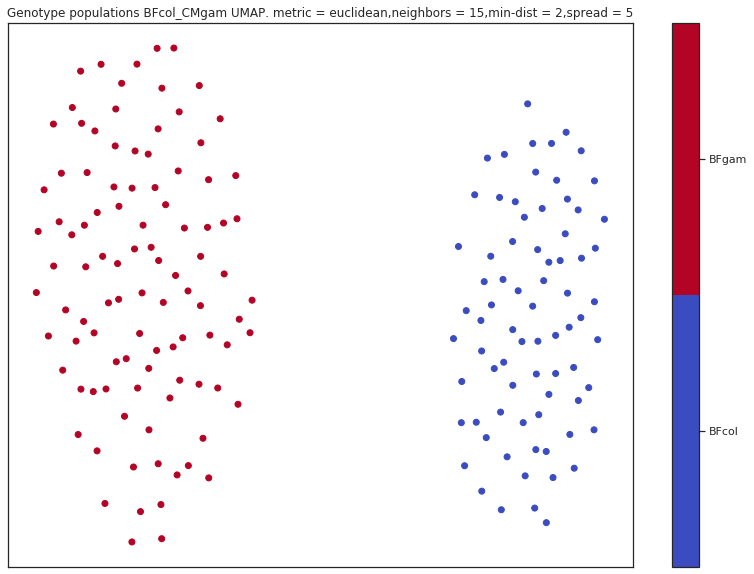

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 288)
2.) Filtering Rare Allels
Number of SNPs removed =  3433494
Retaining =  218226
3.) Performing LD Pruning
iteration 1 retaining 54854 removing 163372 variants
iteration 2 retaining 50885 removing 3969 variants
iteration 3 retaining 50559 removing 326 variants
Retained Haplotype Matrix =  (50559, 288)
Retained Positions Matrix =  (50559,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

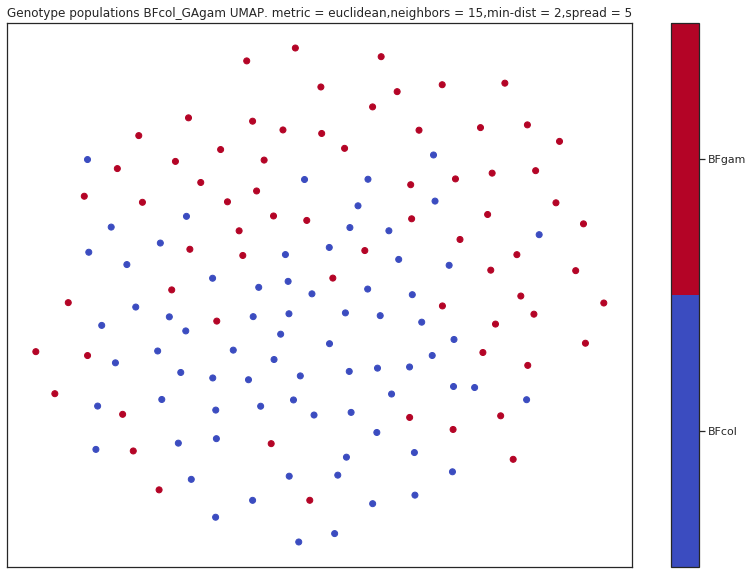

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 260)
2.) Filtering Rare Allels
Number of SNPs removed =  3442525
Retaining =  209195
3.) Performing LD Pruning
iteration 1 retaining 99475 removing 109720 variants
iteration 2 retaining 97942 removing 1533 variants
iteration 3 retaining 97857 removing 85 variants
Retained Haplotype Matrix =  (97857, 260)
Retained Positions Matrix =  (97857,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

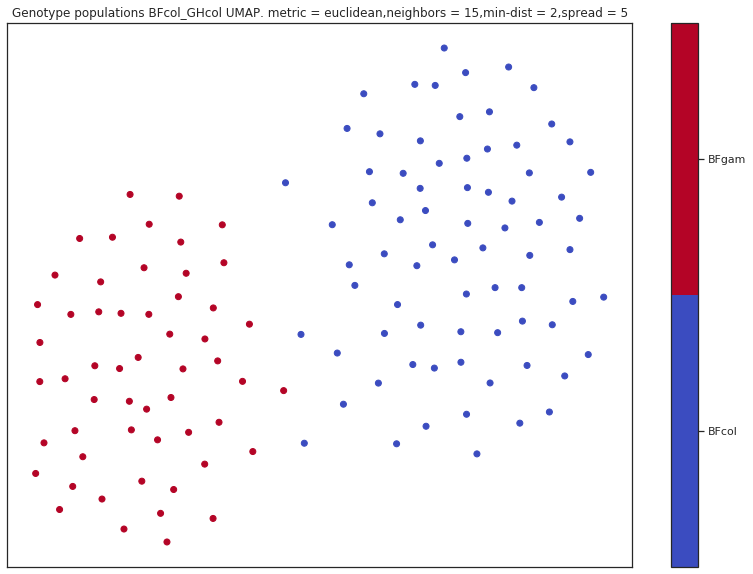

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3437772
Retaining =  213948
3.) Performing LD Pruning
iteration 2 retaining 94225 removing 1472 variants
iteration 3 retaining 94166 removing 59 variants
Retained Haplotype Matrix =  (94166, 280)
Retained Positions Matrix =  (94166,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

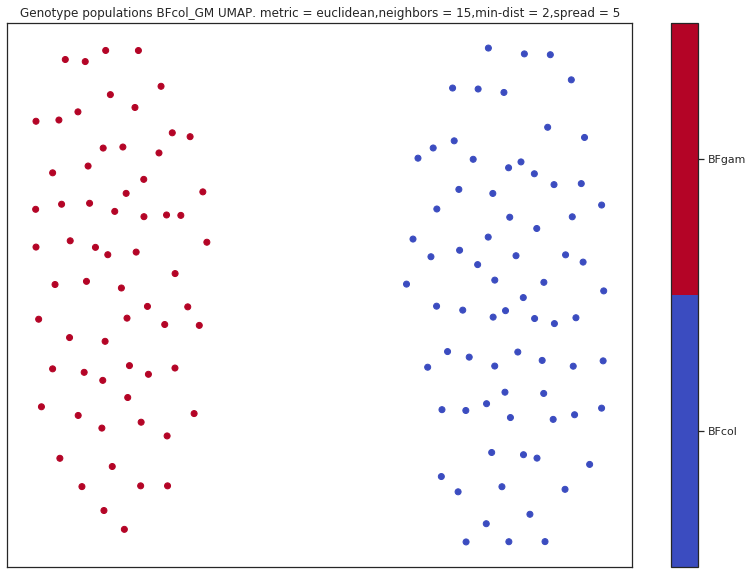

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 230)
2.) Filtering Rare Allels
Number of SNPs removed =  3451347
Retaining =  200373
3.) Performing LD Pruning
iteration 1 retaining 109352 removing 91021 variants
iteration 2 retaining 105447 removing 3905 variants
iteration 3 retaining 105107 removing 340 variants
Retained Haplotype Matrix =  (105107, 230)
Retained Positions Matrix =  (105107,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

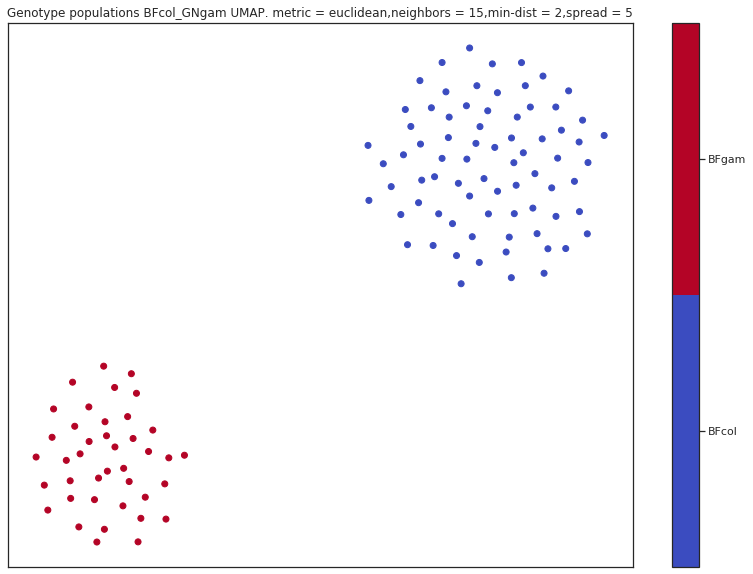

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 332)
2.) Filtering Rare Allels
Number of SNPs removed =  3444838
Retaining =  206882
3.) Performing LD Pruning
iteration 1 retaining 111278 removing 95604 variants
iteration 2 retaining 111058 removing 220 variants
iteration 3 retaining 111052 removing 6 variants
Retained Haplotype Matrix =  (111052, 332)
Retained Positions Matrix =  (111052,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

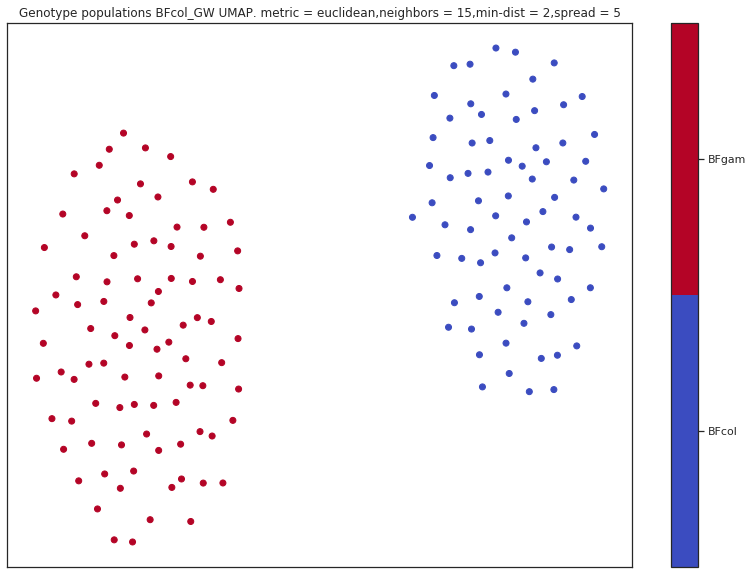

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 246)
2.) Filtering Rare Allels
Number of SNPs removed =  3459635
Retaining =  192085
3.) Performing LD Pruning
iteration 1 retaining 29755 removing 162330 variants
iteration 2 retaining 12604 removing 17151 variants
iteration 3 retaining 7366 removing 5238 variants
Retained Haplotype Matrix =  (7366, 246)
Retained Positions Matrix =  (7366,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

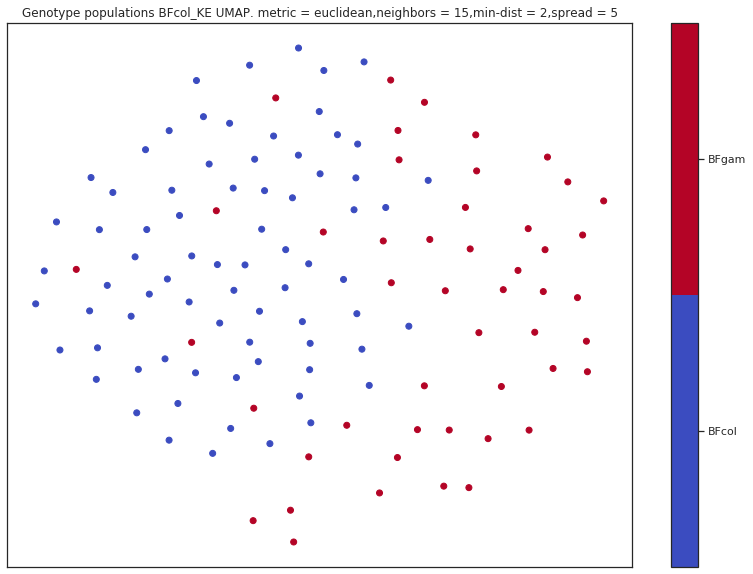

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 374)
2.) Filtering Rare Allels
Number of SNPs removed =  3446681
Retaining =  205039
3.) Performing LD Pruning
iteration 1 retaining 114821 removing 90218 variants
iteration 2 retaining 114435 removing 386 variants
iteration 3 retaining 114428 removing 7 variants
Retained Haplotype Matrix =  (114428, 374)
Retained Positions Matrix =  (114428,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

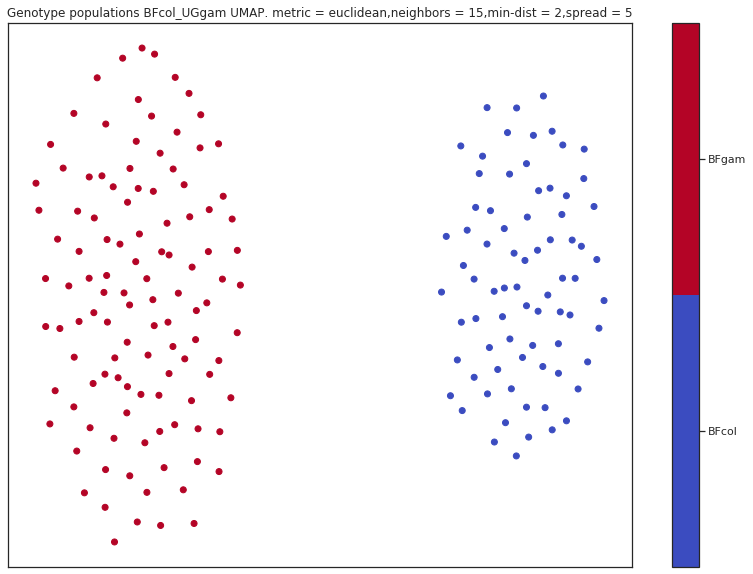

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 340)
2.) Filtering Rare Allels
Number of SNPs removed =  3444632
Retaining =  207088
3.) Performing LD Pruning
iteration 1 retaining 70754 removing 136334 variants
iteration 2 retaining 67967 removing 2787 variants
iteration 3 retaining 67781 removing 186 variants
Retained Haplotype Matrix =  (67781, 340)
Retained Positions Matrix =  (67781,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

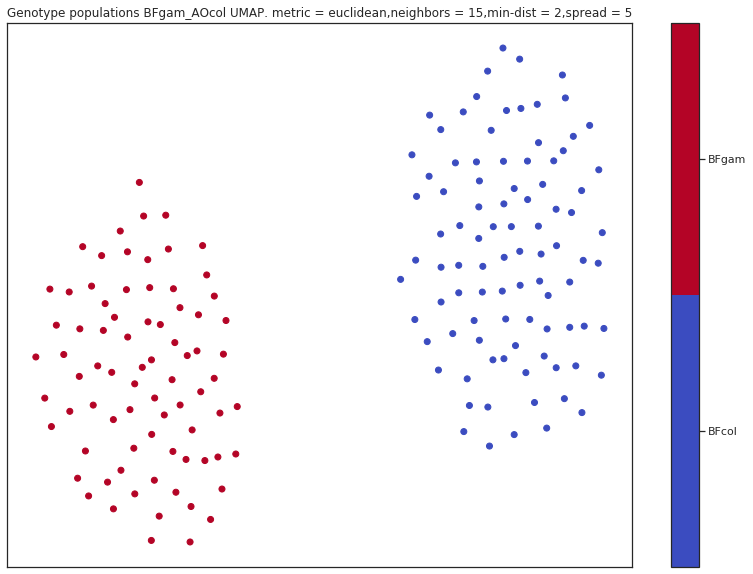

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 326)
2.) Filtering Rare Allels
Number of SNPs removed =  3447386
Retaining =  204334
3.) Performing LD Pruning
iteration 1 retaining 103078 removing 101256 variants
iteration 2 retaining 102491 removing 587 variants
iteration 3 retaining 102465 removing 26 variants
Retained Haplotype Matrix =  (102465, 326)
Retained Positions Matrix =  (102465,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

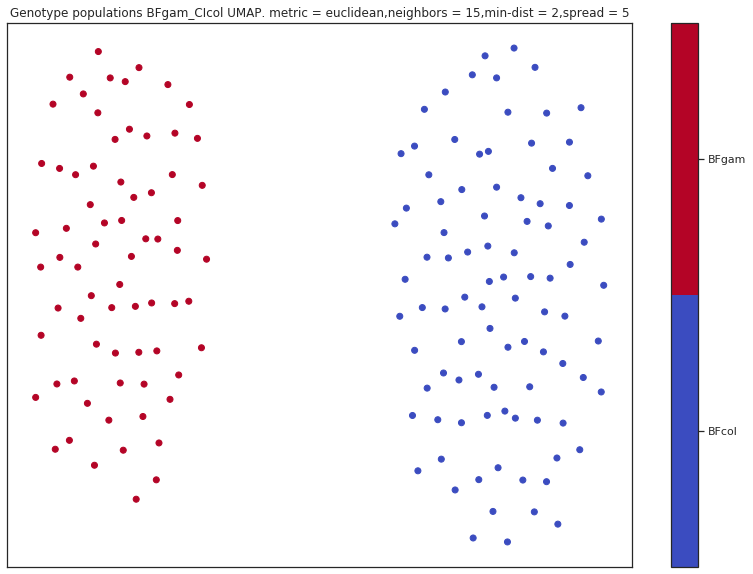

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 384)
2.) Filtering Rare Allels
Number of SNPs removed =  3449831
Retaining =  201889
3.) Performing LD Pruning
iteration 1 retaining 113829 removing 88060 variants
iteration 2 retaining 113739 removing 90 variants
iteration 3 retaining 113737 removing 2 variants
Retained Haplotype Matrix =  (113737, 384)
Retained Positions Matrix =  (113737,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

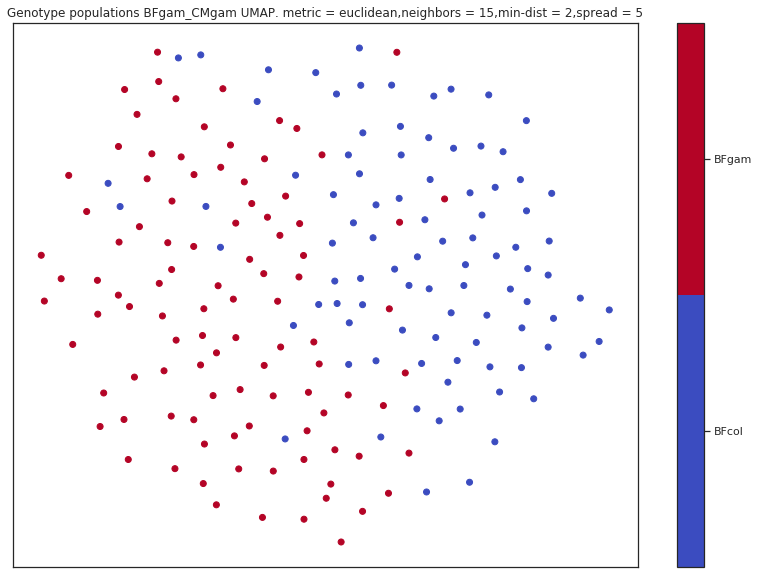

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 322)
2.) Filtering Rare Allels
Number of SNPs removed =  3435732
Retaining =  215988
3.) Performing LD Pruning
iteration 1 retaining 61132 removing 154856 variants
iteration 2 retaining 59949 removing 1183 variants
iteration 3 retaining 59905 removing 44 variants
Retained Haplotype Matrix =  (59905, 322)
Retained Positions Matrix =  (59905,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

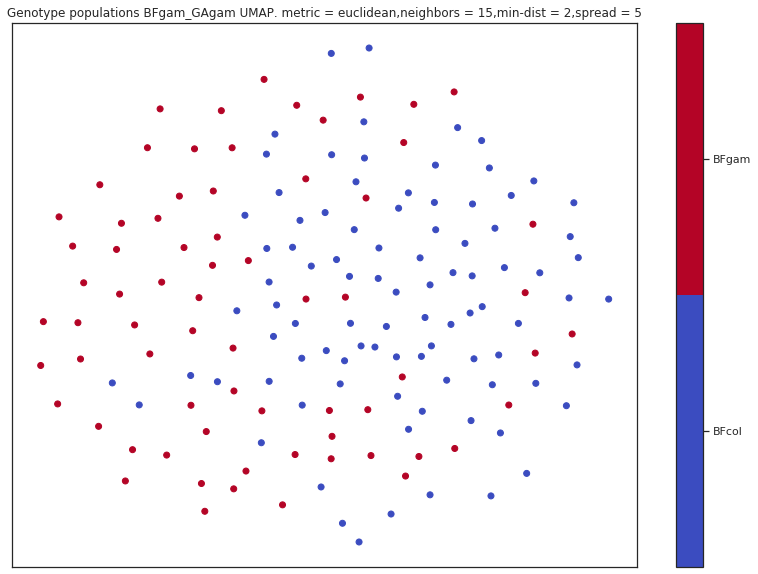

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3444547
Retaining =  207173
3.) Performing LD Pruning
iteration 1 retaining 108495 removing 98678 variants
iteration 2 retaining 107307 removing 1188 variants
iteration 3 retaining 107255 removing 52 variants
Retained Haplotype Matrix =  (107255, 294)
Retained Positions Matrix =  (107255,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

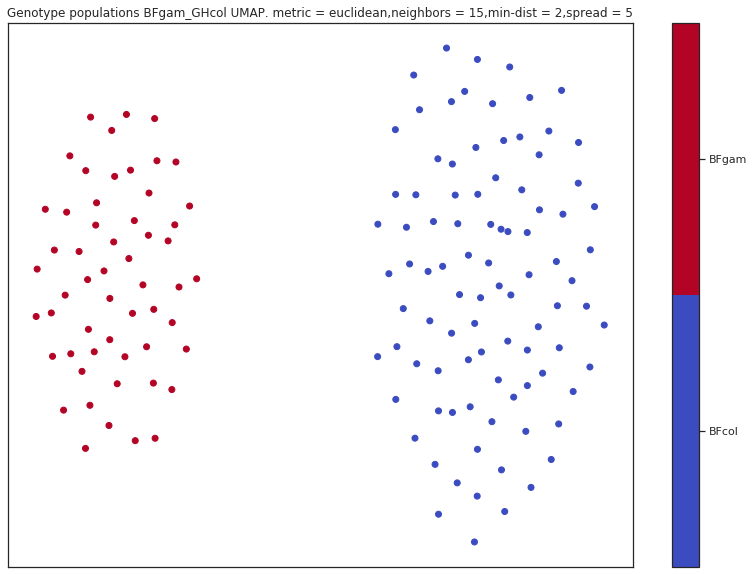

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 314)
2.) Filtering Rare Allels
Number of SNPs removed =  3441219
Retaining =  210501
3.) Performing LD Pruning
iteration 1 retaining 100595 removing 109906 variants
iteration 2 retaining 99820 removing 775 variants
iteration 3 retaining 99803 removing 17 variants
Retained Haplotype Matrix =  (99803, 314)
Retained Positions Matrix =  (99803,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

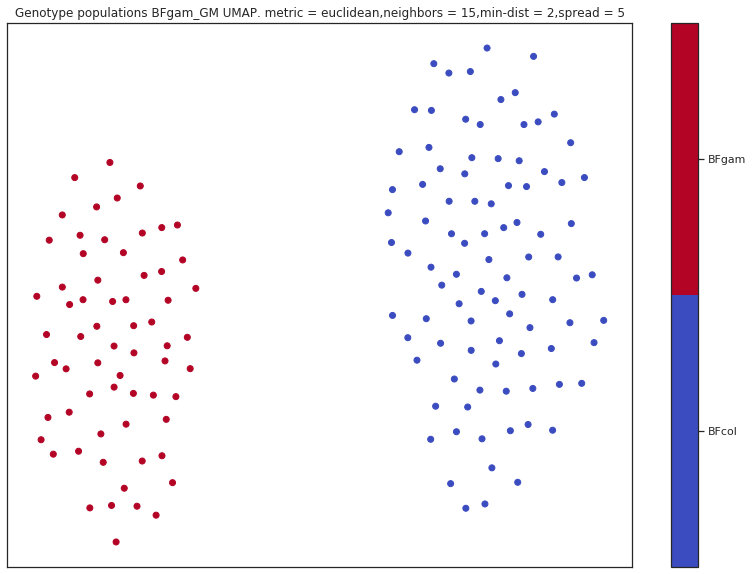

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 264)
2.) Filtering Rare Allels
Number of SNPs removed =  3448273
Retaining =  203447
3.) Performing LD Pruning
iteration 1 retaining 105799 removing 97648 variants
iteration 2 retaining 104601 removing 1198 variants
iteration 3 retaining 104527 removing 74 variants
Retained Haplotype Matrix =  (104527, 264)
Retained Positions Matrix =  (104527,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

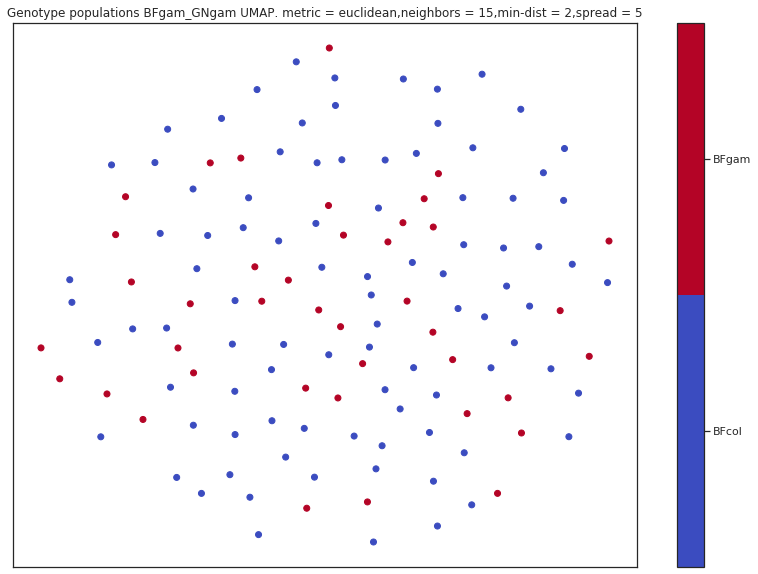

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3447387
Retaining =  204333
3.) Performing LD Pruning
iteration 1 retaining 114122 removing 90211 variants
iteration 2 retaining 113932 removing 190 variants
iteration 3 retaining 113924 removing 8 variants
Retained Haplotype Matrix =  (113924, 366)
Retained Positions Matrix =  (113924,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

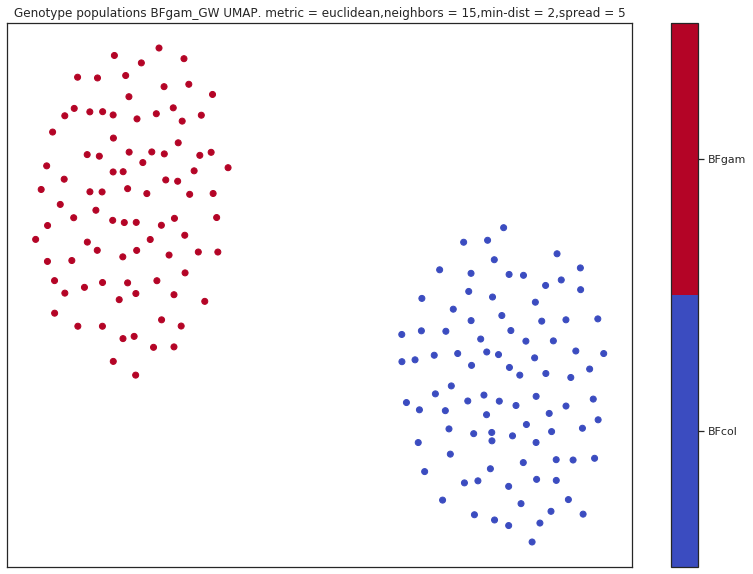

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3446317
Retaining =  205403
3.) Performing LD Pruning
iteration 1 retaining 41067 removing 164336 variants
iteration 2 retaining 27522 removing 13545 variants
iteration 3 retaining 23266 removing 4256 variants
Retained Haplotype Matrix =  (23266, 280)
Retained Positions Matrix =  (23266,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

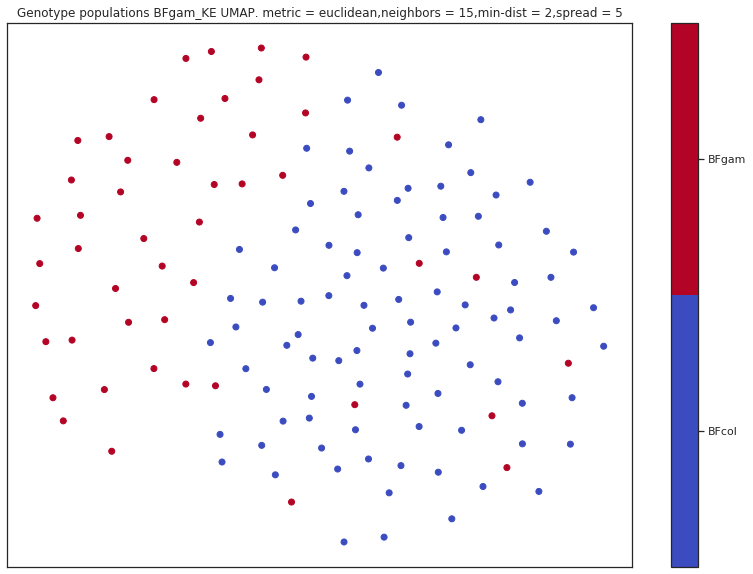

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 408)
2.) Filtering Rare Allels
Number of SNPs removed =  3447173
Retaining =  204547
3.) Performing LD Pruning
iteration 1 retaining 114155 removing 90392 variants
iteration 2 retaining 114104 removing 51 variants
iteration 3 retaining 114103 removing 1 variants
Retained Haplotype Matrix =  (114103, 408)
Retained Positions Matrix =  (114103,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

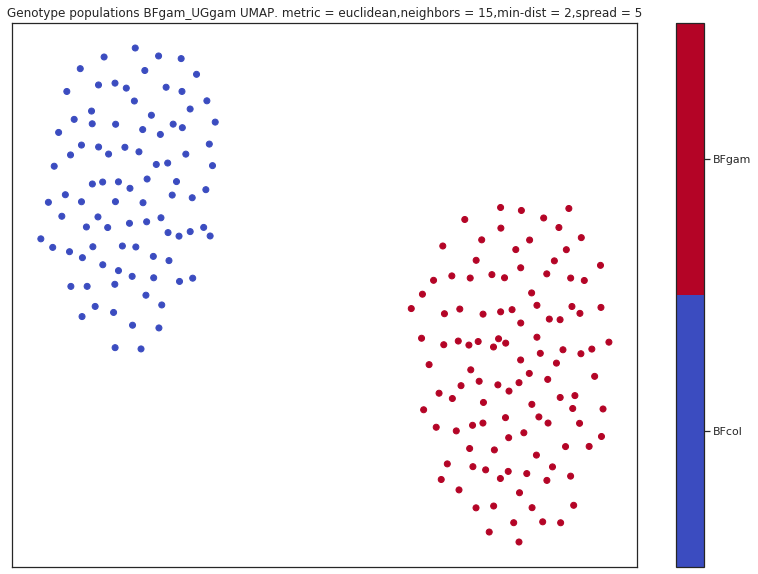

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 298)
2.) Filtering Rare Allels
Number of SNPs removed =  3444038
Retaining =  207682
3.) Performing LD Pruning
iteration 1 retaining 48930 removing 158752 variants
iteration 2 retaining 45682 removing 3248 variants
iteration 3 retaining 45447 removing 235 variants
Retained Haplotype Matrix =  (45447, 298)
Retained Positions Matrix =  (45447,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

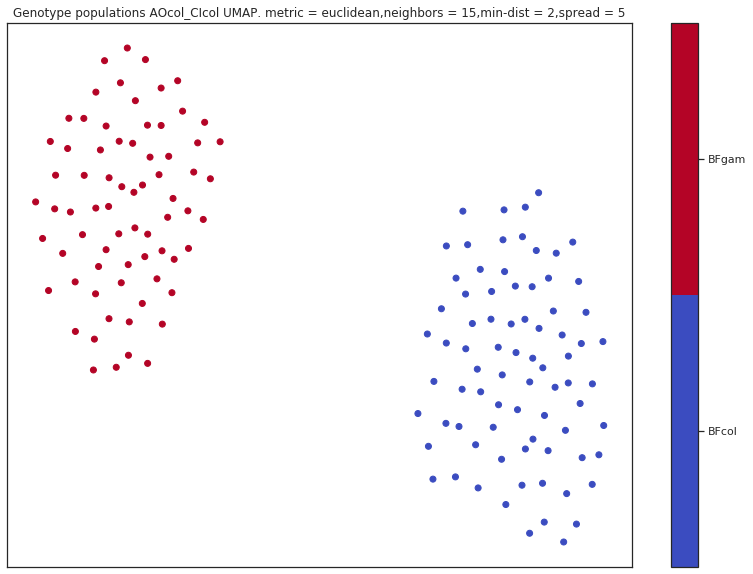

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 356)
2.) Filtering Rare Allels
Number of SNPs removed =  3446178
Retaining =  205542
3.) Performing LD Pruning
iteration 1 retaining 75267 removing 130275 variants
iteration 2 retaining 73103 removing 2164 variants
iteration 3 retaining 72991 removing 112 variants
Retained Haplotype Matrix =  (72991, 356)
Retained Positions Matrix =  (72991,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

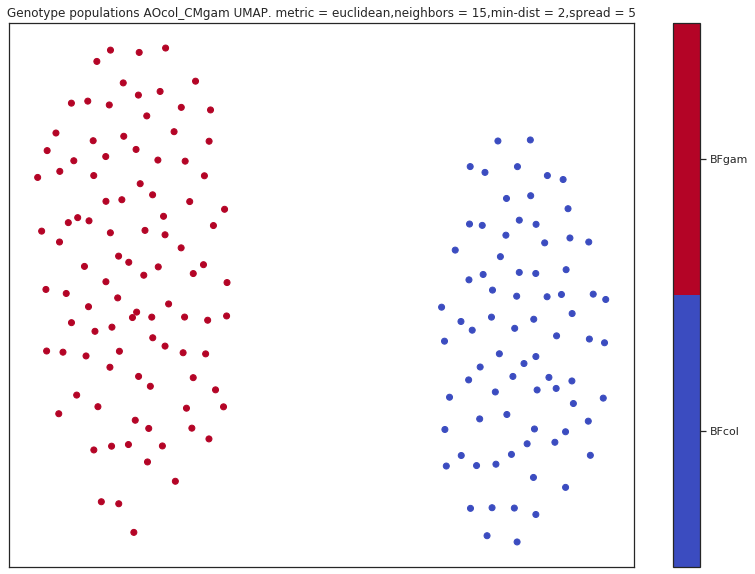

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3424104
Retaining =  227616
3.) Performing LD Pruning
iteration 1 retaining 22699 removing 204917 variants
iteration 2 retaining 20578 removing 2121 variants
iteration 3 retaining 20449 removing 129 variants
Retained Haplotype Matrix =  (20449, 294)
Retained Positions Matrix =  (20449,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

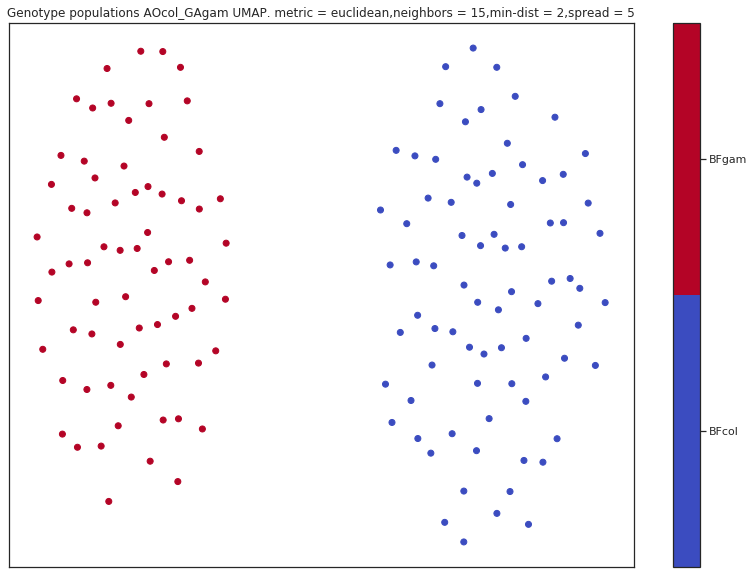

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 266)
2.) Filtering Rare Allels
Number of SNPs removed =  3452478
Retaining =  199242
3.) Performing LD Pruning
iteration 1 retaining 44316 removing 154926 variants
iteration 2 retaining 39599 removing 4717 variants
iteration 3 retaining 39142 removing 457 variants
Retained Haplotype Matrix =  (39142, 266)
Retained Positions Matrix =  (39142,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

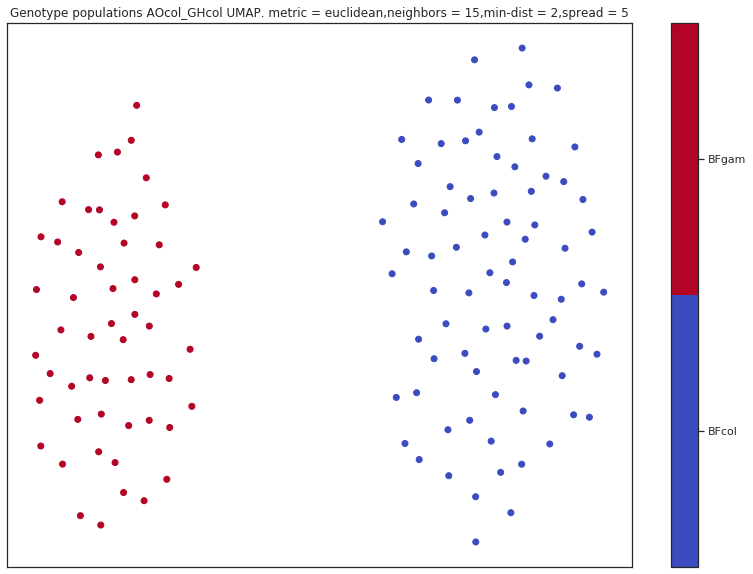

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 286)
2.) Filtering Rare Allels
Number of SNPs removed =  3444735
Retaining =  206985
3.) Performing LD Pruning
iteration 1 retaining 41127 removing 165858 variants
iteration 2 retaining 38210 removing 2917 variants
iteration 3 retaining 38022 removing 188 variants
Retained Haplotype Matrix =  (38022, 286)
Retained Positions Matrix =  (38022,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

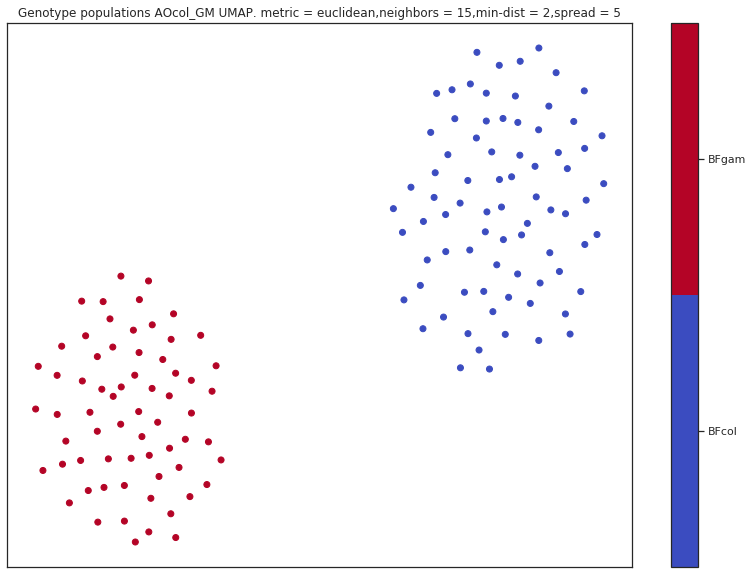

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 236)
2.) Filtering Rare Allels
Number of SNPs removed =  3449962
Retaining =  201758
3.) Performing LD Pruning
iteration 1 retaining 38262 removing 163496 variants
iteration 2 retaining 32847 removing 5415 variants
iteration 3 retaining 32237 removing 610 variants
Retained Haplotype Matrix =  (32237, 236)
Retained Positions Matrix =  (32237,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

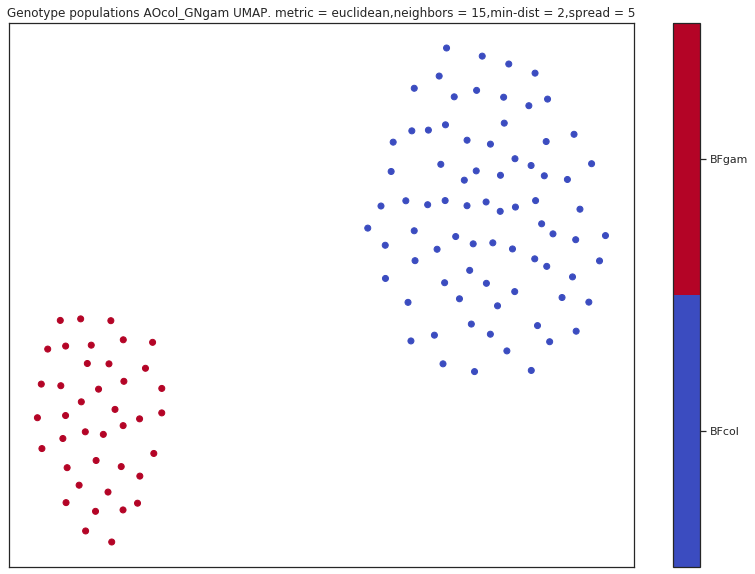

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 338)
2.) Filtering Rare Allels
Number of SNPs removed =  3441668
Retaining =  210052
3.) Performing LD Pruning
iteration 1 retaining 68074 removing 141978 variants
iteration 2 retaining 65294 removing 2780 variants
iteration 3 retaining 65110 removing 184 variants
Retained Haplotype Matrix =  (65110, 338)
Retained Positions Matrix =  (65110,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

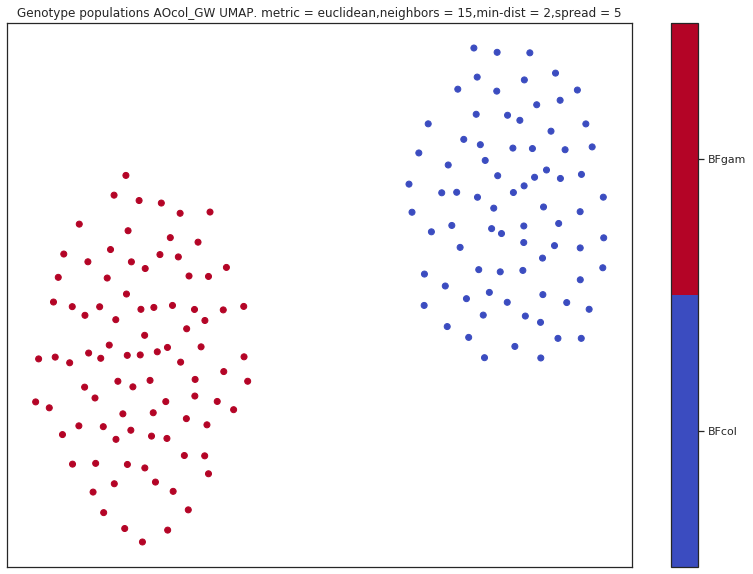

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3443182
Retaining =  208538
3.) Performing LD Pruning
iteration 1 retaining 9030 removing 199508 variants
iteration 2 retaining 4057 removing 4973 variants
iteration 3 retaining 2996 removing 1061 variants
Retained Haplotype Matrix =  (2996, 252)
Retained Positions Matrix =  (2996,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

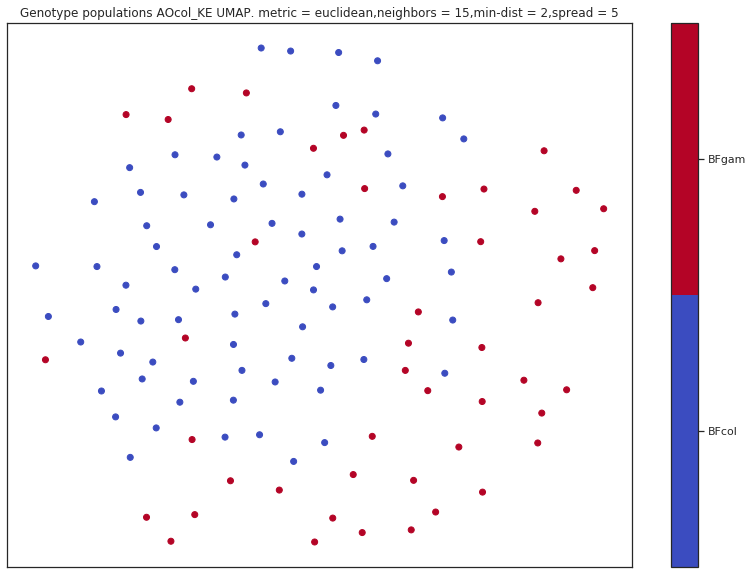

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 380)
2.) Filtering Rare Allels
Number of SNPs removed =  3441526
Retaining =  210194
3.) Performing LD Pruning
iteration 1 retaining 75933 removing 134261 variants
iteration 2 retaining 74636 removing 1297 variants
iteration 3 retaining 74577 removing 59 variants
Retained Haplotype Matrix =  (74577, 380)
Retained Positions Matrix =  (74577,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

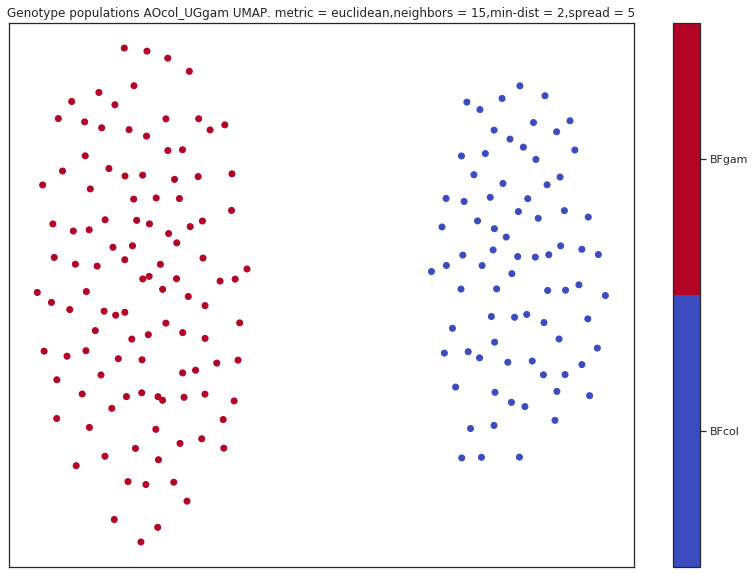

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 342)
2.) Filtering Rare Allels
Number of SNPs removed =  3450009
Retaining =  201711
3.) Performing LD Pruning
iteration 1 retaining 106273 removing 95438 variants
iteration 2 retaining 105765 removing 508 variants
iteration 3 retaining 105746 removing 19 variants
Retained Haplotype Matrix =  (105746, 342)
Retained Positions Matrix =  (105746,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

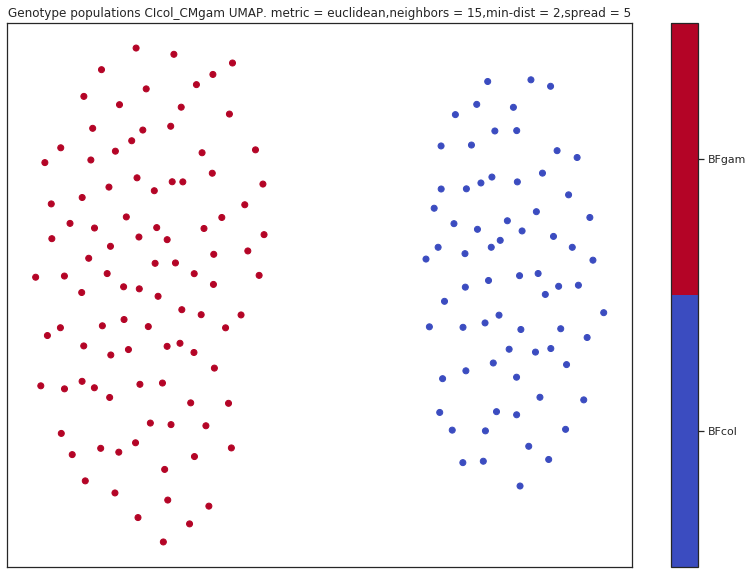

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3419651
Retaining =  232069
3.) Performing LD Pruning
iteration 1 retaining 39329 removing 192740 variants
iteration 2 retaining 36213 removing 3116 variants
iteration 3 retaining 35981 removing 232 variants
Retained Haplotype Matrix =  (35981, 280)
Retained Positions Matrix =  (35981,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

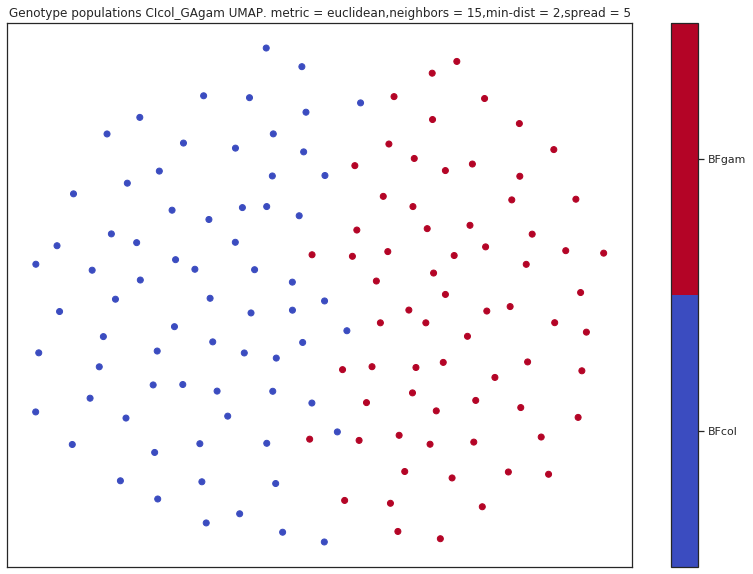

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3437390
Retaining =  214330
3.) Performing LD Pruning
iteration 1 retaining 69616 removing 144714 variants
iteration 2 retaining 68202 removing 1414 variants
iteration 3 retaining 68135 removing 67 variants
Retained Haplotype Matrix =  (68135, 252)
Retained Positions Matrix =  (68135,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

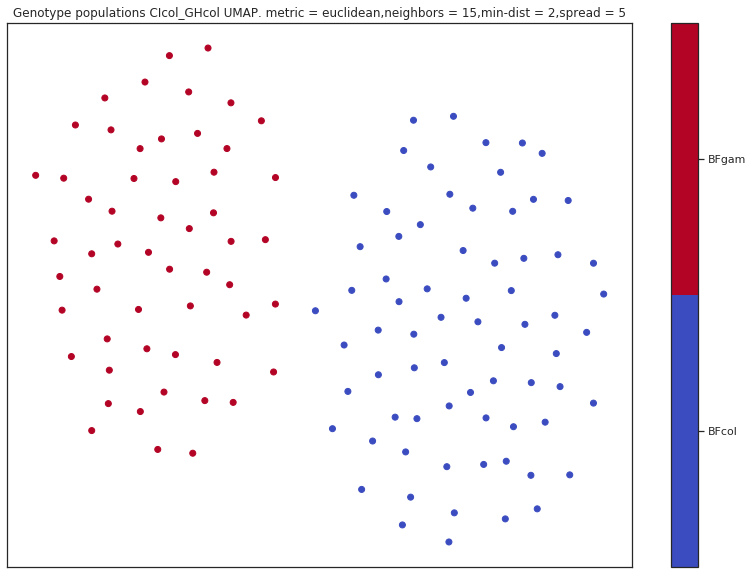

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 272)
2.) Filtering Rare Allels
Number of SNPs removed =  3435319
Retaining =  216401
3.) Performing LD Pruning
iteration 1 retaining 74250 removing 142151 variants
iteration 2 retaining 72881 removing 1369 variants
iteration 3 retaining 72828 removing 53 variants
Retained Haplotype Matrix =  (72828, 272)
Retained Positions Matrix =  (72828,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

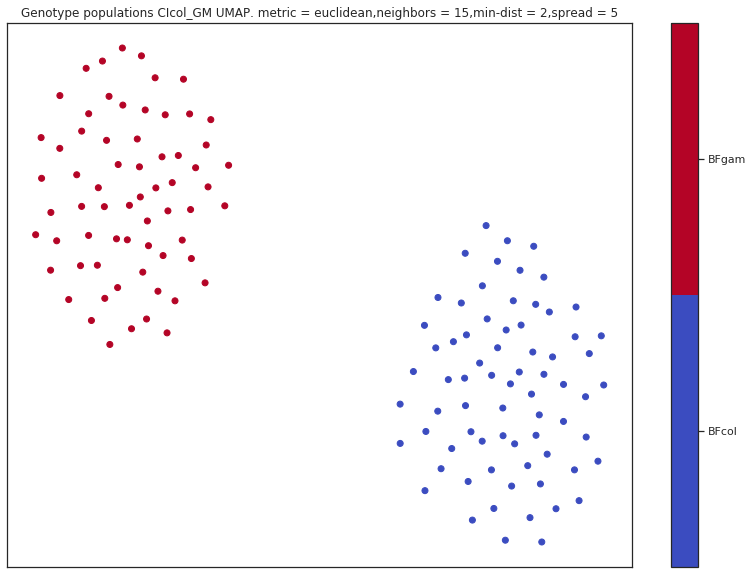

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 222)
2.) Filtering Rare Allels
Number of SNPs removed =  3447416
Retaining =  204304
3.) Performing LD Pruning
iteration 1 retaining 81719 removing 122585 variants
iteration 2 retaining 77689 removing 4030 variants
iteration 3 retaining 77339 removing 350 variants
Retained Haplotype Matrix =  (77339, 222)
Retained Positions Matrix =  (77339,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

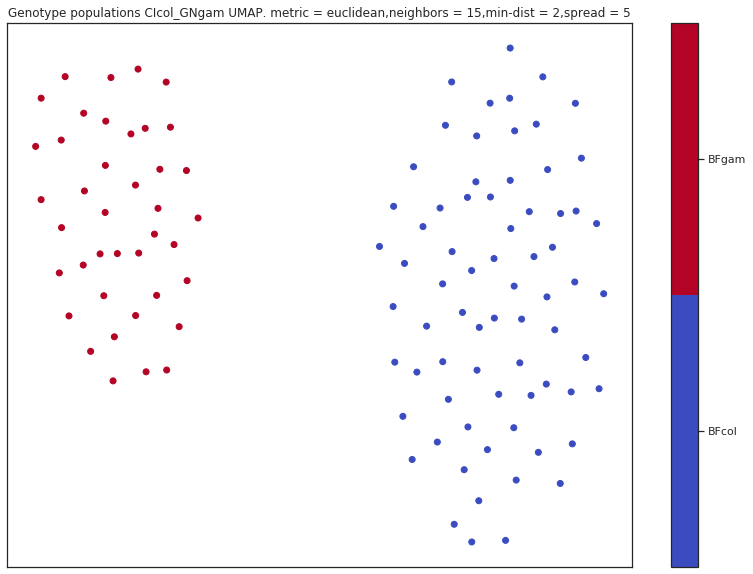

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 324)
2.) Filtering Rare Allels
Number of SNPs removed =  3443481
Retaining =  208239
3.) Performing LD Pruning
iteration 1 retaining 96583 removing 111656 variants
iteration 2 retaining 96332 removing 251 variants
iteration 3 retaining 96325 removing 7 variants
Retained Haplotype Matrix =  (96325, 324)
Retained Positions Matrix =  (96325,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

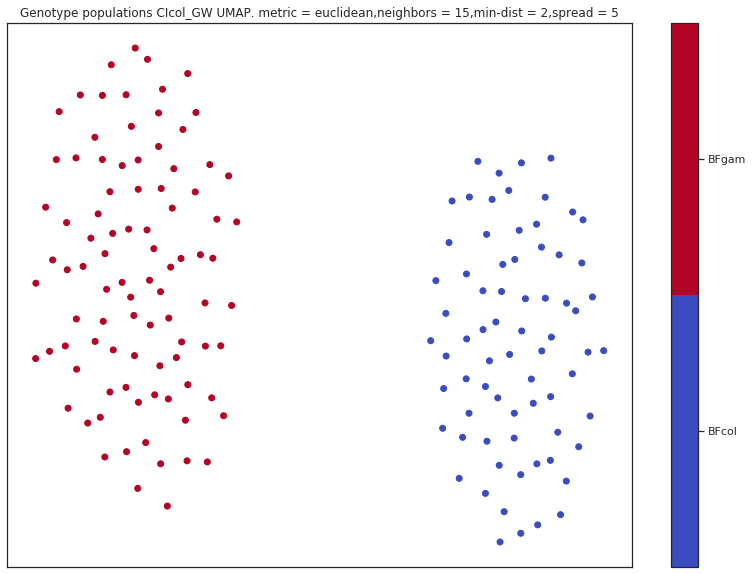

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 238)
2.) Filtering Rare Allels
Number of SNPs removed =  3444457
Retaining =  207263
3.) Performing LD Pruning
iteration 1 retaining 16995 removing 190268 variants
iteration 2 retaining 6410 removing 10585 variants
iteration 3 retaining 3769 removing 2641 variants
Retained Haplotype Matrix =  (3769, 238)
Retained Positions Matrix =  (3769,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

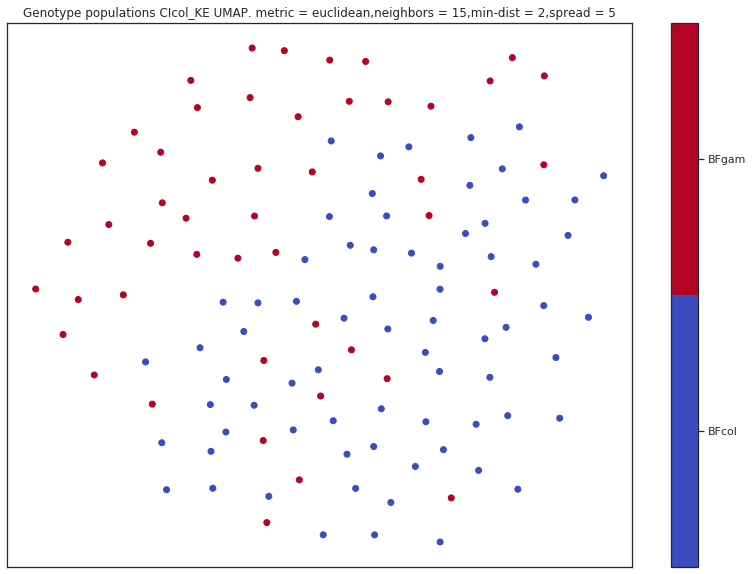

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3446117
Retaining =  205603
3.) Performing LD Pruning
iteration 1 retaining 104288 removing 101315 variants
iteration 2 retaining 103964 removing 324 variants
iteration 3 retaining 103954 removing 10 variants
Retained Haplotype Matrix =  (103954, 366)
Retained Positions Matrix =  (103954,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

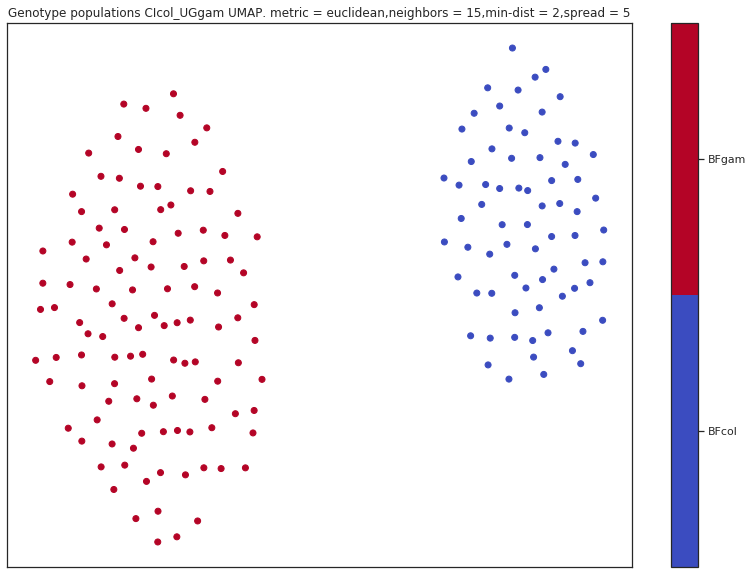

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 338)
2.) Filtering Rare Allels
Number of SNPs removed =  3429246
Retaining =  222474
3.) Performing LD Pruning
iteration 1 retaining 66922 removing 155552 variants
iteration 2 retaining 65902 removing 1020 variants
iteration 3 retaining 65872 removing 30 variants
Retained Haplotype Matrix =  (65872, 338)
Retained Positions Matrix =  (65872,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

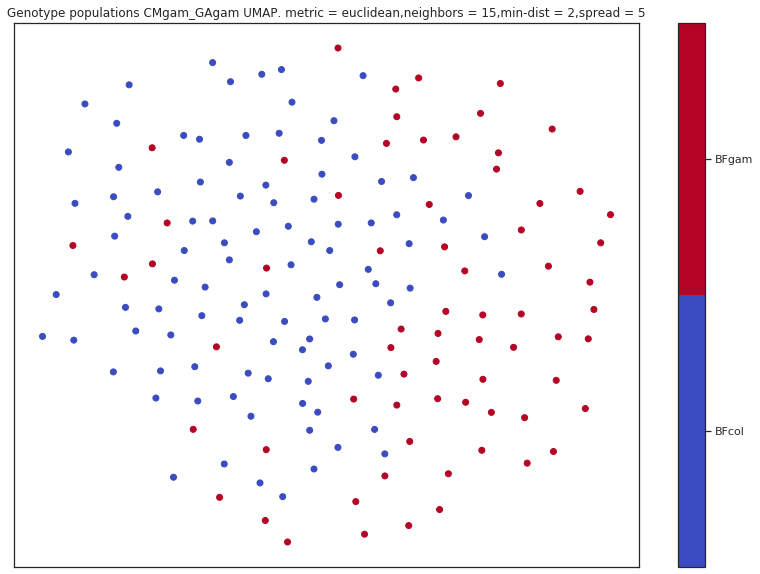

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 310)
2.) Filtering Rare Allels
Number of SNPs removed =  3447274
Retaining =  204446
3.) Performing LD Pruning
iteration 1 retaining 111297 removing 93149 variants
iteration 2 retaining 110338 removing 959 variants
iteration 3 retaining 110289 removing 49 variants
Retained Haplotype Matrix =  (110289, 310)
Retained Positions Matrix =  (110289,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

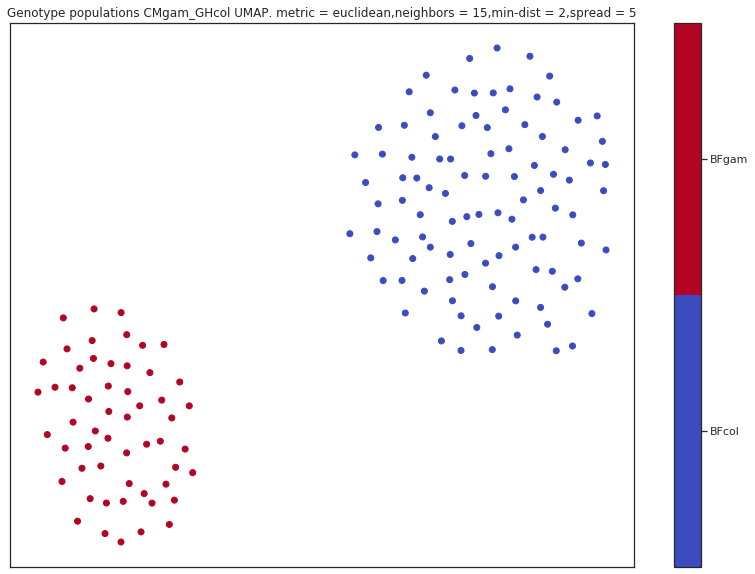

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 330)
2.) Filtering Rare Allels
Number of SNPs removed =  3444212
Retaining =  207508
3.) Performing LD Pruning
iteration 1 retaining 104436 removing 103072 variants
iteration 2 retaining 103763 removing 673 variants
iteration 3 retaining 103752 removing 11 variants
Retained Haplotype Matrix =  (103752, 330)
Retained Positions Matrix =  (103752,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

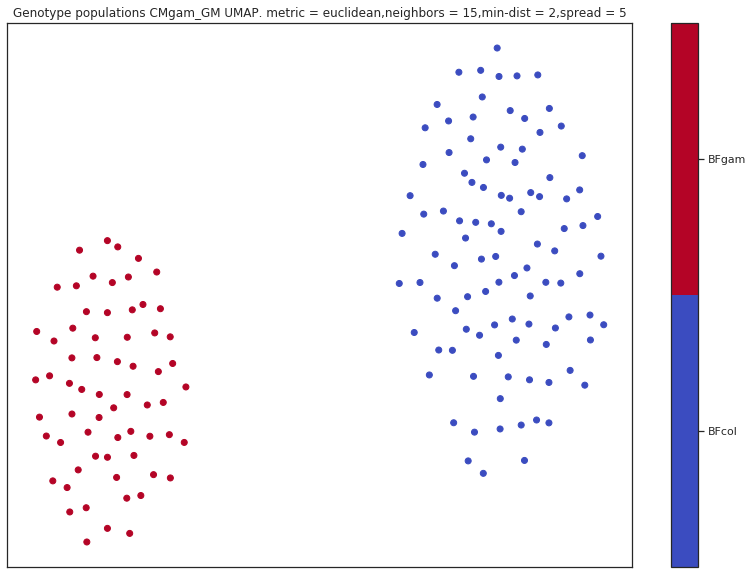

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3442081
Retaining =  209639
3.) Performing LD Pruning
iteration 1 retaining 114387 removing 95252 variants
iteration 2 retaining 113306 removing 1081 variants
iteration 3 retaining 113259 removing 47 variants
Retained Haplotype Matrix =  (113259, 280)
Retained Positions Matrix =  (113259,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

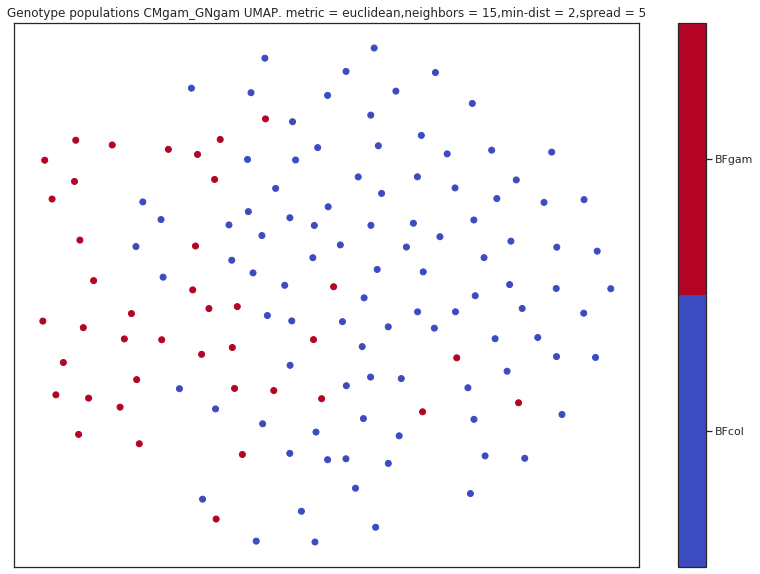

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 382)
2.) Filtering Rare Allels
Number of SNPs removed =  3449090
Retaining =  202630
3.) Performing LD Pruning
iteration 1 retaining 115494 removing 87136 variants
iteration 2 retaining 115330 removing 164 variants
iteration 3 retaining 115328 removing 2 variants
Retained Haplotype Matrix =  (115328, 382)
Retained Positions Matrix =  (115328,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

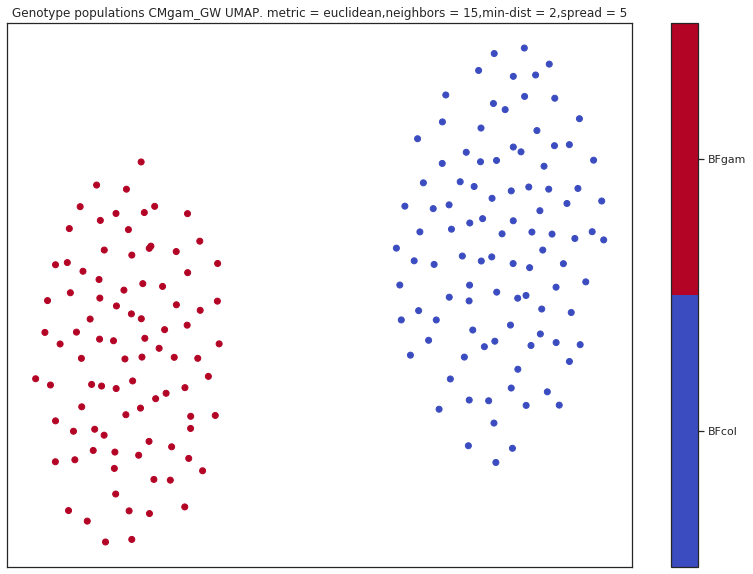

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 296)
2.) Filtering Rare Allels
Number of SNPs removed =  3446934
Retaining =  204786
3.) Performing LD Pruning
iteration 1 retaining 47326 removing 157460 variants
iteration 2 retaining 35917 removing 11409 variants
iteration 3 retaining 33068 removing 2849 variants
Retained Haplotype Matrix =  (33068, 296)
Retained Positions Matrix =  (33068,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

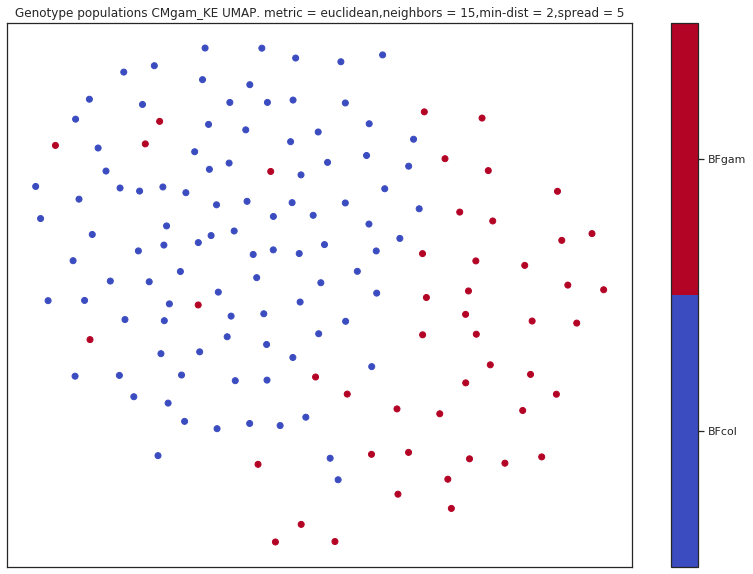

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 424)
2.) Filtering Rare Allels
Number of SNPs removed =  3448730
Retaining =  202990
3.) Performing LD Pruning
iteration 1 retaining 114407 removing 88583 variants
iteration 2 retaining 114354 removing 53 variants
iteration 3 retaining 114354 removing 0 variants
Retained Haplotype Matrix =  (114354, 424)
Retained Positions Matrix =  (114354,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

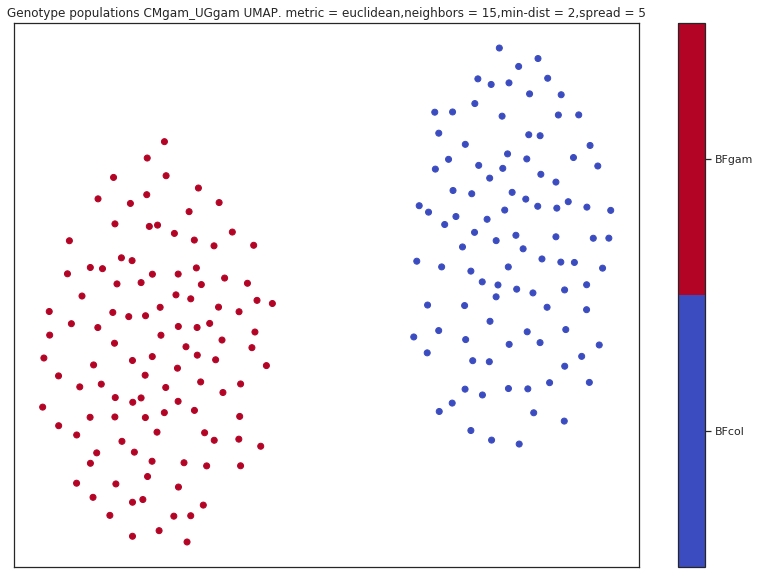

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 248)
2.) Filtering Rare Allels
Number of SNPs removed =  3426812
Retaining =  224908
3.) Performing LD Pruning
iteration 1 retaining 33505 removing 191403 variants
iteration 2 retaining 28345 removing 5160 variants
iteration 3 retaining 27722 removing 623 variants
Retained Haplotype Matrix =  (27722, 248)
Retained Positions Matrix =  (27722,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

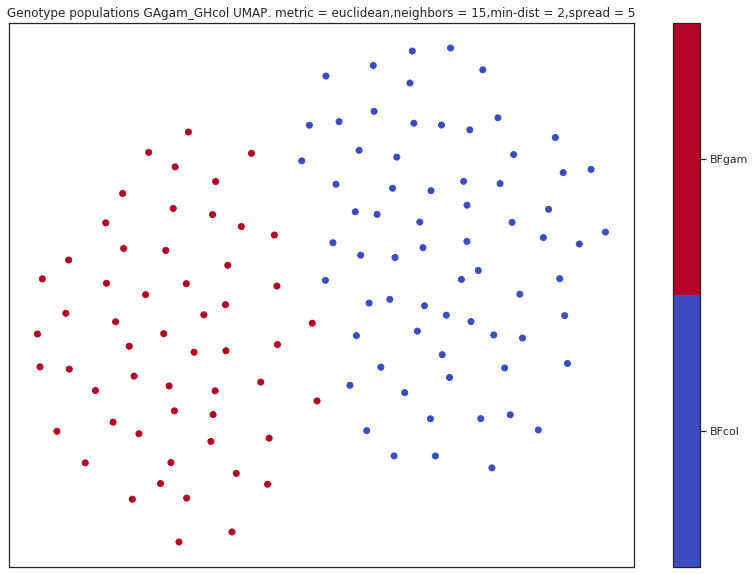

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 268)
2.) Filtering Rare Allels
Number of SNPs removed =  3423297
Retaining =  228423
3.) Performing LD Pruning
iteration 1 retaining 30635 removing 197788 variants
iteration 2 retaining 27990 removing 2645 variants
iteration 3 retaining 27850 removing 140 variants
Retained Haplotype Matrix =  (27850, 268)
Retained Positions Matrix =  (27850,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

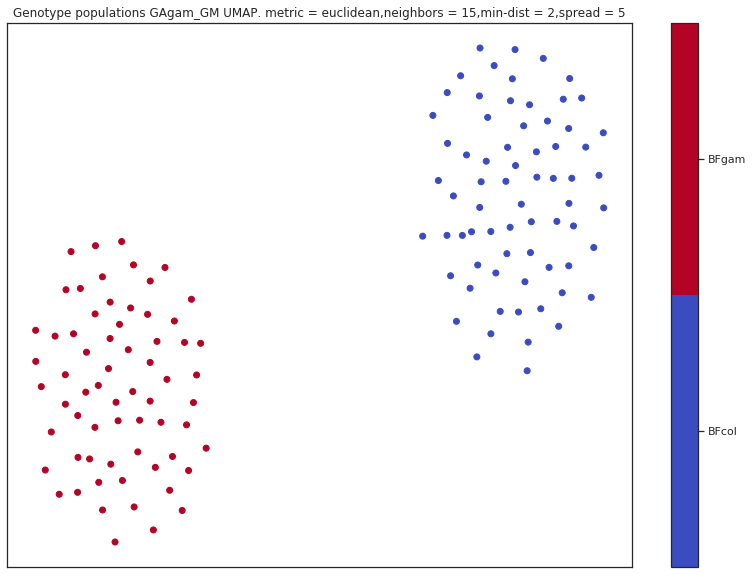

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 218)
2.) Filtering Rare Allels
Number of SNPs removed =  3422444
Retaining =  229276
3.) Performing LD Pruning
iteration 1 retaining 26620 removing 202656 variants
iteration 2 retaining 21415 removing 5205 variants
iteration 3 retaining 20743 removing 672 variants
Retained Haplotype Matrix =  (20743, 218)
Retained Positions Matrix =  (20743,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


<Figure size 432x288 with 0 Axes>

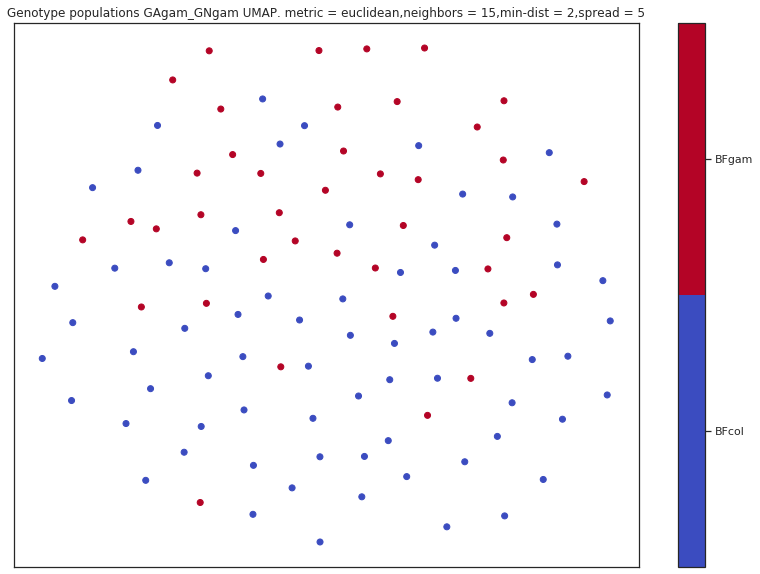

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1595: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

<Figure size 432x288 with 0 Axes>

In [100]:
'''
Pairwise analysis of all the 12 populations.
Total 66 combinations/analysis
Analysis includes:
1. Selecting a pair
2. Filtering the SNPs jointly
    - Mega Base Pair Selection
    - Rare Allele Filtering with MAF >= 5%
    - LD Pruning
    Store Filtering stats for all the pairs
3. Haplo to Geno and Train-Test Split
4. Classifying using Logistic Regression and LDA
5. Generating UMAP visualization
6. Dimensionality Reduction: Obtaining 20 UMAP components 
7. Training LR classifier on UMAP components
8. Dumping all the stats and evaluation scores into a dataframe
'''
# Storage Path
home = home = os.path.expanduser('~')
directory = os.path.join(home,'Imp_Research','Repository','Pairwise_Analysis')

# List of keys
keys = list(H.keys())
count = 0
pnames = []
psamples = []
pmaf = []
psnps_init = []
psnps_filt = []
accuracy_lr = []
f1score_lr = []
kappa_lr = []
accuracy_ulr = []
f1score_ulr = []
kappa_ulr = []

# Edited to do damage control ! 
for i in range(11):
    for j in range(i+1,12):
        count+=1
        pair_pos = POS_all[keys[i]]
        # 1. Pair Selection. Combining the populations. 
        pop1 = H[keys[i]]
        pop2 = H[keys[j]]
        pair_h = np.append(pop1,pop2,1)
        pname = f'{keys[i][:-3]}_{keys[j][:-3]}'
        pnames.append(pname)
        psnps_init.append(pair_h.shape[0])
        psamples.append(pair_h.shape[1]/2)
        print(f'{pname}\n{psnp_init}')
        
        # 2. Filtering (Using FilterSNP class) Taking window size 250 is quicker.
        fsnp = FilterSNP(pair_h,pair_pos)
        pair_h, pair_pos = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)
        psnps_filt.append(pair_h.shape[0])
        pmaf.append(fsnp._retained_maf)
#         ppos_filt = len(pair_pos)
        
        # 3. Haplo to Geno and Train-Test Split
        X = pair_h.T
        Xg = to_genotype(X)       #Genotype data
        pshape_g = Xg.shape
        Y = [0]*int(len(pop1[0])/2)
        Y.extend([1]*int(len(pop2[0])/2))
        Y = np.array(Y)
        x_train,x_test,y_train,y_test = train_test_split(Xg,Y,test_size = 0.2,stratify = Y,random_state= R_SEED)
        
        # 4. LR Classifier
        lr = LogisticRegression(n_jobs = -1)
        lr.fit(x_train,y_train)
        acc_lr, f1w_lr, kap_lr = evaluate_classifier(y_test,lr.predict(x_test))
        accuracy_lr.append(acc_lr)
        f1score_lr.append(f1w_lr)
        kappa_lr.append(kap_lr)
        
        # 5. Generate UMAP visualization
        UMAP_g = umap.UMAP(n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(Xg)
        sns.set(style='white')
        fig, ax = plt.subplots(1, figsize=(14, 10))
        plt.scatter(UMAP_g[:, 0],UMAP_g[:, 1],c=Y,cmap='coolwarm')
        plt.setp(ax, xticks=[], yticks=[])
        cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
        cbar.set_ticks(np.arange(2))
        cbar.set_ticklabels(populations)
        plt.title(f'Genotype populations {pname} UMAP. Metric = jaccard,neighbors = 15,min-dist = 2,spread = 5');
        figname = f'{count}_{pname}_umap.png'
        path = os.path.join(directory,'pairwise_jaccard_plots',figname)
        plt.savefig(path,dpi=100)
        plt.show() 
        # calling plt.show() before saving clears all the graph
        
        # 6. Dimensionality Reduction: Obtaining 20 umap components
        UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit(x_train)
        x_train = UMAP_g.embedding_
        x_test = UMAP_g.transform(x_test)
        
        # 7. Training LR on UMAP components
        ulr = LogisticRegression(n_jobs = -1)
        ulr.fit(x_train,y_train)
        acc_ulr, f1w_ulr, kap_ulr = evaluate_classifier(y_test,ulr.predict(x_test))
        accuracy_ulr.append(acc_ulr)
        f1score_ulr.append(f1w_ulr)
        kappa_ulr.append(kap_ulr)
    
pairwise_analysisJ = pd.DataFrame()
pairwise_analysisJ['Count'] = range(1,len(pnames)+1)
pairwise_analysisJ['Population_pair'] = pnames
pairwise_analysisJ['Samples'] = psamples
pairwise_analysisJ['Initial_SNP'] = psnps_init
pairwise_analysisJ['MAF_filter_SNP'] = pmaf
pairwise_analysisJ['Filtered_SNP'] = psnps_filt
pairwise_analysisJ['LR_accuracy'] = accuracy_lr
pairwise_analysisJ['LR_f1score'] = f1score_lr
pairwise_analysisJ['LR_kappa'] = kappa_lr
pairwise_analysisJ['UMAP_LR_accuracy'] = accuracy_ulr
pairwise_analysisJ['UMAP_LR_f1score'] = f1score_ulr
pairwise_analysisJ['UMAP_LR_kappa'] = kappa_ulr

# Errored at i = 5, j = 8, count = 48, pname = 'GAgam_GNgam'
# status: UMAP saved but no data. Also 20 components exceeded some samples.
# because I messed up (-_-) took test size 80% (-_-)(*_*)


print(pairwise_analysisJ)
path = os.path.join(directory,'Pairwise_Analysis_Stats_Jaccard_UMAP.csv')
pairwise_analysisJ.to_csv(path,index= False)

In [110]:
pnames

['BFcol_UGgam', 'BFgam_UGgam', 'AOcol_UGgam', 'CIcol_UGgam', 'CMgam_UGgam']

BFcol_BFgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 117897 removing 85031 variants
iteration 2 retaining 117005 removing 892 variants
iteration 3 retaining 116947 removing 58 variants
Retained Haplotype Matrix =  (116947, 334)
Retained Positions Matrix =  (116947,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


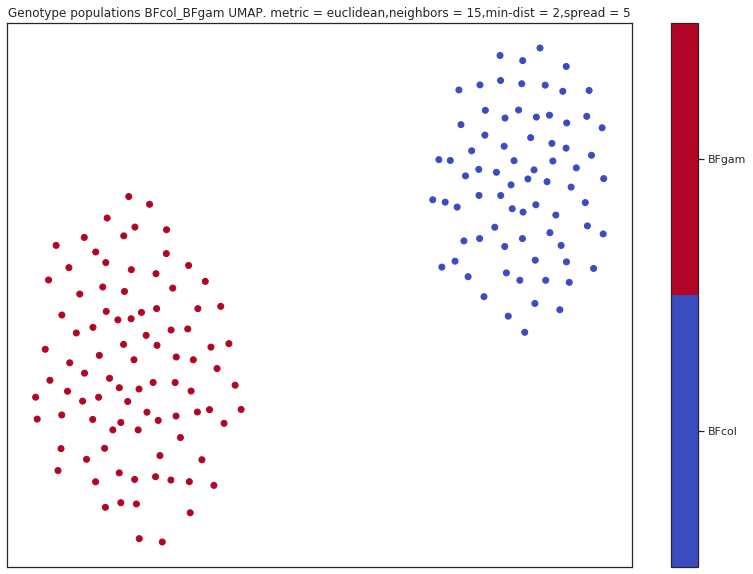

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 306)
2.) Filtering Rare Allels
Number of SNPs removed =  3455502
Retaining =  196218
3.) Performing LD Pruning
iteration 1 retaining 65183 removing 131035 variants
iteration 2 retaining 61723 removing 3460 variants
iteration 3 retaining 61477 removing 246 variants
Retained Haplotype Matrix =  (61477, 306)
Retained Positions Matrix =  (61477,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


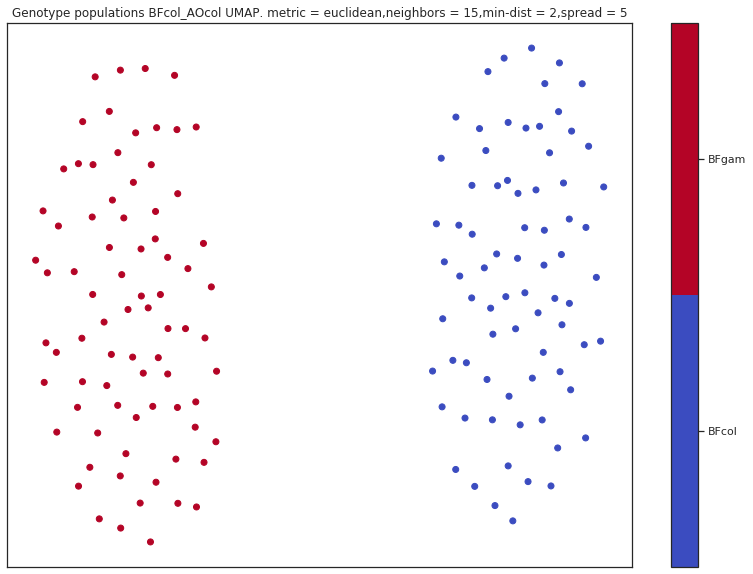

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 292)
2.) Filtering Rare Allels
Number of SNPs removed =  3444868
Retaining =  206852
3.) Performing LD Pruning
iteration 1 retaining 92739 removing 114113 variants
iteration 2 retaining 91952 removing 787 variants
iteration 3 retaining 91924 removing 28 variants
Retained Haplotype Matrix =  (91924, 292)
Retained Positions Matrix =  (91924,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


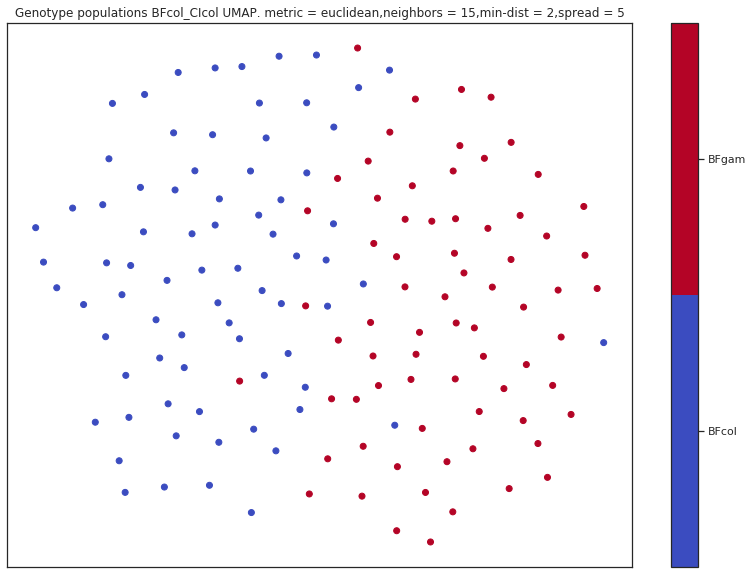

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 350)
2.) Filtering Rare Allels
Number of SNPs removed =  3450888
Retaining =  200832
3.) Performing LD Pruning
iteration 1 retaining 118766 removing 82066 variants
iteration 2 retaining 117913 removing 853 variants
iteration 3 retaining 117855 removing 58 variants
Retained Haplotype Matrix =  (117855, 350)
Retained Positions Matrix =  (117855,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


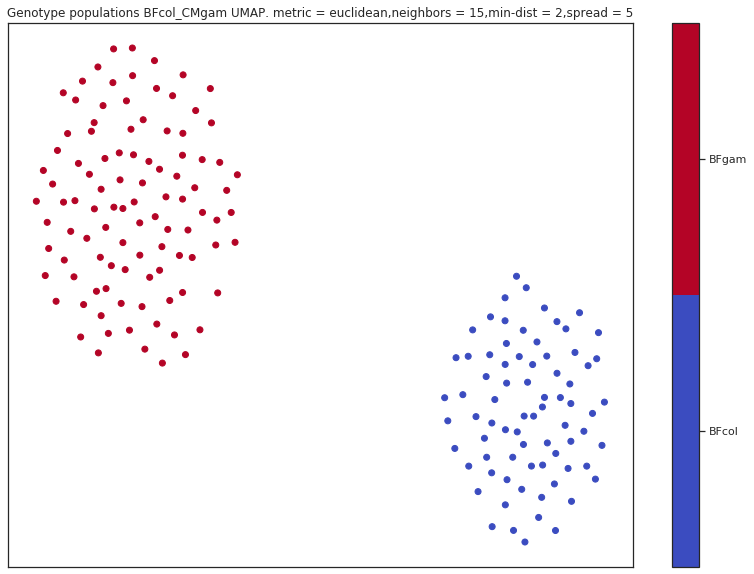

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 288)
2.) Filtering Rare Allels
Number of SNPs removed =  3433494
Retaining =  218226
3.) Performing LD Pruning
iteration 1 retaining 58599 removing 159627 variants
iteration 2 retaining 52813 removing 5786 variants
iteration 3 retaining 52373 removing 440 variants
Retained Haplotype Matrix =  (52373, 288)
Retained Positions Matrix =  (52373,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


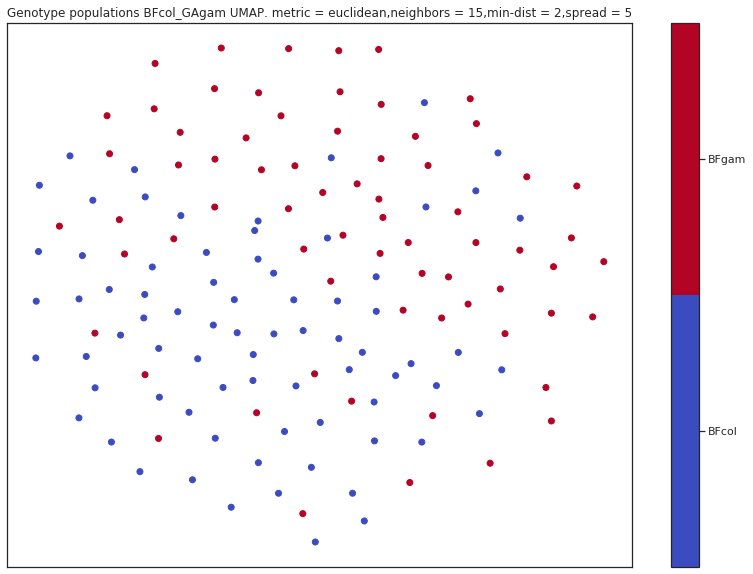

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 260)
2.) Filtering Rare Allels
Number of SNPs removed =  3442525
Retaining =  209195
3.) Performing LD Pruning
iteration 1 retaining 100559 removing 108636 variants
iteration 2 retaining 99841 removing 718 variants
iteration 3 retaining 99782 removing 59 variants
Retained Haplotype Matrix =  (99782, 260)
Retained Positions Matrix =  (99782,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


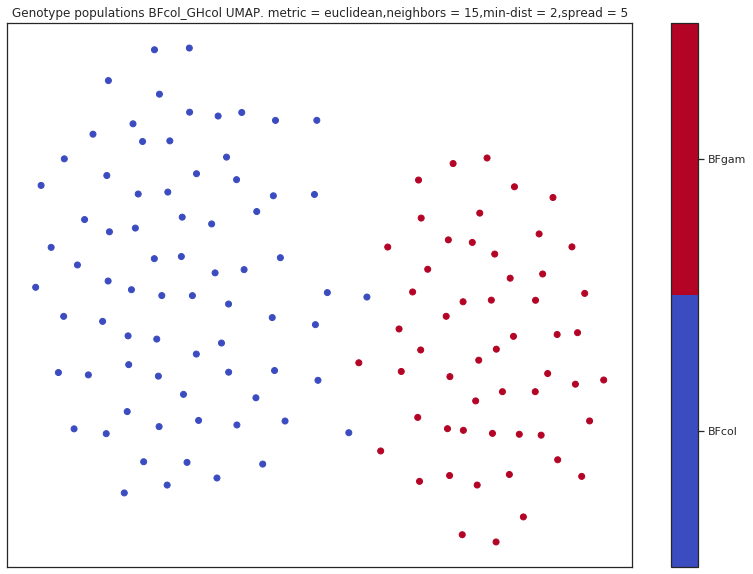

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3437772
Retaining =  213948
3.) Performing LD Pruning
iteration 1 retaining 98127 removing 115821 variants
iteration 2 retaining 95281 removing 2846 variants
iteration 3 retaining 95080 removing 201 variants
Retained Haplotype Matrix =  (95080, 280)
Retained Positions Matrix =  (95080,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


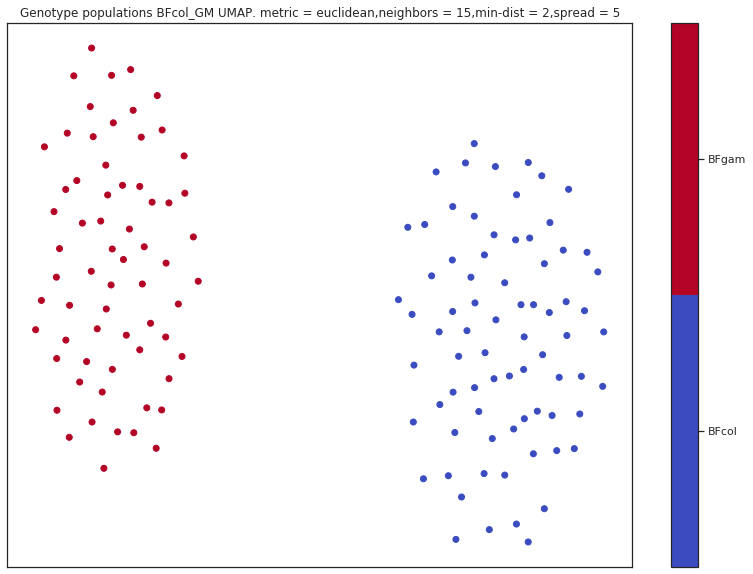

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 230)
2.) Filtering Rare Allels
Number of SNPs removed =  3451347
Retaining =  200373
3.) Performing LD Pruning
iteration 1 retaining 112974 removing 87399 variants
iteration 2 retaining 111236 removing 1738 variants
iteration 3 retaining 111014 removing 222 variants
Retained Haplotype Matrix =  (111014, 230)
Retained Positions Matrix =  (111014,)
iteration 2 retaining 111266 removing 222 variants
iteration 3 retaining 111254 removing 12 variants
Retained Haplotype Matrix =  (111254, 332)
Retained Positions Matrix =  (111254,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


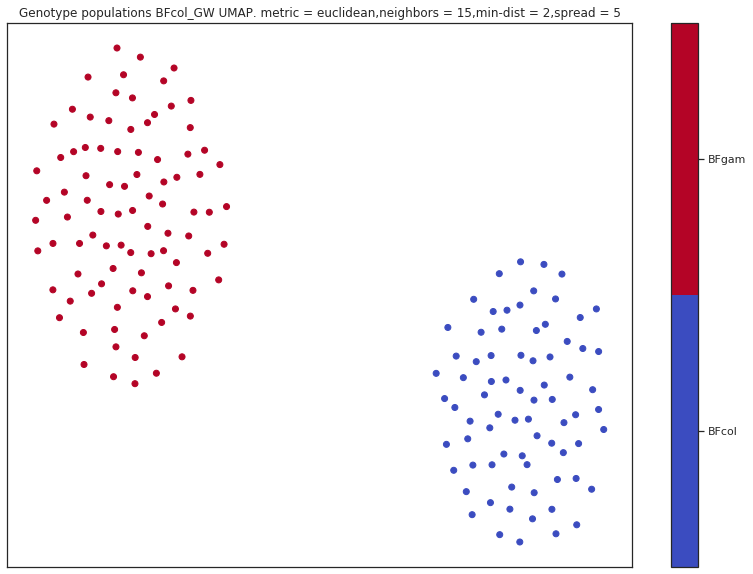

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 246)
2.) Filtering Rare Allels
Number of SNPs removed =  3459635
Retaining =  192085
3.) Performing LD Pruning
iteration 1 retaining 39963 removing 152122 variants
iteration 2 retaining 26214 removing 13749 variants
iteration 3 retaining 21719 removing 4495 variants
Retained Haplotype Matrix =  (21719, 246)
Retained Positions Matrix =  (21719,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


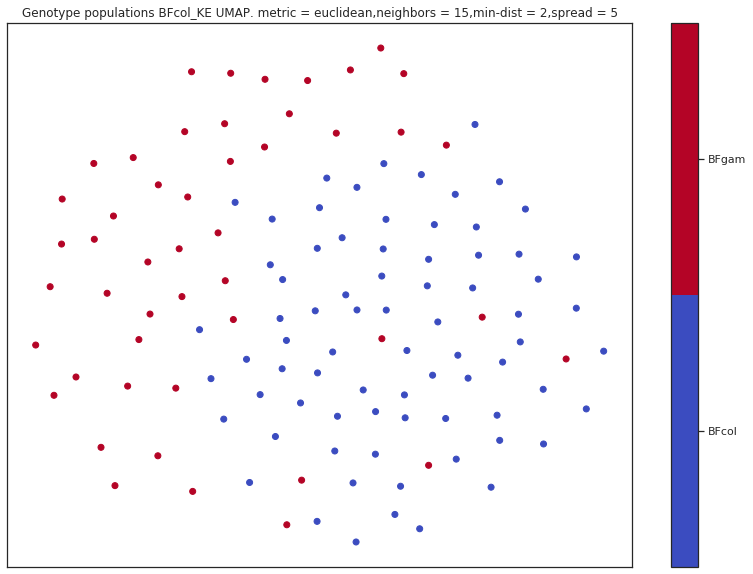

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 374)
2.) Filtering Rare Allels
Number of SNPs removed =  3446681
Retaining =  205039
3.) Performing LD Pruning
iteration 1 retaining 115321 removing 89718 variants
iteration 2 retaining 114508 removing 813 variants
iteration 3 retaining 114456 removing 52 variants
Retained Haplotype Matrix =  (114456, 374)
Retained Positions Matrix =  (114456,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


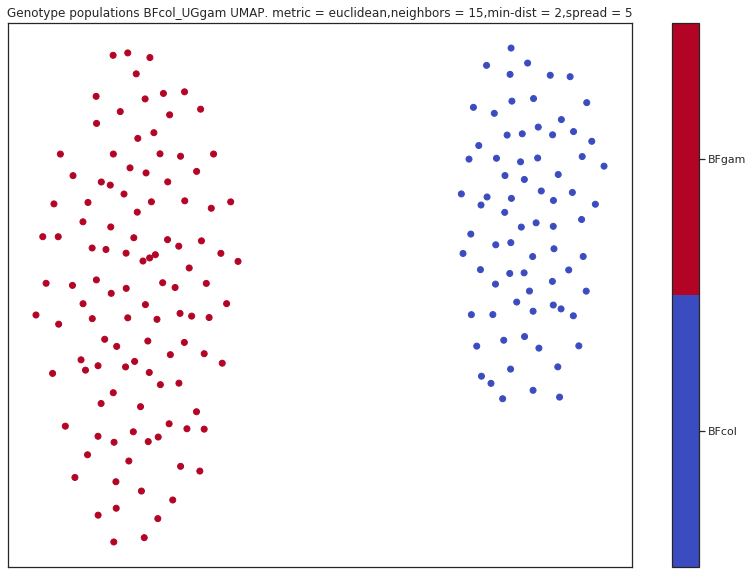

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 340)
2.) Filtering Rare Allels
Number of SNPs removed =  3444632
Retaining =  207088
3.) Performing LD Pruning
iteration 1 retaining 73062 removing 134026 variants
iteration 2 retaining 69575 removing 3487 variants
iteration 3 retaining 69339 removing 236 variants
Retained Haplotype Matrix =  (69339, 340)
Retained Positions Matrix =  (69339,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


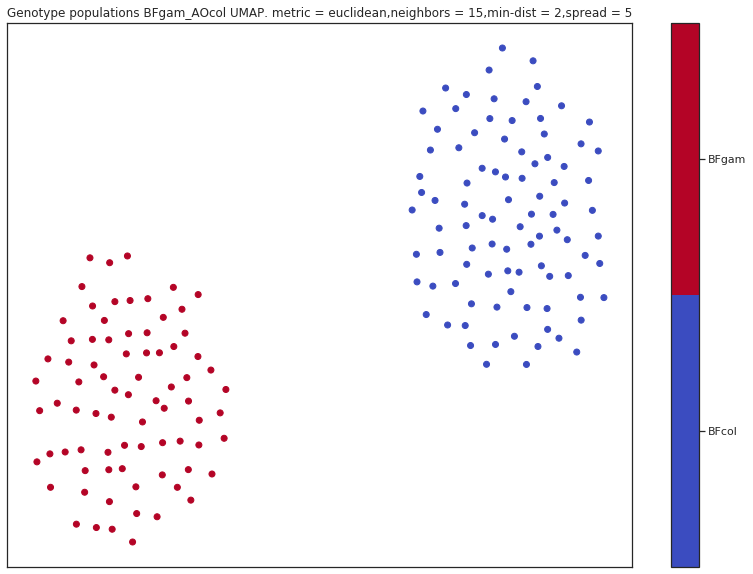

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 326)
2.) Filtering Rare Allels
Number of SNPs removed =  3447386
Retaining =  204334
3.) Performing LD Pruning
iteration 1 retaining 104147 removing 100187 variants
iteration 2 retaining 102738 removing 1409 variants
iteration 3 retaining 102654 removing 84 variants
Retained Haplotype Matrix =  (102654, 326)
Retained Positions Matrix =  (102654,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


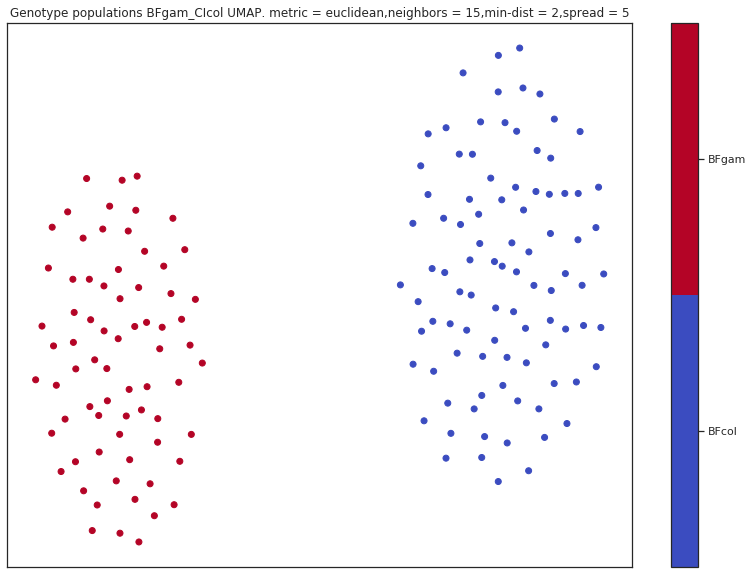

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 384)
2.) Filtering Rare Allels
Number of SNPs removed =  3449831
Retaining =  201889
3.) Performing LD Pruning
iteration 1 retaining 114364 removing 87525 variants
iteration 2 retaining 113491 removing 873 variants
iteration 3 retaining 113461 removing 30 variants
Retained Haplotype Matrix =  (113461, 384)
Retained Positions Matrix =  (113461,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


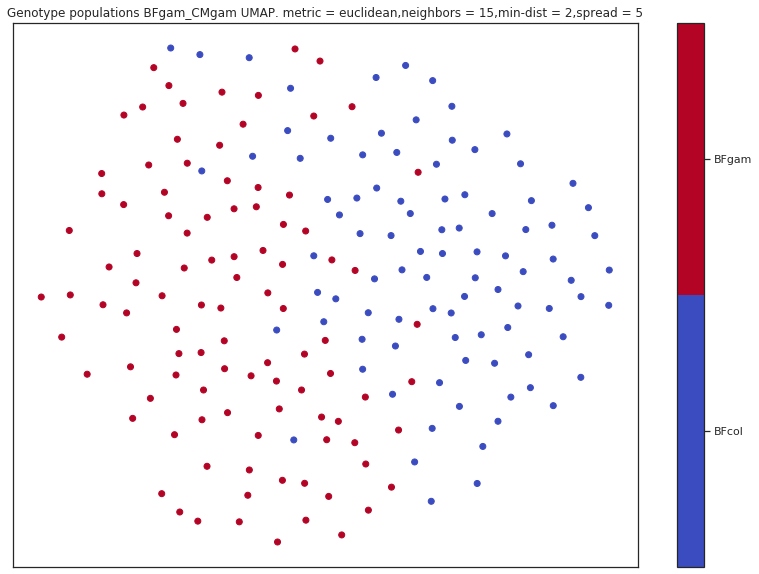

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 322)
2.) Filtering Rare Allels
Number of SNPs removed =  3435732
Retaining =  215988
3.) Performing LD Pruning
iteration 1 retaining 63966 removing 152022 variants
iteration 2 retaining 59327 removing 4639 variants
iteration 3 retaining 59156 removing 171 variants
Retained Haplotype Matrix =  (59156, 322)
Retained Positions Matrix =  (59156,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


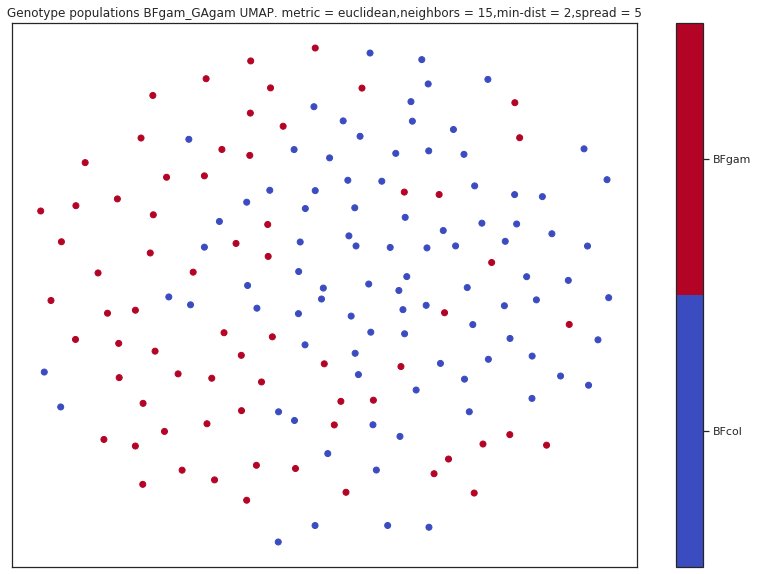

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3444547
Retaining =  207173
3.) Performing LD Pruning
iteration 1 retaining 109988 removing 97185 variants
iteration 2 retaining 108493 removing 1495 variants
iteration 3 retaining 108392 removing 101 variants
Retained Haplotype Matrix =  (108392, 294)
Retained Positions Matrix =  (108392,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


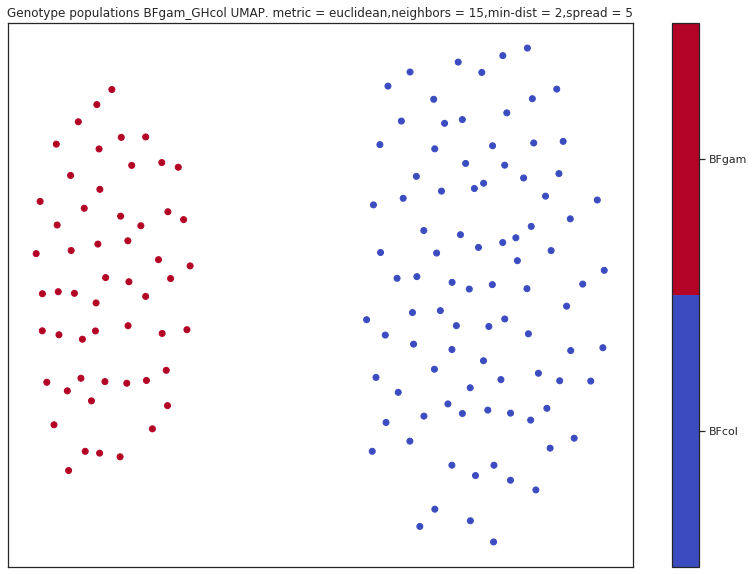

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 314)
2.) Filtering Rare Allels
Number of SNPs removed =  3441219
Retaining =  210501
3.) Performing LD Pruning
iteration 1 retaining 102758 removing 107743 variants
iteration 2 retaining 100152 removing 2606 variants
iteration 3 retaining 99979 removing 173 variants
Retained Haplotype Matrix =  (99979, 314)
Retained Positions Matrix =  (99979,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


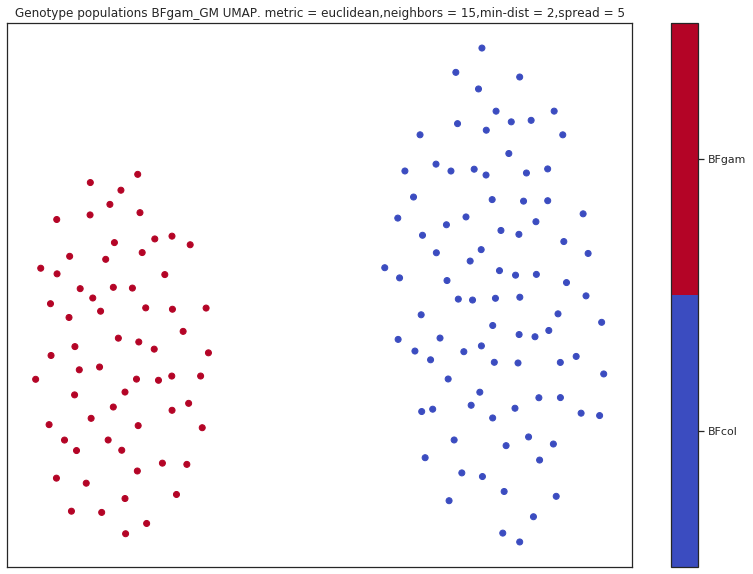

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 264)
2.) Filtering Rare Allels
Number of SNPs removed =  3448273
Retaining =  203447
3.) Performing LD Pruning
iteration 1 retaining 107740 removing 95707 variants
iteration 2 retaining 105927 removing 1813 variants
iteration 3 retaining 105816 removing 111 variants
Retained Haplotype Matrix =  (105816, 264)
Retained Positions Matrix =  (105816,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


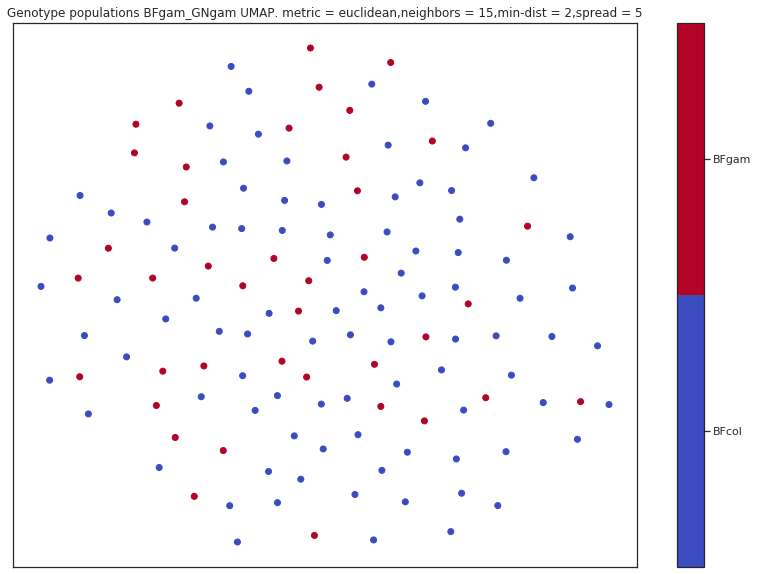

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3447387
Retaining =  204333
3.) Performing LD Pruning
iteration 1 retaining 114490 removing 89843 variants
iteration 2 retaining 113970 removing 520 variants
iteration 3 retaining 113954 removing 16 variants
Retained Haplotype Matrix =  (113954, 366)
Retained Positions Matrix =  (113954,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


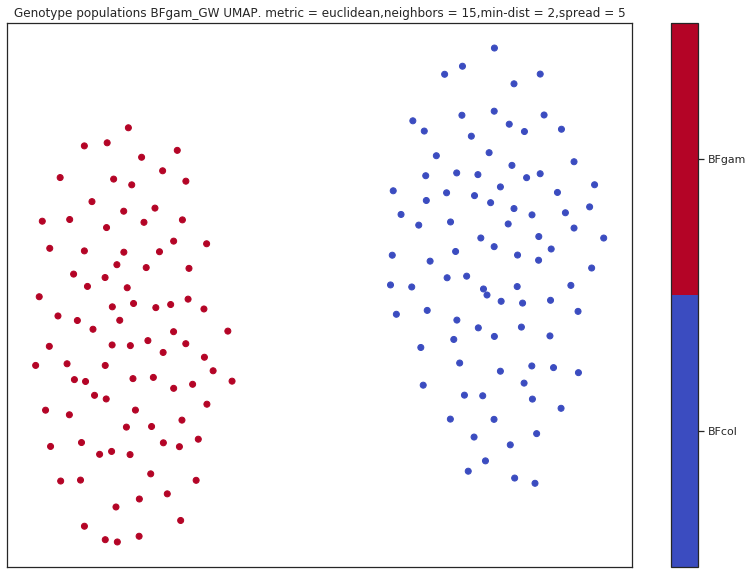

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3446317
Retaining =  205403
3.) Performing LD Pruning
iteration 1 retaining 49687 removing 155716 variants
iteration 2 retaining 39225 removing 10462 variants
iteration 3 retaining 37312 removing 1913 variants
Retained Haplotype Matrix =  (37312, 280)
Retained Positions Matrix =  (37312,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


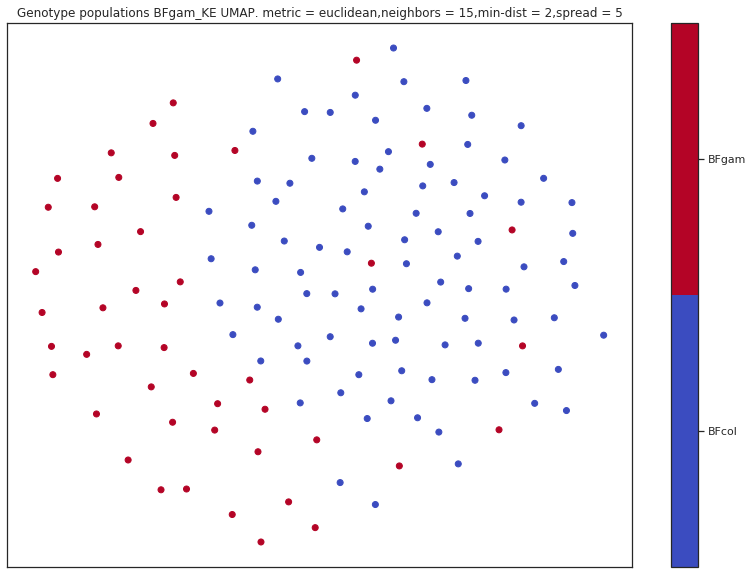

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 408)
2.) Filtering Rare Allels
Number of SNPs removed =  3447173
Retaining =  204547
3.) Performing LD Pruning
iteration 1 retaining 114492 removing 90055 variants
iteration 2 retaining 113867 removing 625 variants
iteration 3 retaining 113845 removing 22 variants
Retained Haplotype Matrix =  (113845, 408)
Retained Positions Matrix =  (113845,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


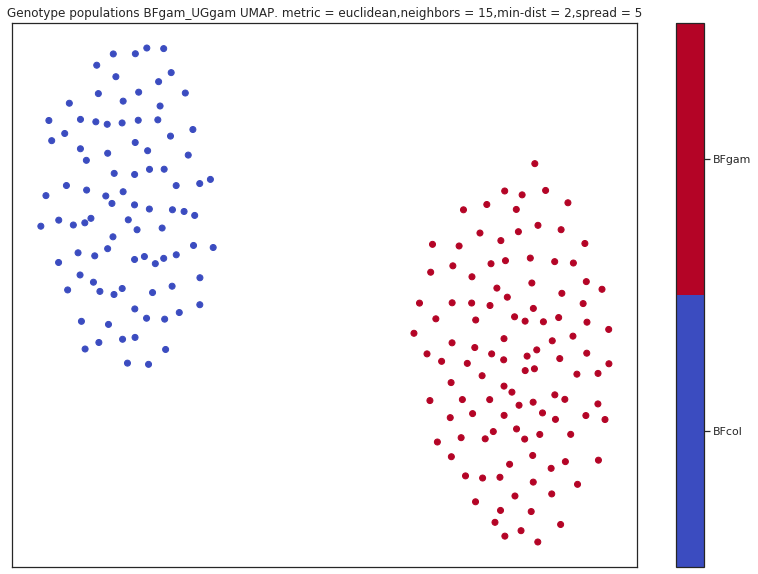

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 298)
2.) Filtering Rare Allels
Number of SNPs removed =  3444038
Retaining =  207682
3.) Performing LD Pruning
iteration 1 retaining 50998 removing 156684 variants
iteration 2 retaining 46649 removing 4349 variants
iteration 3 retaining 46424 removing 225 variants
Retained Haplotype Matrix =  (46424, 298)
Retained Positions Matrix =  (46424,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


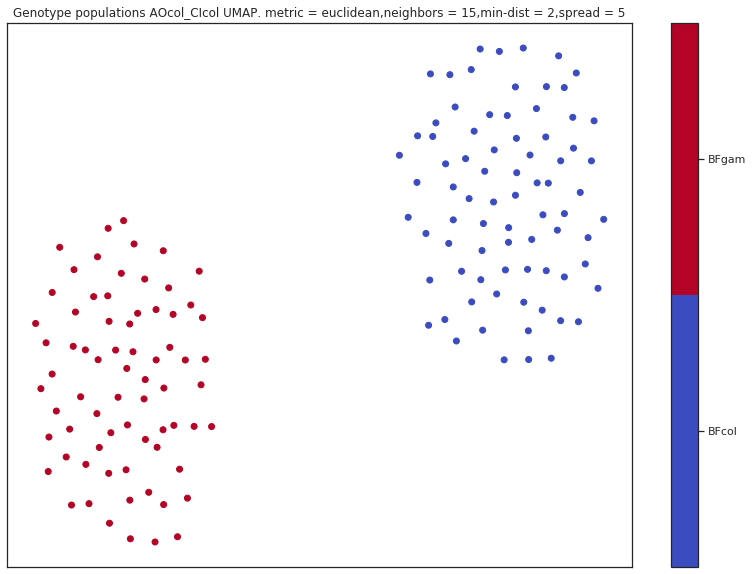

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 356)
2.) Filtering Rare Allels
Number of SNPs removed =  3446178
Retaining =  205542
3.) Performing LD Pruning
iteration 1 retaining 77193 removing 128349 variants
iteration 2 retaining 74259 removing 2934 variants
iteration 3 retaining 74067 removing 192 variants
Retained Haplotype Matrix =  (74067, 356)
Retained Positions Matrix =  (74067,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


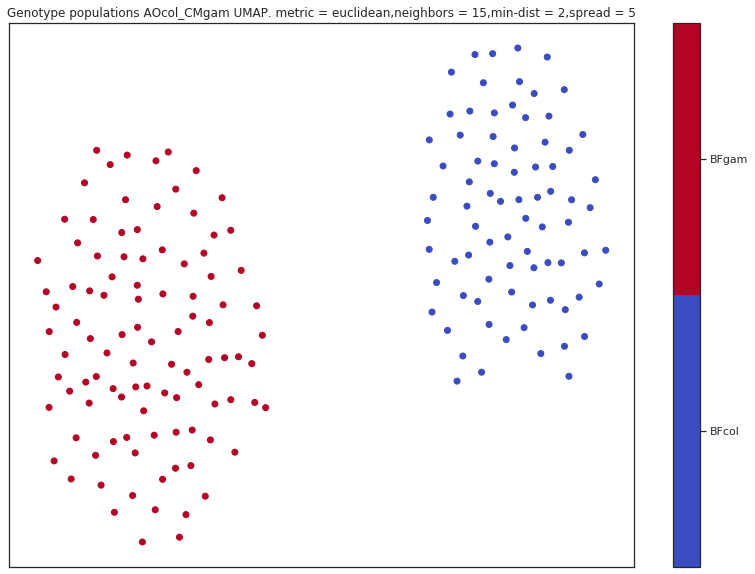

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3424104
Retaining =  227616
3.) Performing LD Pruning
iteration 1 retaining 25459 removing 202157 variants
iteration 2 retaining 19488 removing 5971 variants
iteration 3 retaining 19320 removing 168 variants
Retained Haplotype Matrix =  (19320, 294)
Retained Positions Matrix =  (19320,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


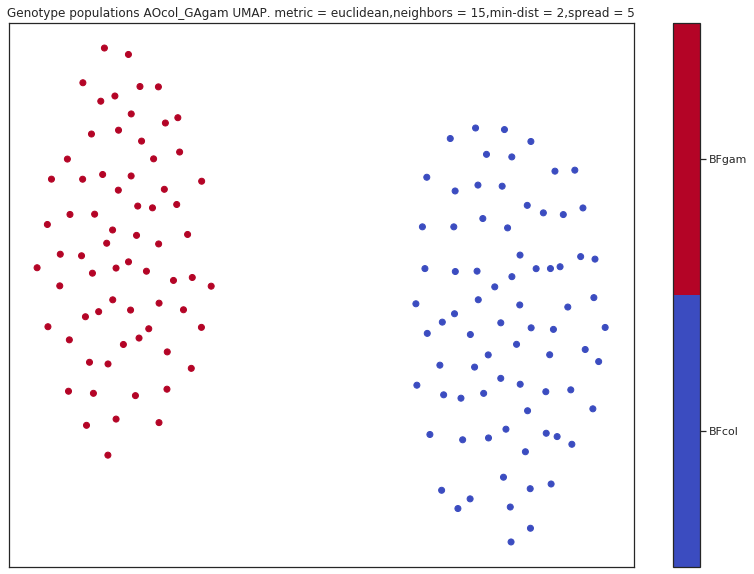

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 266)
2.) Filtering Rare Allels
Number of SNPs removed =  3452478
Retaining =  199242
3.) Performing LD Pruning
iteration 1 retaining 47168 removing 152074 variants
iteration 2 retaining 41904 removing 5264 variants
iteration 3 retaining 41458 removing 446 variants
Retained Haplotype Matrix =  (41458, 266)
Retained Positions Matrix =  (41458,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


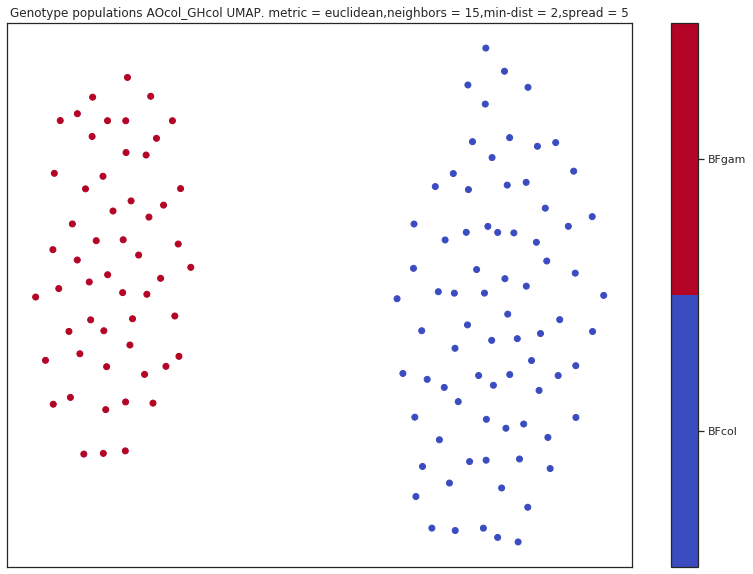

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 286)
2.) Filtering Rare Allels
Number of SNPs removed =  3444735
Retaining =  206985
3.) Performing LD Pruning
iteration 1 retaining 44183 removing 162802 variants
iteration 2 retaining 38047 removing 6136 variants
iteration 3 retaining 37741 removing 306 variants
Retained Haplotype Matrix =  (37741, 286)
Retained Positions Matrix =  (37741,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


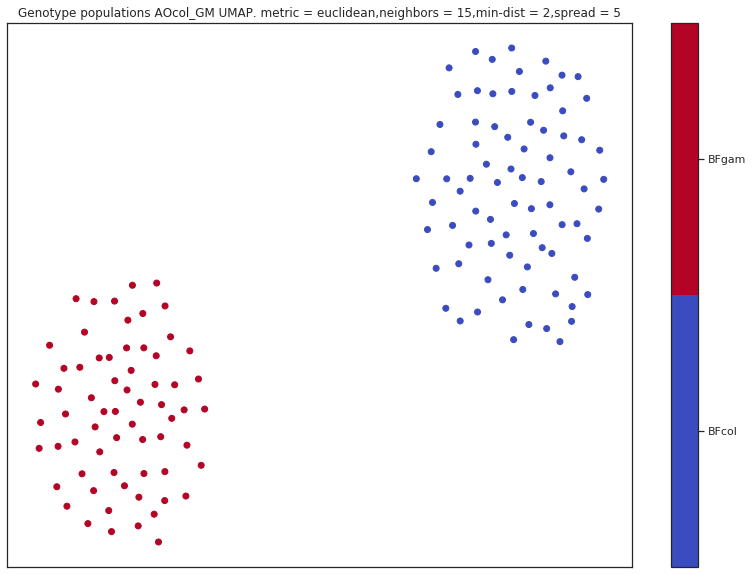

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 236)
2.) Filtering Rare Allels
Number of SNPs removed =  3449962
Retaining =  201758
3.) Performing LD Pruning
iteration 2 retaining 67030 removing 2626 variants
iteration 3 retaining 66857 removing 173 variants
Retained Haplotype Matrix =  (66857, 338)
Retained Positions Matrix =  (66857,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


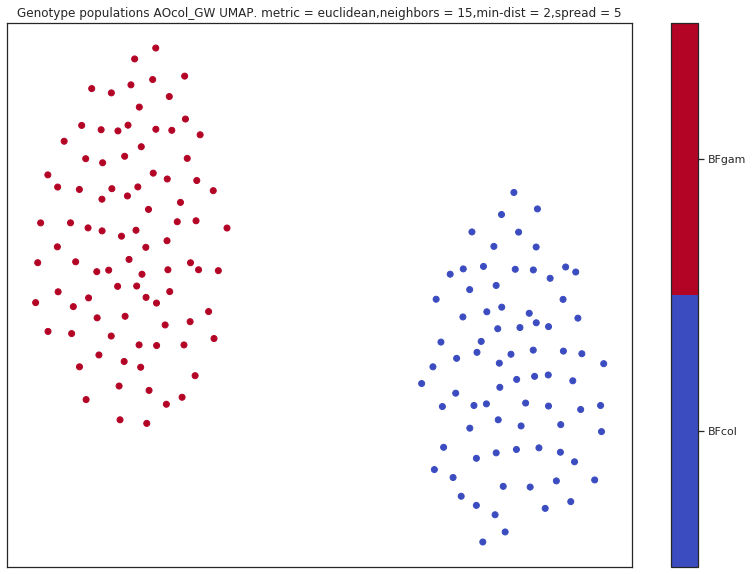

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3443182
Retaining =  208538
3.) Performing LD Pruning
iteration 1 retaining 12232 removing 196306 variants
iteration 2 retaining 5776 removing 6456 variants
iteration 3 retaining 4681 removing 1095 variants
Retained Haplotype Matrix =  (4681, 252)
Retained Positions Matrix =  (4681,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


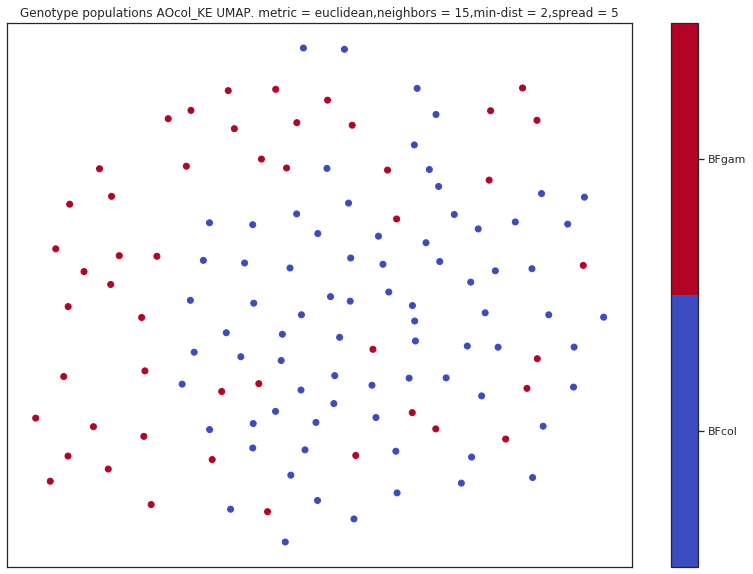

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 380)
2.) Filtering Rare Allels
Number of SNPs removed =  3441526
Retaining =  210194
3.) Performing LD Pruning
iteration 1 retaining 77218 removing 132976 variants
iteration 2 retaining 74726 removing 2492 variants
iteration 3 retaining 74624 removing 102 variants
Retained Haplotype Matrix =  (74624, 380)
Retained Positions Matrix =  (74624,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


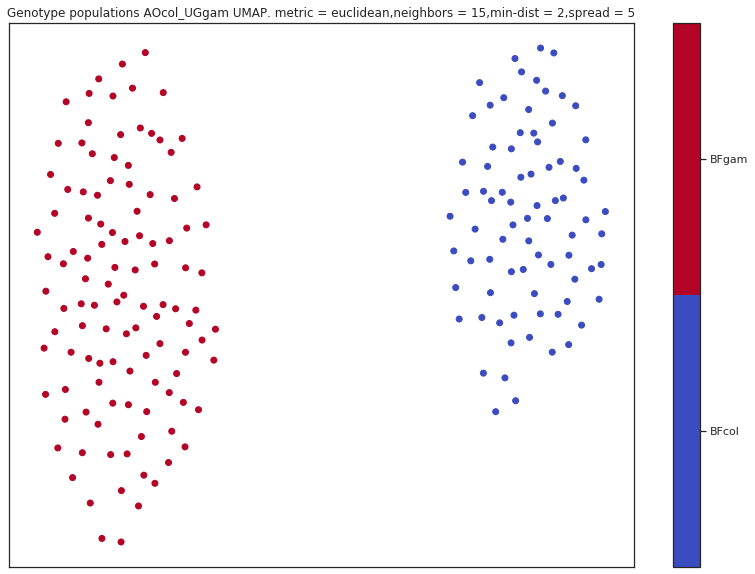

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 342)
2.) Filtering Rare Allels
Number of SNPs removed =  3450009
Retaining =  201711
3.) Performing LD Pruning
iteration 1 retaining 107163 removing 94548 variants
iteration 2 retaining 106004 removing 1159 variants
iteration 3 retaining 105937 removing 67 variants
Retained Haplotype Matrix =  (105937, 342)
Retained Positions Matrix =  (105937,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


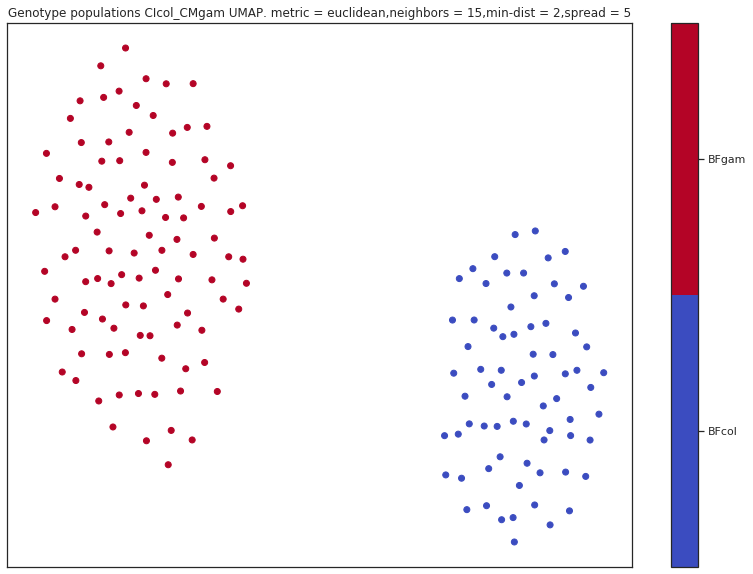

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3419651
Retaining =  232069
3.) Performing LD Pruning
iteration 1 retaining 43017 removing 189052 variants
iteration 2 retaining 36170 removing 6847 variants
iteration 3 retaining 35845 removing 325 variants
Retained Haplotype Matrix =  (35845, 280)
Retained Positions Matrix =  (35845,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


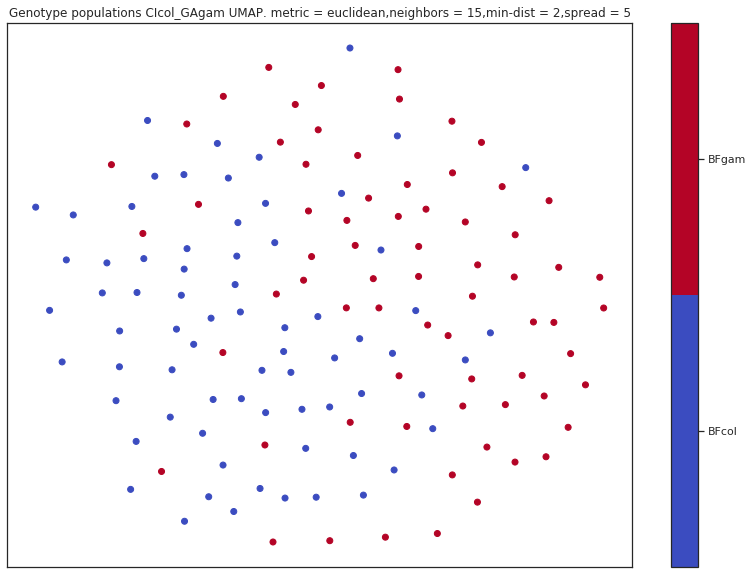

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3437390
Retaining =  214330
3.) Performing LD Pruning
iteration 1 retaining 70534 removing 143796 variants
iteration 2 retaining 68882 removing 1652 variants
iteration 3 retaining 68829 removing 53 variants
Retained Haplotype Matrix =  (68829, 252)
Retained Positions Matrix =  (68829,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


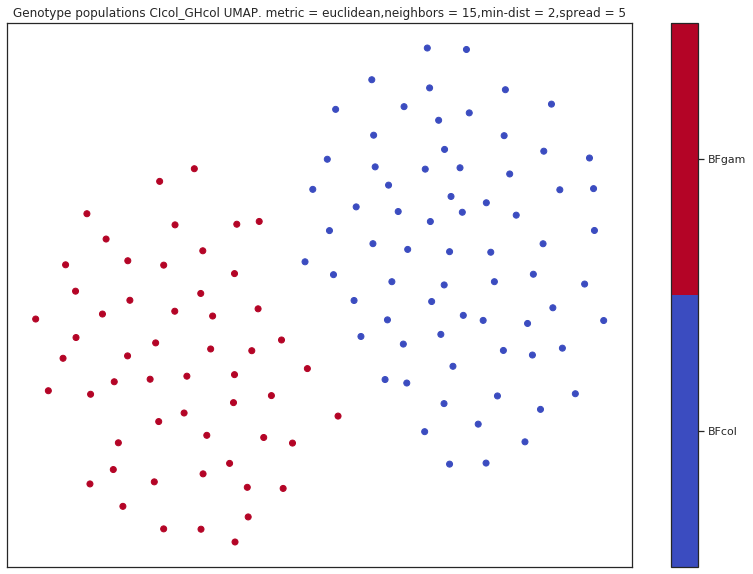

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 272)
2.) Filtering Rare Allels
Number of SNPs removed =  3435319
Retaining =  216401
3.) Performing LD Pruning
iteration 1 retaining 76799 removing 139602 variants
iteration 2 retaining 72882 removing 3917 variants
iteration 3 retaining 72688 removing 194 variants
Retained Haplotype Matrix =  (72688, 272)
Retained Positions Matrix =  (72688,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


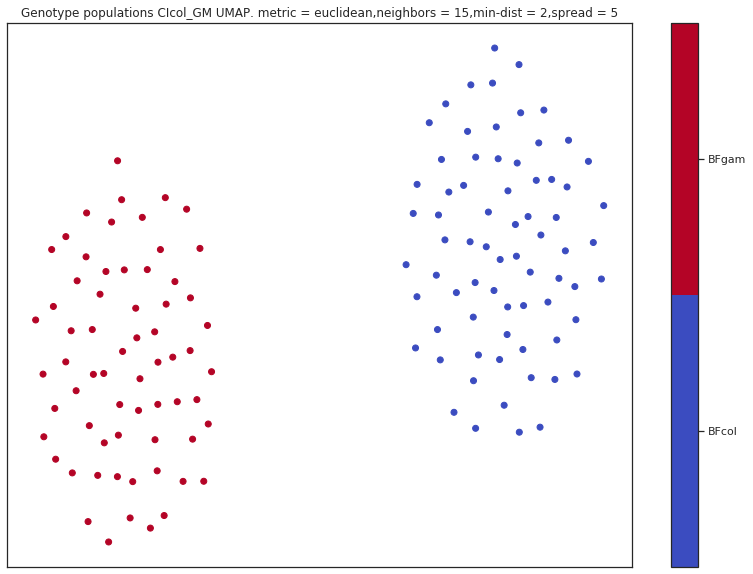

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 222)
2.) Filtering Rare Allels
Number of SNPs removed =  3447416
Retaining =  204304
3.) Performing LD Pruning
iteration 1 retaining 84886 removing 119418 variants
iteration 2 retaining 81532 removing 3354 variants
iteration 3 retaining 81277 removing 255 variants
Retained Haplotype Matrix =  (81277, 222)
Retained Positions Matrix =  (81277,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


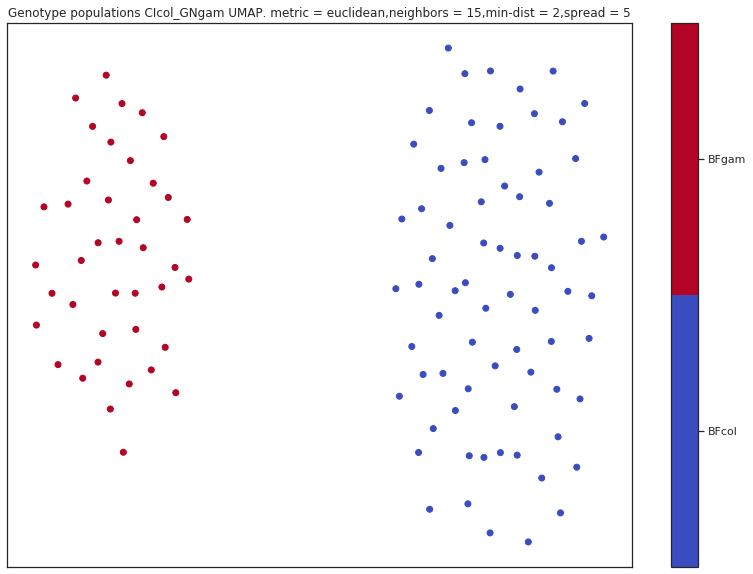

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 324)
2.) Filtering Rare Allels
Number of SNPs removed =  3443481
Retaining =  208239
3.) Performing LD Pruning
iteration 1 retaining 96969 removing 111270 variants
iteration 2 retaining 96390 removing 579 variants
iteration 3 retaining 96376 removing 14 variants
Retained Haplotype Matrix =  (96376, 324)
Retained Positions Matrix =  (96376,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


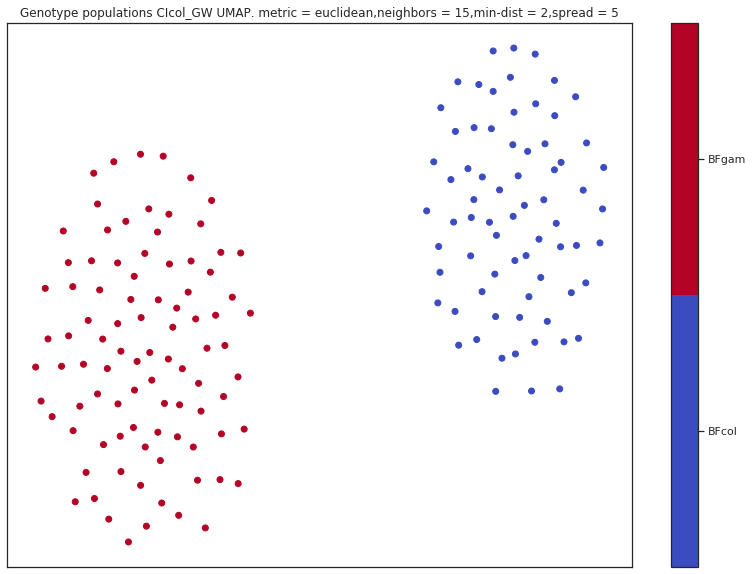

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 238)
2.) Filtering Rare Allels
Number of SNPs removed =  3444457
Retaining =  207263
3.) Performing LD Pruning
iteration 1 retaining 22322 removing 184941 variants
iteration 2 retaining 12047 removing 10275 variants
iteration 3 retaining 9296 removing 2751 variants
Retained Haplotype Matrix =  (9296, 238)
Retained Positions Matrix =  (9296,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


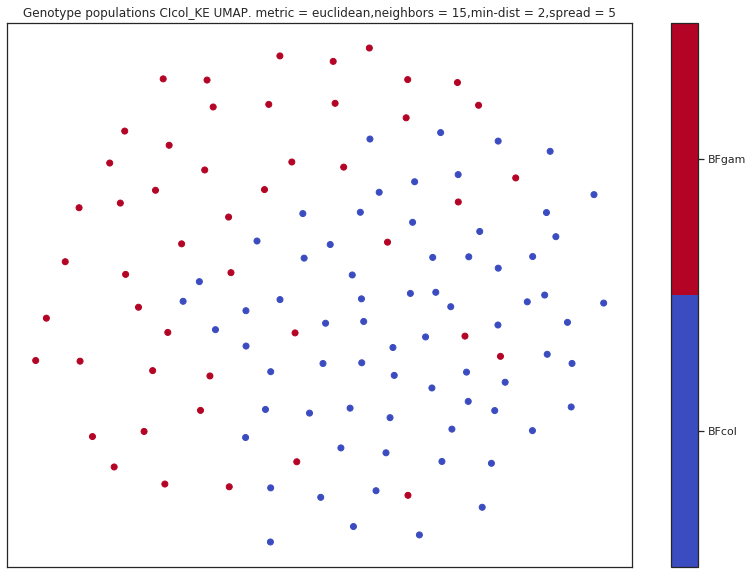

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3446117
Retaining =  205603
3.) Performing LD Pruning
iteration 1 retaining 104964 removing 100639 variants
iteration 2 retaining 103759 removing 1205 variants
iteration 3 retaining 103720 removing 39 variants
Retained Haplotype Matrix =  (103720, 366)
Retained Positions Matrix =  (103720,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


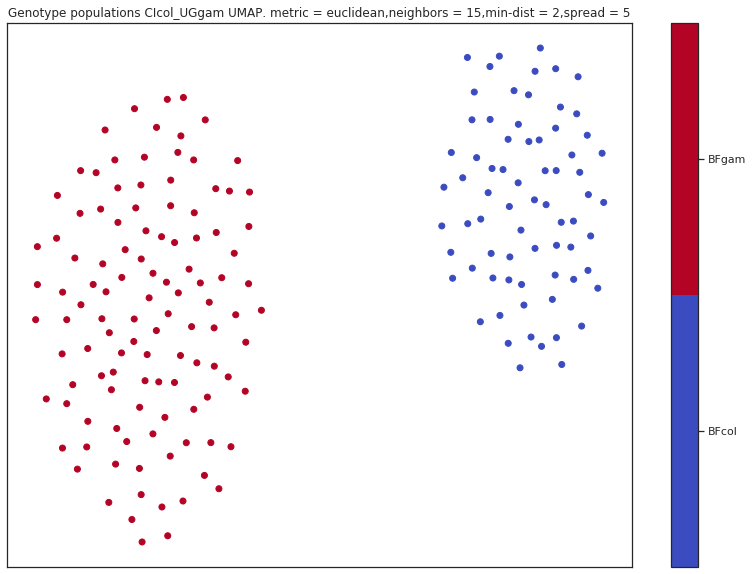

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 338)
2.) Filtering Rare Allels
Number of SNPs removed =  3429246
Retaining =  222474
3.) Performing LD Pruning
iteration 1 retaining 69607 removing 152867 variants
iteration 2 retaining 65103 removing 4504 variants
iteration 3 retaining 64916 removing 187 variants
Retained Haplotype Matrix =  (64916, 338)
Retained Positions Matrix =  (64916,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


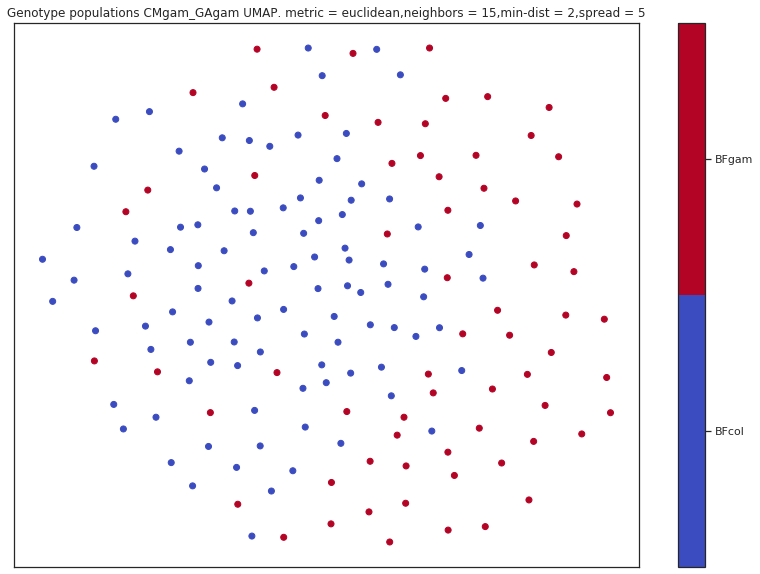

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 310)
2.) Filtering Rare Allels
Number of SNPs removed =  3447274
Retaining =  204446
3.) Performing LD Pruning
iteration 1 retaining 112548 removing 91898 variants
iteration 2 retaining 111247 removing 1301 variants
iteration 3 retaining 111144 removing 103 variants
Retained Haplotype Matrix =  (111144, 310)
Retained Positions Matrix =  (111144,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


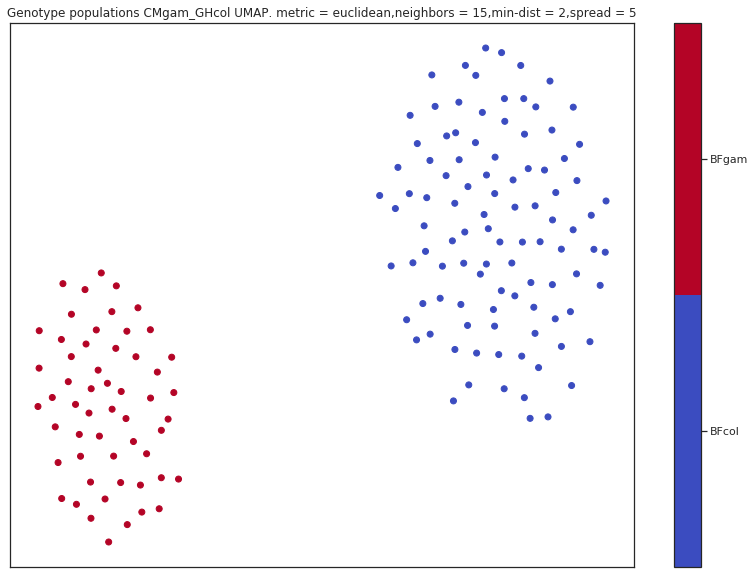

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 330)
2.) Filtering Rare Allels
Number of SNPs removed =  3444212
Retaining =  207508
3.) Performing LD Pruning
iteration 1 retaining 106275 removing 101233 variants
iteration 2 retaining 104122 removing 2153 variants
iteration 3 retaining 103963 removing 159 variants
Retained Haplotype Matrix =  (103963, 330)
Retained Positions Matrix =  (103963,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


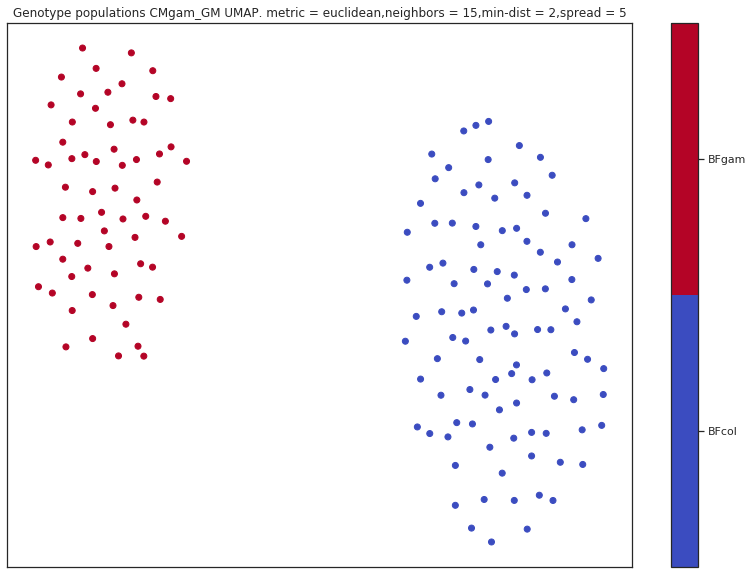

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3442081
Retaining =  209639
3.) Performing LD Pruning
iteration 1 retaining 116096 removing 93543 variants
iteration 2 retaining 114532 removing 1564 variants
iteration 3 retaining 114441 removing 91 variants
Retained Haplotype Matrix =  (114441, 280)
Retained Positions Matrix =  (114441,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


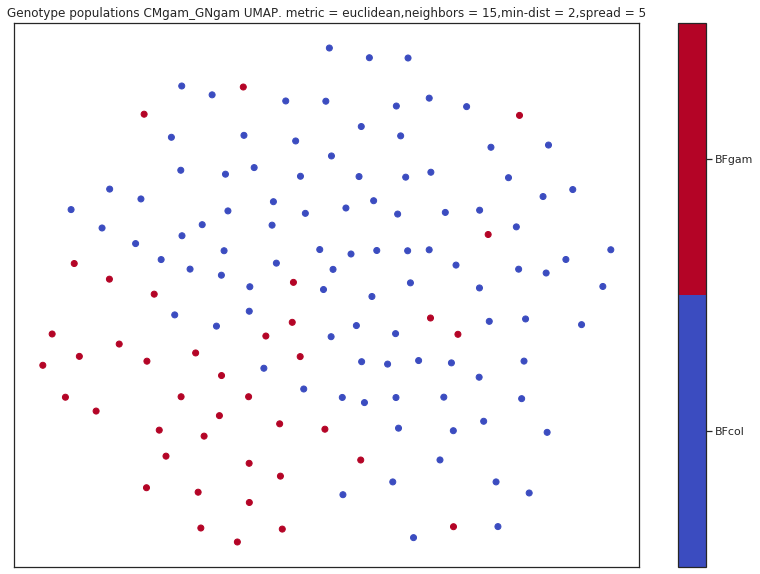

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 382)
2.) Filtering Rare Allels
Number of SNPs removed =  3449090
Retaining =  202630
3.) Performing LD Pruning
iteration 1 retaining 115840 removing 86790 variants
iteration 2 retaining 115340 removing 500 variants
iteration 3 retaining 115315 removing 25 variants
Retained Haplotype Matrix =  (115315, 382)
Retained Positions Matrix =  (115315,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


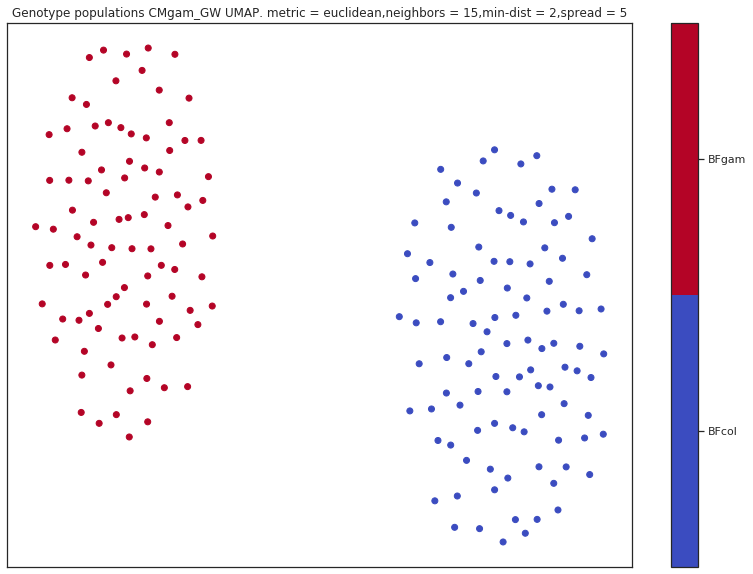

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 296)
2.) Filtering Rare Allels
Number of SNPs removed =  3446934
Retaining =  204786
3.) Performing LD Pruning
iteration 1 retaining 55112 removing 149674 variants
iteration 2 retaining 46002 removing 9110 variants
iteration 3 retaining 44654 removing 1348 variants
Retained Haplotype Matrix =  (44654, 296)
Retained Positions Matrix =  (44654,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


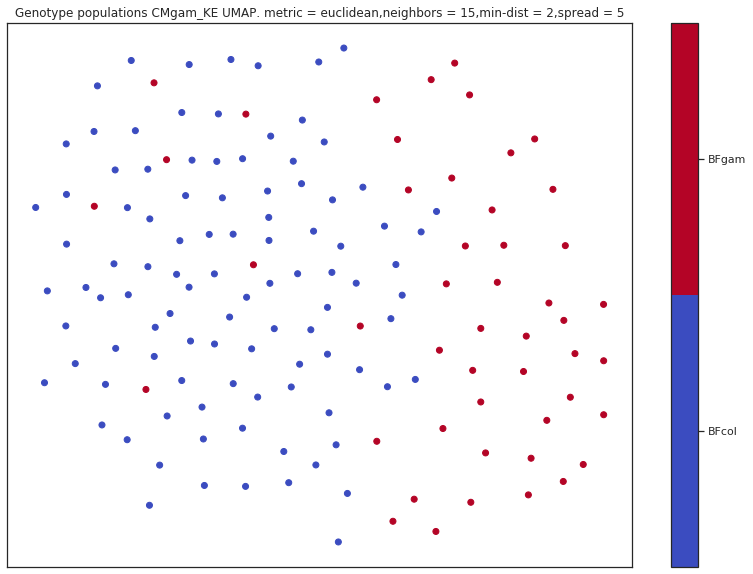

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 424)
2.) Filtering Rare Allels
Number of SNPs removed =  3448730
Retaining =  202990
3.) Performing LD Pruning
iteration 1 retaining 114759 removing 88231 variants
iteration 2 retaining 114208 removing 551 variants
iteration 3 retaining 114190 removing 18 variants
Retained Haplotype Matrix =  (114190, 424)
Retained Positions Matrix =  (114190,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


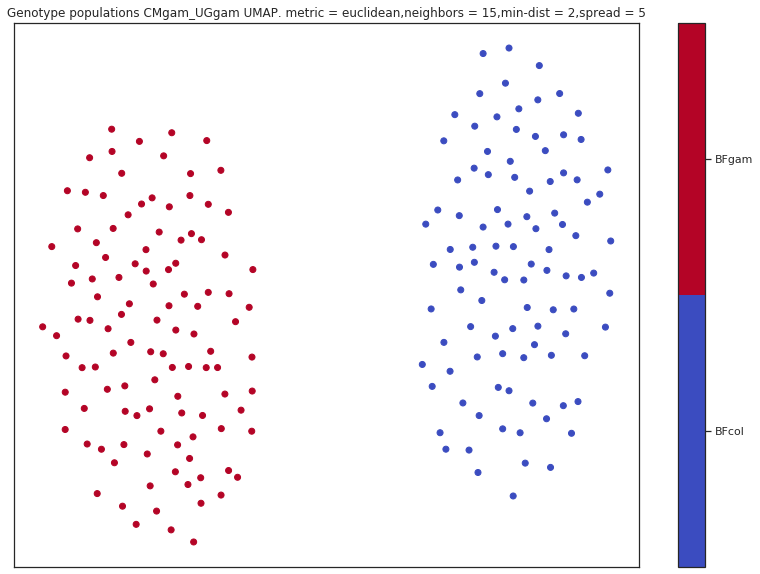

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 248)
2.) Filtering Rare Allels
Number of SNPs removed =  3426812
Retaining =  224908
3.) Performing LD Pruning
iteration 1 retaining 37838 removing 187070 variants
iteration 2 retaining 29787 removing 8051 variants
iteration 3 retaining 29067 removing 720 variants
Retained Haplotype Matrix =  (29067, 248)
Retained Positions Matrix =  (29067,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


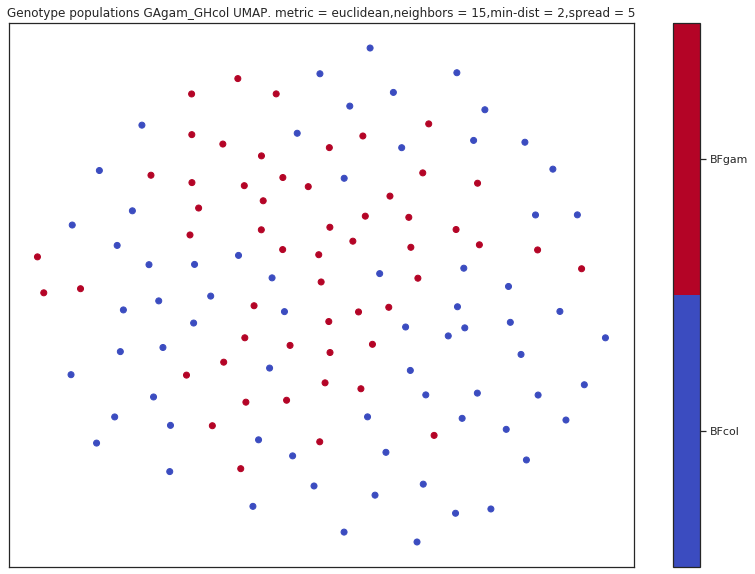

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 268)
2.) Filtering Rare Allels
Number of SNPs removed =  3423297
Retaining =  228423
3.) Performing LD Pruning
iteration 1 retaining 35574 removing 192849 variants
iteration 2 retaining 27125 removing 8449 variants
iteration 3 retaining 26819 removing 306 variants
Retained Haplotype Matrix =  (26819, 268)
Retained Positions Matrix =  (26819,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


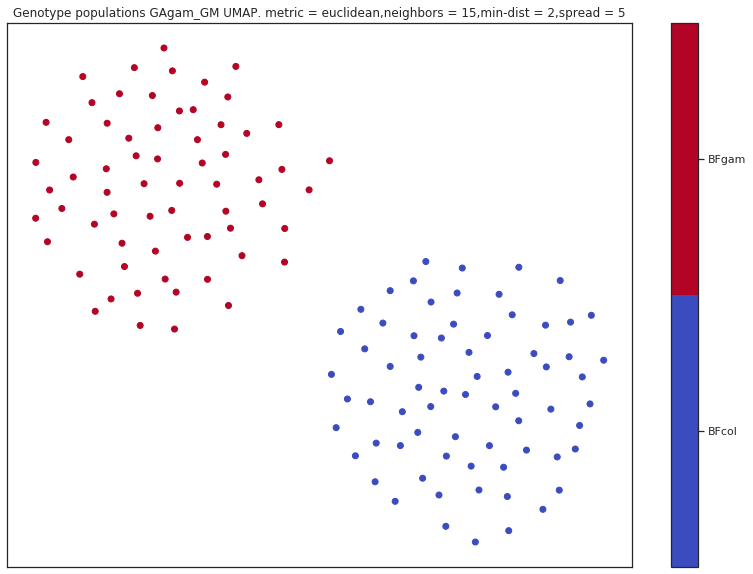

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 218)
2.) Filtering Rare Allels
Number of SNPs removed =  3422444
Retaining =  229276
3.) Performing LD Pruning
iteration 1 retaining 31927 removing 197349 variants
iteration 2 retaining 22871 removing 9056 variants
iteration 3 retaining 22083 removing 788 variants
Retained Haplotype Matrix =  (22083, 218)
Retained Positions Matrix =  (22083,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


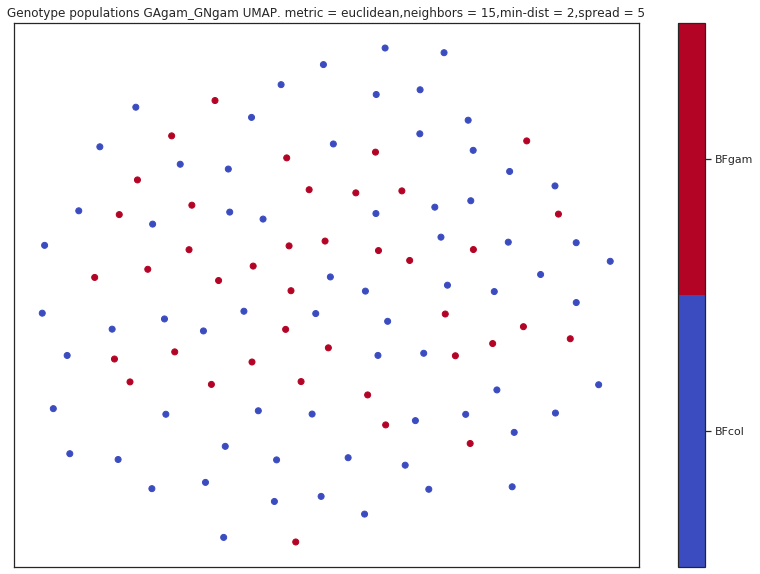

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 320)
2.) Filtering Rare Allels
Number of SNPs removed =  3422927
Retaining =  228793
3.) Performing LD Pruning
iteration 1 retaining 64157 removing 164636 variants
iteration 2 retaining 59657 removing 4500 variants
iteration 3 retaining 59441 removing 216 variants
Retained Haplotype Matrix =  (59441, 320)
Retained Positions Matrix =  (59441,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


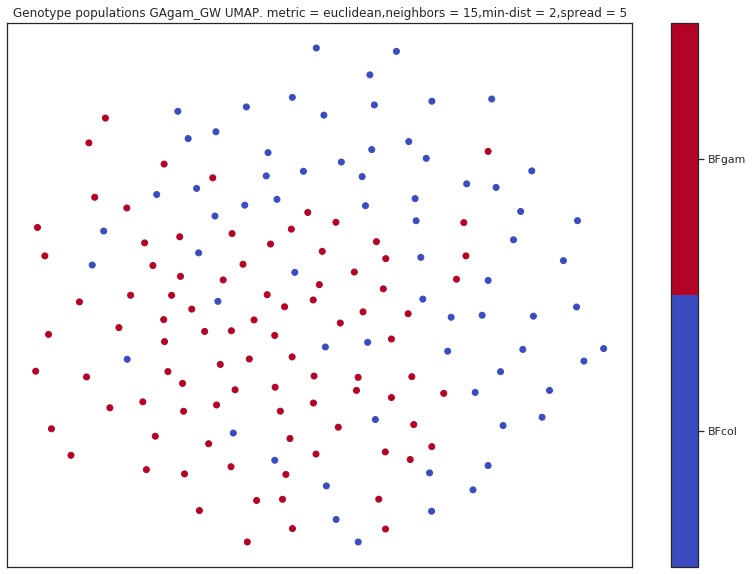

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 234)
2.) Filtering Rare Allels
Number of SNPs removed =  3425465
Retaining =  226255
3.) Performing LD Pruning
iteration 1 retaining 7268 removing 218987 variants
iteration 2 retaining 2386 removing 4882 variants
iteration 3 retaining 1867 removing 519 variants
Retained Haplotype Matrix =  (1867, 234)
Retained Positions Matrix =  (1867,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


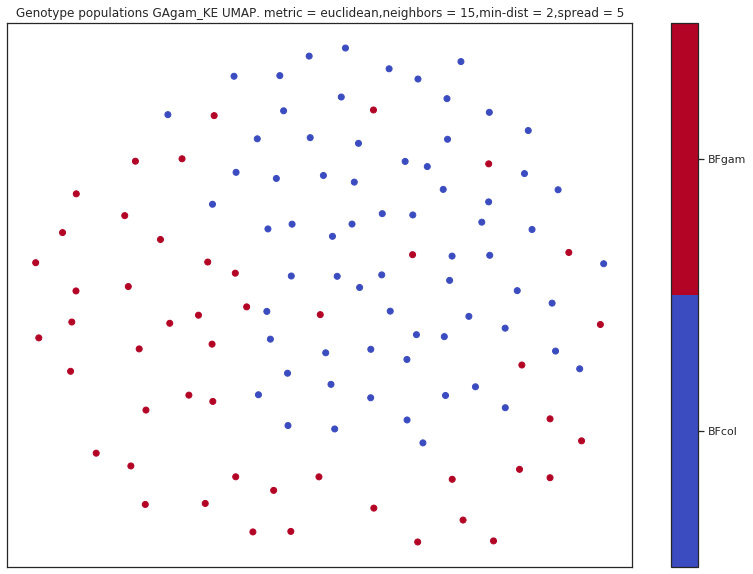

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 362)
2.) Filtering Rare Allels
Number of SNPs removed =  3434675
Retaining =  217045
3.) Performing LD Pruning
iteration 1 retaining 69036 removing 148009 variants
iteration 2 retaining 65755 removing 3281 variants
iteration 3 retaining 65676 removing 79 variants
Retained Haplotype Matrix =  (65676, 362)
Retained Positions Matrix =  (65676,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


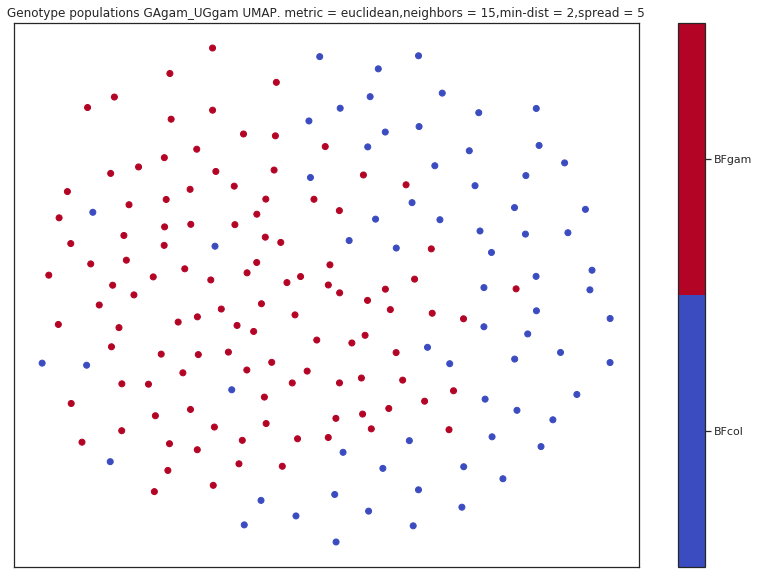

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 240)
2.) Filtering Rare Allels
Number of SNPs removed =  3429424
Retaining =  222296
3.) Performing LD Pruning
iteration 1 retaining 77640 removing 144656 variants
iteration 2 retaining 72187 removing 5453 variants
iteration 3 retaining 71791 removing 396 variants
Retained Haplotype Matrix =  (71791, 240)
Retained Positions Matrix =  (71791,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


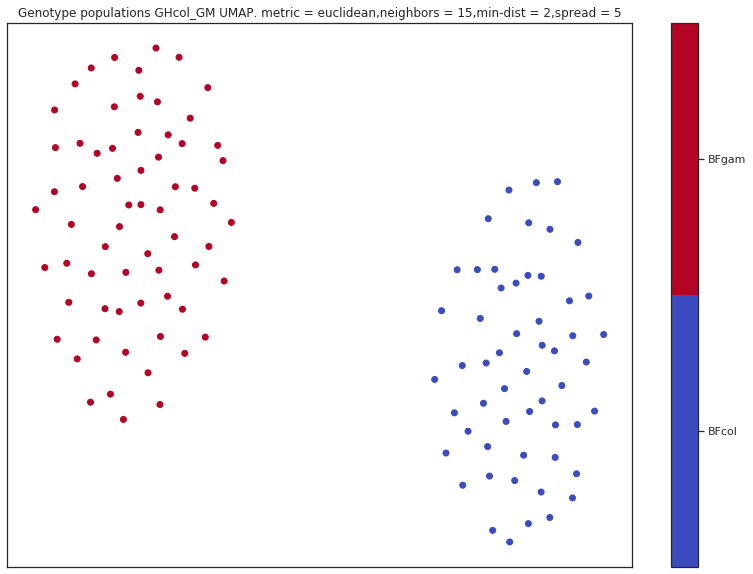

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 190)
2.) Filtering Rare Allels
Number of SNPs removed =  3444235
Retaining =  207485
3.) Performing LD Pruning
iteration 1 retaining 92222 removing 115263 variants
iteration 2 retaining 87095 removing 5127 variants
iteration 3 retaining 86406 removing 689 variants
Retained Haplotype Matrix =  (86406, 190)
Retained Positions Matrix =  (86406,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


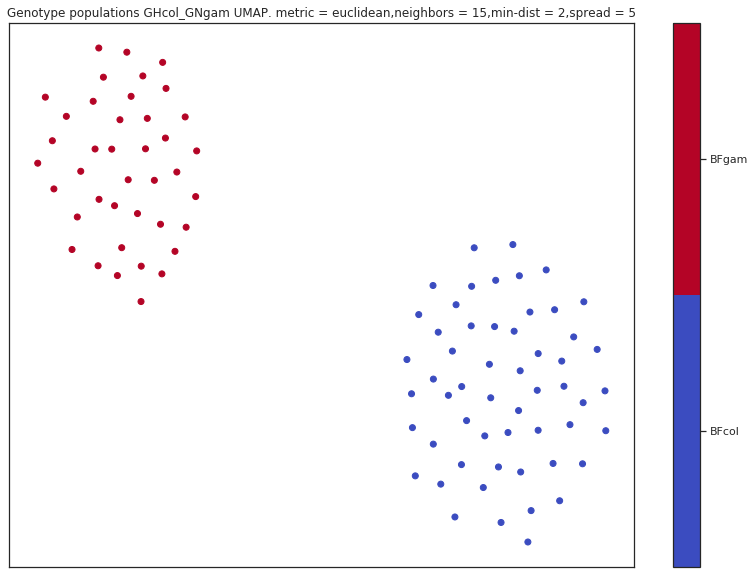

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 292)
2.) Filtering Rare Allels
Number of SNPs removed =  3439904
Retaining =  211816
3.) Performing LD Pruning
iteration 1 retaining 100992 removing 110824 variants


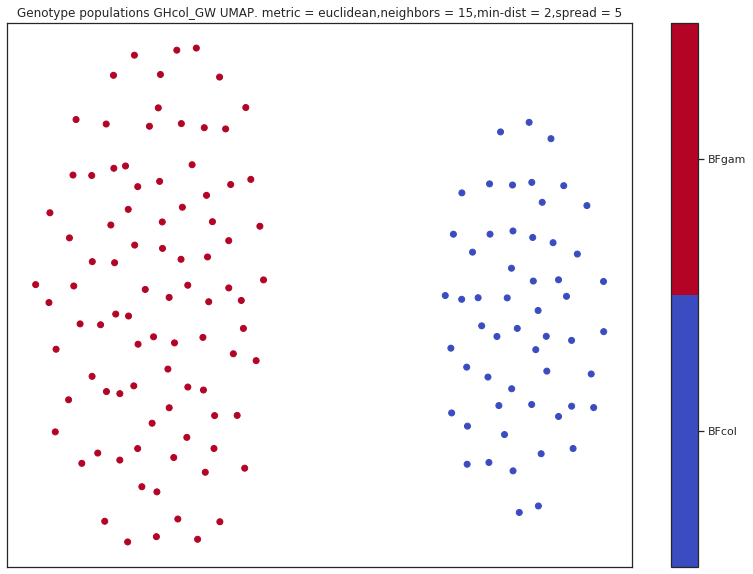

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 206)
2.) Filtering Rare Allels
Number of SNPs removed =  3459002
Retaining =  192718
3.) Performing LD Pruning
iteration 1 retaining 18766 removing 173952 variants
iteration 2 retaining 6871 removing 11895 variants
iteration 3 retaining 3544 removing 3327 variants
Retained Haplotype Matrix =  (3544, 206)
Retained Positions Matrix =  (3544,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


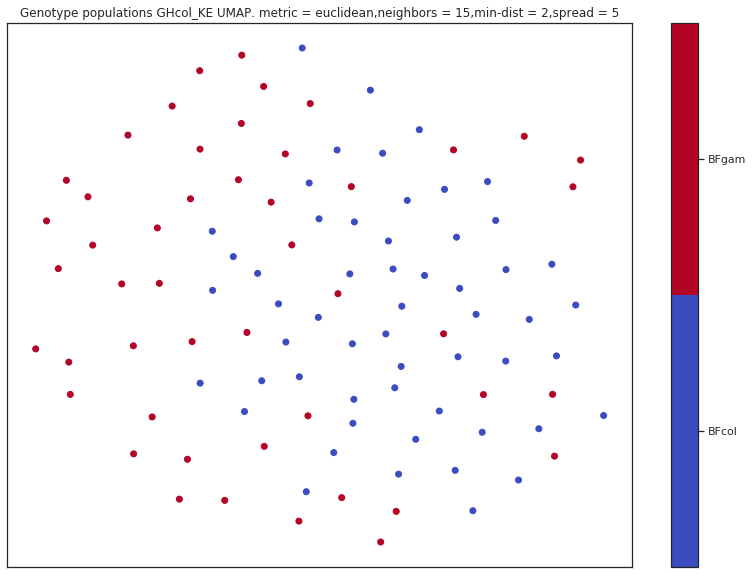

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3443040
Retaining =  208680
3.) Performing LD Pruning
iteration 1 retaining 108291 removing 100389 variants
iteration 2 retaining 107114 removing 1177 variants
iteration 3 retaining 107062 removing 52 variants
Retained Haplotype Matrix =  (107062, 334)
Retained Positions Matrix =  (107062,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


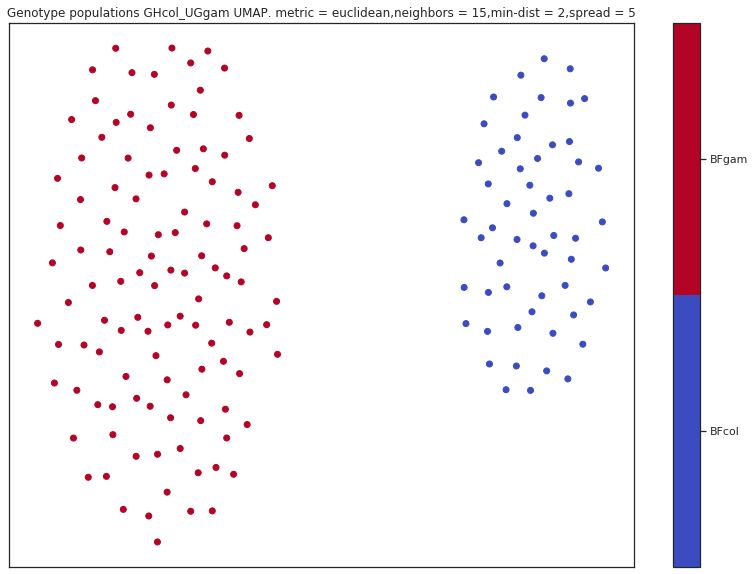

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 210)
2.) Filtering Rare Allels
Number of SNPs removed =  3437077
Retaining =  214643
3.) Performing LD Pruning
iteration 1 retaining 77249 removing 137394 variants
iteration 2 retaining 69324 removing 7925 variants
iteration 3 retaining 68500 removing 824 variants
Retained Haplotype Matrix =  (68500, 210)
Retained Positions Matrix =  (68500,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


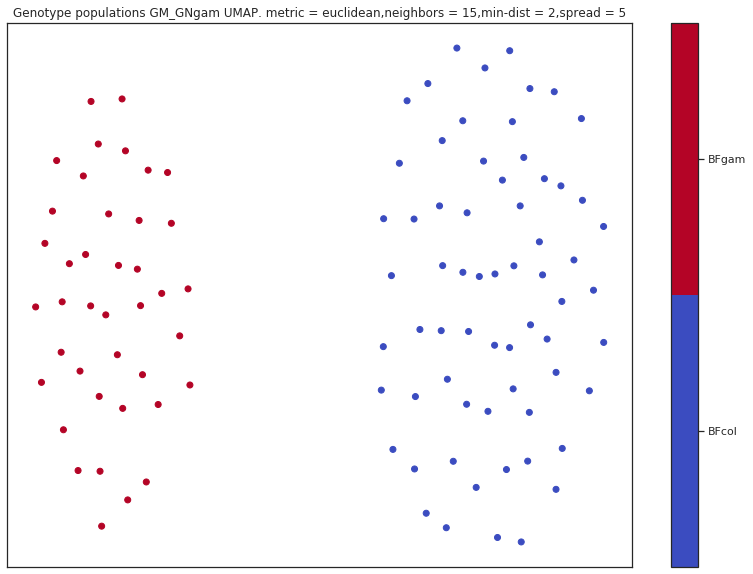

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 312)
2.) Filtering Rare Allels
Number of SNPs removed =  3434414
Retaining =  217306
3.) Performing LD Pruning
iteration 1 retaining 86794 removing 130512 variants
iteration 2 retaining 85284 removing 1510 variants
iteration 3 retaining 85205 removing 79 variants
Retained Haplotype Matrix =  (85205, 312)
Retained Positions Matrix =  (85205,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


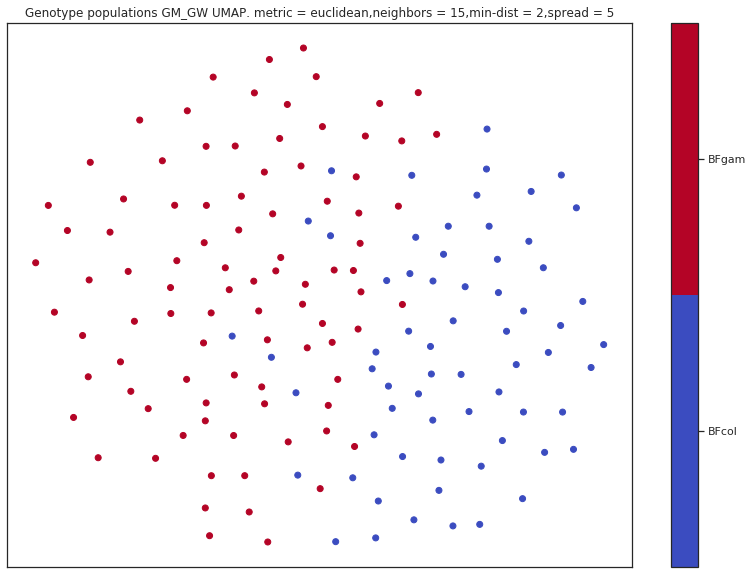

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 226)
2.) Filtering Rare Allels
Number of SNPs removed =  3447889
Retaining =  203831
3.) Performing LD Pruning
iteration 1 retaining 15730 removing 188101 variants
iteration 2 retaining 6192 removing 9538 variants
iteration 3 retaining 4230 removing 1962 variants
Retained Haplotype Matrix =  (4230, 226)
Retained Positions Matrix =  (4230,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


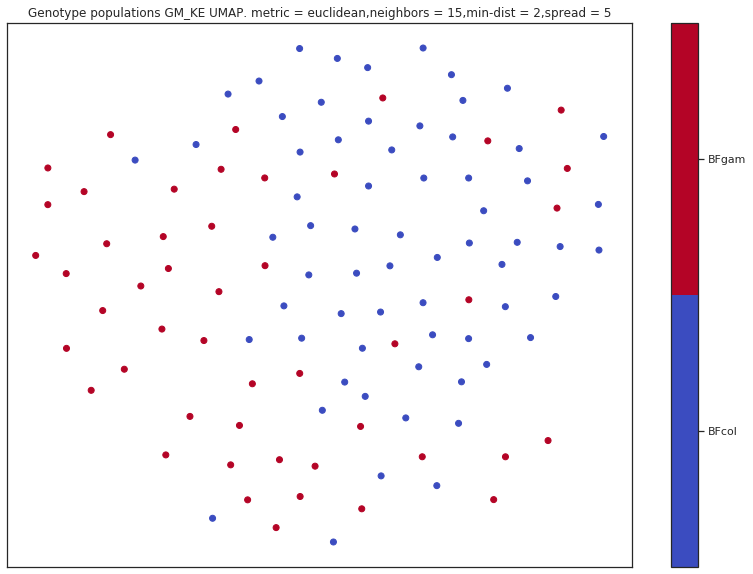

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 354)
2.) Filtering Rare Allels
Number of SNPs removed =  3440259
Retaining =  211461
3.) Performing LD Pruning
iteration 1 retaining 104095 removing 107366 variants
iteration 2 retaining 102322 removing 1773 variants
iteration 3 retaining 102247 removing 75 variants
Retained Haplotype Matrix =  (102247, 354)
Retained Positions Matrix =  (102247,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


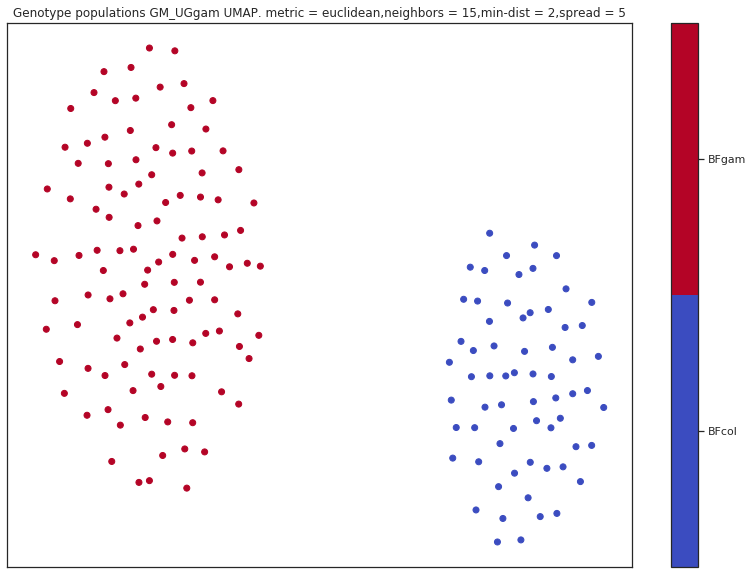

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GNgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 262)
2.) Filtering Rare Allels
Number of SNPs removed =  3446965
Retaining =  204755
3.) Performing LD Pruning
iteration 1 retaining 106394 removing 98361 variants
iteration 2 retaining 105560 removing 834 variants
iteration 3 retaining 105491 removing 69 variants
Retained Haplotype Matrix =  (105491, 262)
Retained Positions Matrix =  (105491,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


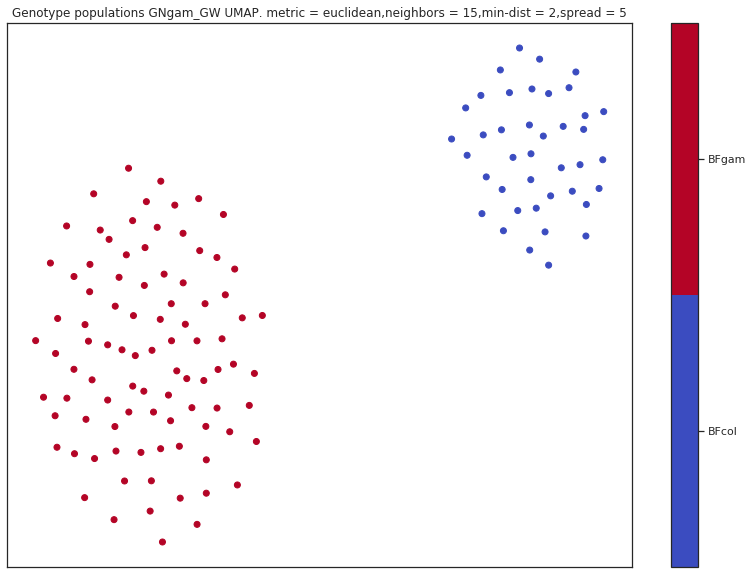

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GNgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 176)
2.) Filtering Rare Allels
Number of SNPs removed =  3468350
Retaining =  183370
3.) Performing LD Pruning
iteration 1 retaining 15379 removing 167991 variants
iteration 2 retaining 3453 removing 11926 variants
iteration 3 retaining 1279 removing 2174 variants
Retained Haplotype Matrix =  (1279, 176)
Retained Positions Matrix =  (1279,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


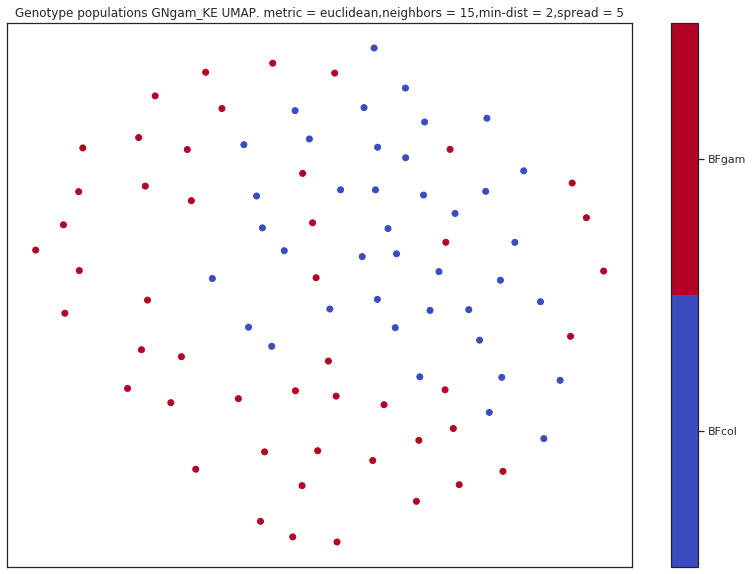

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GNgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 304)
2.) Filtering Rare Allels
Number of SNPs removed =  3446863
Retaining =  204857
3.) Performing LD Pruning
iteration 1 retaining 108327 removing 96530 variants
iteration 2 retaining 107300 removing 1027 variants
iteration 3 retaining 107262 removing 38 variants
Retained Haplotype Matrix =  (107262, 304)
Retained Positions Matrix =  (107262,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


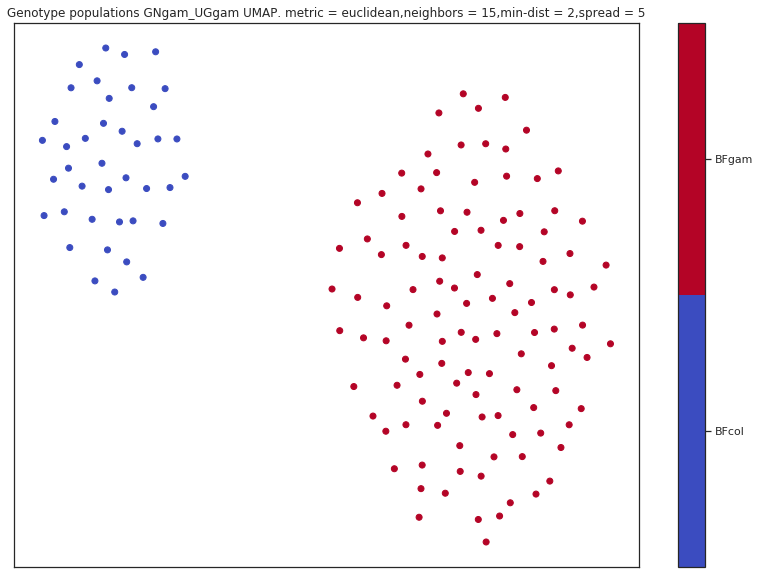

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GW_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 278)
2.) Filtering Rare Allels
Number of SNPs removed =  3442586
Retaining =  209134
3.) Performing LD Pruning
iteration 1 retaining 44768 removing 164366 variants
iteration 2 retaining 35623 removing 9145 variants
iteration 3 retaining 33925 removing 1698 variants
Retained Haplotype Matrix =  (33925, 278)
Retained Positions Matrix =  (33925,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


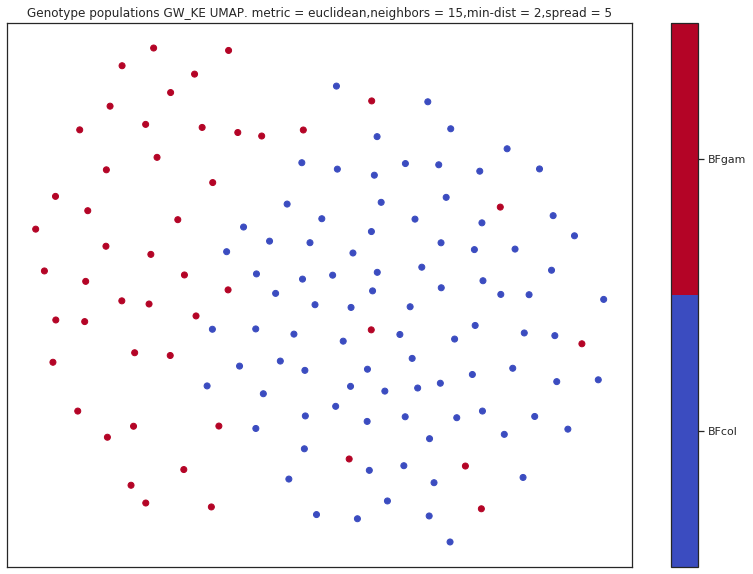

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GW_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 406)
2.) Filtering Rare Allels
Number of SNPs removed =  3445870
Retaining =  205850
3.) Performing LD Pruning
iteration 1 retaining 113365 removing 92485 variants
iteration 2 retaining 112884 removing 481 variants
iteration 3 retaining 112864 removing 20 variants
Retained Haplotype Matrix =  (112864, 406)
Retained Positions Matrix =  (112864,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


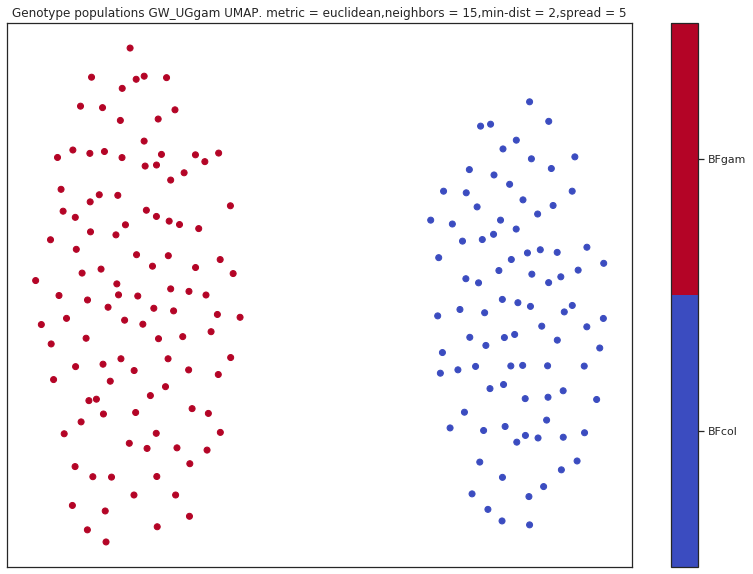

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


KE_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 320)
2.) Filtering Rare Allels
Number of SNPs removed =  3440839
Retaining =  210881
3.) Performing LD Pruning
iteration 1 retaining 54466 removing 156415 variants
iteration 2 retaining 47382 removing 7084 variants
iteration 3 retaining 46669 removing 713 variants
Retained Haplotype Matrix =  (46669, 320)
Retained Positions Matrix =  (46669,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


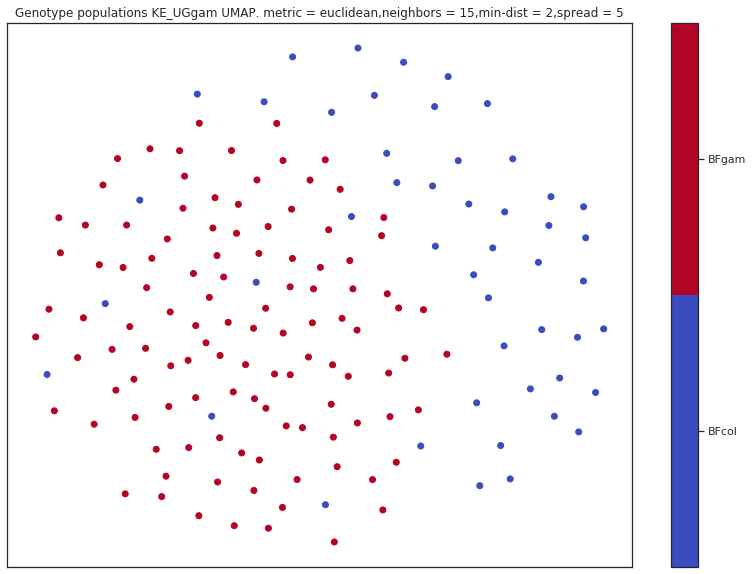

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


ValueError: Length of values (5) does not match length of index (66)

In [124]:
'''
Pairwise analysis of all the 12 populations.
Total 66 combinations/analysis
Analysis includes:
1. Selecting a pair
2. Filtering the SNPs jointly
    - Mega Base Pair Selection
    - Rare Allele Filtering with MAF >= 5%
    - LD Pruning
    Store Filtering stats for all the pairs
3. Haplo to Geno and Train-Test Split
4. Classifying using Logistic Regression and LDA
5. Generating UMAP visualization
6. Dimensionality Reduction: Obtaining 20 UMAP components 
7. Training LR classifier on UMAP components
8. Dumping all the stats and evaluation scores into a dataframe
'''
# Storage Path
home = home = os.path.expanduser('~')
directory = os.path.join(home,'Imp_Research','Repository','Pairwise_Analysis')

# List of keys
keys = list(H.keys())
count = 0
pnames = []
psamples = []
pmaf = []
psnps_init = []
psnps_filt = []
accuracy_lr = []
f1score_lr = []
kappa_lr = []
accuracy_ulr = []
f1score_ulr = []
kappa_ulr = []

# Edited to do damage control ! 
for i in range(11):
    for j in range(i+1,12):
        count+=1
        pair_pos = POS_all[keys[i]]
        # 1. Pair Selection. Combining the populations. 
        pop1 = H[keys[i]]
        pop2 = H[keys[j]]
        pair_h = np.append(pop1,pop2,1)
        pname = f'{keys[i][:-3]}_{keys[j][:-3]}'
        pnames.append(pname)
        psnps_init.append(pair_h.shape[0])
        psamples.append(pair_h.shape[1]/2)
        print(f'{pname}\n{psnp_init}')
        
        # 2. Filtering (Using FilterSNP class) Taking window size 250 is quicker.
        fsnp = FilterSNP(pair_h,pair_pos)
        pair_h, pair_pos = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)
        psnps_filt.append(pair_h.shape[0])
        pmaf.append(fsnp._retained_maf)
#         ppos_filt = len(pair_pos)
        
        # 3. Haplo to Geno and Train-Test Split
        X = pair_h.T
        Xg = to_genotype(X)       #Genotype data
        pshape_g = Xg.shape
        Y = [0]*int(len(pop1[0])/2)
        Y.extend([1]*int(len(pop2[0])/2))
        Y = np.array(Y)
        x_train,x_test,y_train,y_test = train_test_split(Xg,Y,test_size = 0.2,stratify = Y,random_state= R_SEED)
        
        # 4. LR Classifier
        lr = LogisticRegression(n_jobs = -1)
        lr.fit(x_train,y_train)
        acc_lr, f1w_lr, kap_lr = evaluate_classifier(y_test,lr.predict(x_test))
        accuracy_lr.append(acc_lr)
        f1score_lr.append(f1w_lr)
        kappa_lr.append(kap_lr)
        
        # 5. Generate UMAP visualization
        UMAP_g = umap.UMAP(n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(Xg)
        sns.set(style='white')
        fig, ax = plt.subplots(1, figsize=(14, 10))
        plt.scatter(UMAP_g[:, 0],UMAP_g[:, 1],c=Y,cmap='coolwarm')
        plt.setp(ax, xticks=[], yticks=[])
        cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
        cbar.set_ticks(np.arange(2))
        cbar.set_ticklabels(populations)
        plt.title(f'Genotype populations {pname} UMAP. metric = euclidean,neighbors = 15,min-dist = 2,spread = 5');
        figname = f'{count}_{pname}_umap.png'
        path = os.path.join(directory,'pairwise_plots',figname)
        plt.savefig(path,dpi=100)
        plt.show() 
        # calling plt.show() before saving clears all the graph
        
        # 6. Dimensionality Reduction: Obtaining 20 umap components
        UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit(x_train)
        x_train = UMAP_g.embedding_
        x_test = UMAP_g.transform(x_test)
        
        # 7. Training LR on UMAP components
        ulr = LogisticRegression(n_jobs = -1)
        ulr.fit(x_train,y_train)
        acc_ulr, f1w_ulr, kap_ulr = evaluate_classifier(y_test,ulr.predict(x_test))
        accuracy_ulr.append(acc_ulr)
        f1score_ulr.append(f1w_ulr)
        kappa_ulr.append(kap_ulr)
    
pairwise_analysis = pd.DataFrame()
pairwise_analysis['Count'] = range(1,len(pnames)+1)
pairwise_analysis['Population_pair'] = pnames
pairwise_analysis['Samples'] = psamples
pairwise_analysis['Initial_SNP'] = psnps_init
pairwise_analysis['MAF_filter_SNP'] = pmaf
pairwise_analysis['Filtered_SNP'] = psnps_filt
pairwise_analysis['LR_accuracy'] = accuracy_lr
pairwise_analysis['LR_f1score'] = f1score_lr
pairwise_analysis['LR_kappa'] = kappa_lr
pairwise_analysis['UMAP_LR_accuracy'] = accuracy_ulr
pairwise_analysis['UMAP_LR_f1score'] = f1score_ulr
pairwise_analysis['UMAP_LR_kappa'] = kappa_ulr

# Errored at i = 5, j = 8, count = 48, pname = 'GAgam_GNgam'
# status: UMAP saved but no data. Also 20 components exceeded some samples.
# because I messed up (-_-) took test size 80% (-_-)(*_*)


print(pairwise_analysis)
path = os.path.join(directory,'Pairwise_Analysis_Stats.csv')
pairwise_analysis.to_csv(path,index= False)


In [128]:
path = os.path.join(directory,'Pairwise_Analysis_Stats_Euclidean_UMAP.csv')
pairwise_analysis.to_csv(path,index= False)

In [127]:
pairwise_analysis.head(50)

Count Population_pair  Samples  Initial_SNP  MAF_filter_SNP  Filtered_SNP  \
0       1     BFcol_BFgam    167.0      4836295          202928        116947   
1       2     BFcol_AOcol    153.0      4836295          196218         61477   
2       3     BFcol_CIcol    146.0      4836295          206852         91924   
3       4     BFcol_CMgam    175.0      4836295          200832        117855   
4       5     BFcol_GAgam    144.0      4836295          218226         52373   
5       6     BFcol_GHcol    130.0      4836295          209195         99782   
6       7        BFcol_GM    140.0      4836295          213948         95080   
7       8     BFcol_GNgam    115.0      4836295          200373        111014   
8       9        BFcol_GW    166.0      4836295          206882        111254   
9      10        BFcol_KE    123.0      4836295          192085         21719   
10     11     BFcol_UGgam    187.0      4836295          205039        114456   
11     12     BFgam_AOcol    170.0      4836295          207088         69339   
12     13     BFgam_CIcol    163.0      4836295          204334        102654   
13     14     BFgam_CMgam    192.0      4836295          201889        113461   
14     15     BFgam_GAgam    161.0      4836295          215988         59156   
15     16     BFgam_GHcol    147.0      4836295          207173        108392   
16     17        BFgam_GM    157.0      4836295          210501         99979   
17     18     BFgam_GNgam    132.0      4836295          203447        105816   
18     19        BFgam_GW    183.0      4836295          204333        113954   
19     20        BFgam_KE    140.0      4836295          205403         37312   
20     21     BFgam_UGgam    204.0      4836295          204547        113845   
21     22     AOcol_CIcol    149.0      4836295          207682         46424   
22     23     AOcol_CMgam    178.0      4836295          205542         74067   
23     24     AOcol_GAgam    147.0      4836295          227616         19320   
24     25     AOcol_GHcol    133.0      4836295          199242         41458   
25     26        AOcol_GM    143.0      4836295          206985         37741   
26     27     AOcol_GNgam    118.0      4836295          201758         34738   
27     28        AOcol_GW    169.0      4836295          210052         66857   
28     29        AOcol_KE    126.0      4836295          208538          4681   
29     30     AOcol_UGgam    190.0      4836295          210194         74624   
30     31     CIcol_CMgam    171.0      4836295          201711        105937   
31     32     CIcol_GAgam    140.0      4836295          232069         35845   
32     33     CIcol_GHcol    126.0      4836295          214330         68829   
33     34        CIcol_GM    136.0      4836295          216401         72688   
34     35     CIcol_GNgam    111.0      4836295          204304         81277   
35     36        CIcol_GW    162.0      4836295          208239         96376   
36     37        CIcol_KE    119.0      4836295          207263          9296   
37     38     CIcol_UGgam    183.0      4836295          205603        103720   
38     39     CMgam_GAgam    169.0      4836295          222474         64916   
39     40     CMgam_GHcol    155.0      4836295          204446        111144   
40     41        CMgam_GM    165.0      4836295          207508        103963   
41     42     CMgam_GNgam    140.0      4836295          209639        114441   
42     43        CMgam_GW    191.0      4836295          202630        115315   
43     44        CMgam_KE    148.0      4836295          204786         44654   
44     45     CMgam_UGgam    212.0      4836295          202990        114190   
45     46     GAgam_GHcol    124.0      4836295          224908         29067   
46     47        GAgam_GM    134.0      4836295          228423         26819   
47     48     GAgam_GNgam    109.0      4836295          229276         22083   
48     49        GAgam_GW    160.0 